# Performance Analysis of Hedge Fund Monthly Returns using Linear Regression
In this notebook, we perform analysis on 
- Fama-French 5 Factors Model and 
- 10 Industry Portfolios Model

----------
## PART ONE: Analysis on Fama-French 5 Factors Model
### Datasets:
**FF5**:
- Monthly data of the [Fama-French 5 Factor model](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html)
- [Ken French data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
- 1963-07 to 2021-02

**AQR**:
- Monthly returns for the AQR Equity Market Neutral Fund Class I (Ticker: QMNIX). 
- Get the series that is adjested for both dividends and splits (i.e. **Adj Close**)
- Obtain prices from Yahoo Finance, and calculate monthly returns
- 2014-11 to 2021-04

### FF5 Model:

- Testing CAPM or related models:
    - It makes sense to regress (1) the **excess returns** of the fund on (2) the **excess returns** of the market and other factors. This type of setup is often common when testing CAPM and related models.
    - What does the **excess return** of the market represent? It is a measure of the equity risk premium, i.e. the risk premium associated with equities above that of the risk-free rate. 

- Market model with multiple factors:
    - Here, in this notebook, we are regressing (1) the returns of the fund on (2) the returns of the market and other factors, instead of excess return (market - rf). 
    - This type of setup is often referred to as the market model (with multiple factors). 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (20.0, 9.0)
import warnings
warnings.filterwarnings('ignore')

C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


### I. Download and import data
These are common questions about dataset: What is the format? How is the data reported? What are its units? etc. It is part of the problem for me to figure it out in a real woring environment.  

### I.A) Fama-French 5 Factors monthly data
- web scraping

In [2]:
import pandas_datareader.data as web
FF5_m = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = '1963-07-01', end = '2021-02-01')[0].to_timestamp()
FF5_m['Mkt-RF'] = FF5_m['Mkt-RF'] + FF5_m['RF']
FF5_m.rename(columns={'Mkt-RF':'MktRet'},inplace=True)
FF5_m_RF = FF5_m.copy(deep=True)
FF5_m.drop(columns='RF', inplace=True)
FF5_m

,MktRet,SMB,HML,RMW,CMA
Date,,,,,
1963-07-01,-0.12,-0.45,-0.94,0.66,-1.15
1963-08-01,5.32,-0.82,1.82,0.40,-0.40
1963-09-01,-1.30,-0.48,0.17,-0.76,0.24
1963-10-01,2.82,-1.30,-0.04,2.75,-2.24
1963-11-01,-0.58,-0.85,1.70,-0.45,2.22
...,...,...,...,...,...
2020-10-01,-2.09,4.76,4.03,-0.60,-0.53
2020-11-01,12.48,6.75,2.11,-2.78,1.05
2020-12-01,4.64,4.67,-1.36,-2.15,0.00


In [3]:
print(f"FF5 monthly:{FF5_m.shape}")
print(f"missing values: {FF5_m.isnull().any().sum()}")
b1, e1 = FF5_m.index[0], FF5_m.index[-1]
print(f"Starting from {str(b1)[:10]} to {str(e1)[:10]}")

FF5 monthly:(692, 5)
missing values: 0
Starting from 1963-07-01 to 2021-02-01


### I.B) AQR monthly prices

In [4]:
# web scraping
# Monthly prices from Yahoo Finance for the AQR Equity Market Neutral Fund Class I 
# (Ticker: QMNIX)
import yfinance as yf
prices_m = yf.download('QMNIX', period='max', progress=False, interval='1mo')
QMNIX_m = prices_m[['Adj Close']]
QMNIX_m

,Adj Close
Date,
2014-11-01,9.085034
2014-12-01,8.752762
2014-12-19,NaN
2015-01-01,9.530327
2015-02-01,9.456305
...,...
2020-12-22,NaN
2021-01-01,6.490000
2021-02-01,6.630000


In [5]:
# cleansing
to_drop = QMNIX_m[QMNIX_m.isnull().any(axis=1)] # let's see nan
QMNIX_m.drop(index=to_drop.index, inplace=True)
print(f"QMNIX monthly prices:{QMNIX_m.shape}")
print(f"There are {QMNIX_m.isnull().any().sum()} missing values")
b2, e2 = QMNIX_m.index[0], QMNIX_m.index[-1]
print(f"Starting from {str(b2)[:10]}, to {str(e2)[:10]}")

QMNIX monthly prices:(78, 1)
There are 0 missing values
Starting from 2014-11-01, to 2021-04-01


### I.C) AQR monthly returns

In [6]:
def price2ret(price_df, retType='simple'):
    ''' Convert price to return.

    Args
    ----------
    price_df: pd.DataFrame
    retype: str
        simple: arithmetic return, p2/p1 - 1, same as pct_change()
        log: logarithmetic return, log(p2/p1)
    
    Returns
    ----------
    return: pd.DataFrame
    
    '''
    p = price_df.copy(deep=True)
    if retType == 'simple':
        r = (p/p.shift(1))-1
    else: 
        r = np.log(p/p.shift(1))
    p['Return'] = r
    return p.dropna()[['Return']]

In [7]:
AQR_m = price2ret(QMNIX_m,'log')
print(f"AQR monthly return: {AQR_m.shape}")
print(f"missing values: {AQR_m.isnull().any().sum()}")
b3, e3 = AQR_m.index[0], AQR_m.index[-1]
print(f"Starting from {str(b3)[:10]} to {str(e3)[:10]}")

AQR monthly return: (77, 1)
missing values: 0
Starting from 2014-12-01 to 2021-04-01


### II. EDA

Data Imported:
- `FF5_m`: monthly FF5 factors data
- `AQR_m`: AQR monthly log returns

EDA steps:
- scatter plots 
- summary statistics (mean, std, skew, kurtosis, max, min, correlation matrix)
- make conclusions and discuss any noteworthy results

### II.A) FF5

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002046AB85208>,
      dtype=object)

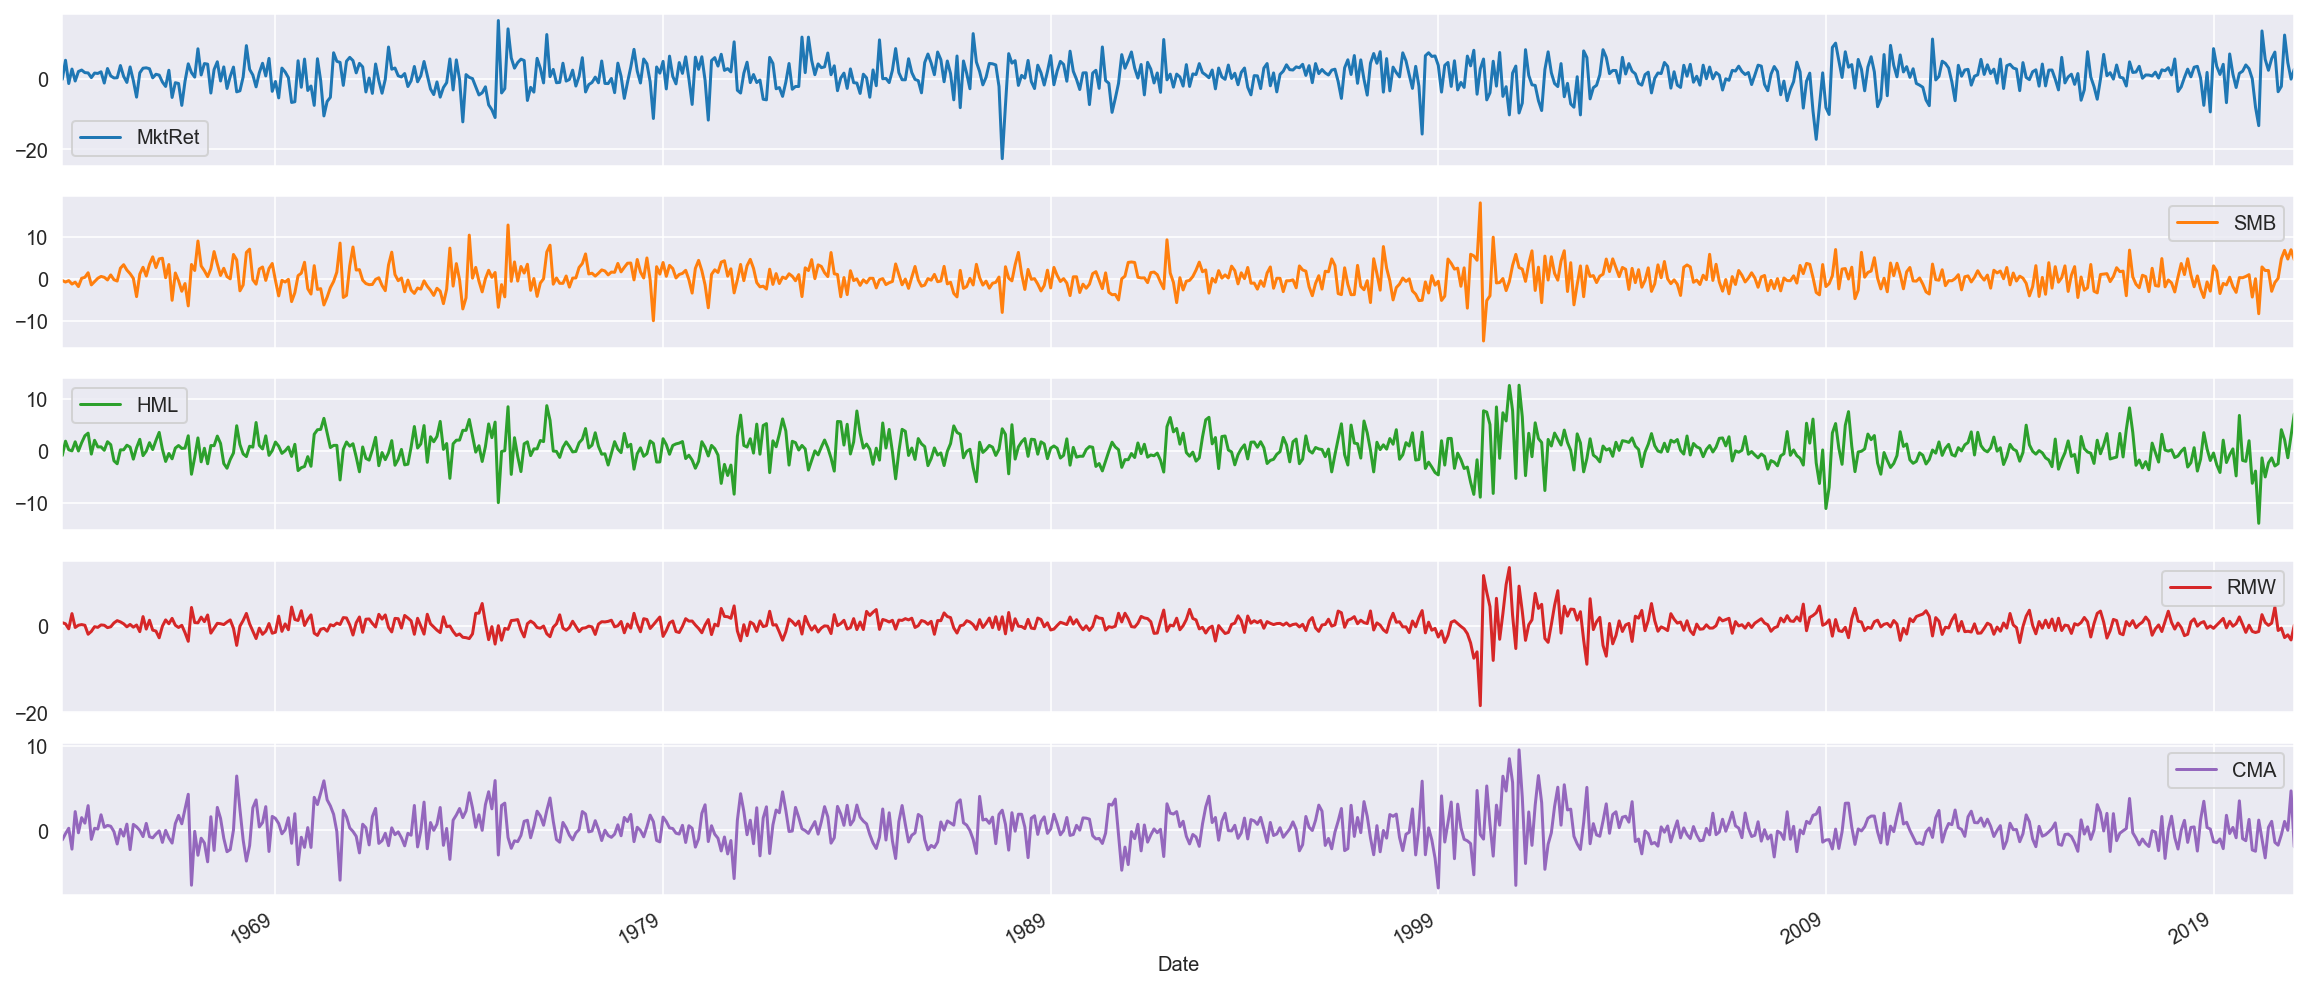

In [8]:
FF5_m.plot(subplots=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002043F045B70>,
      dtype=object)

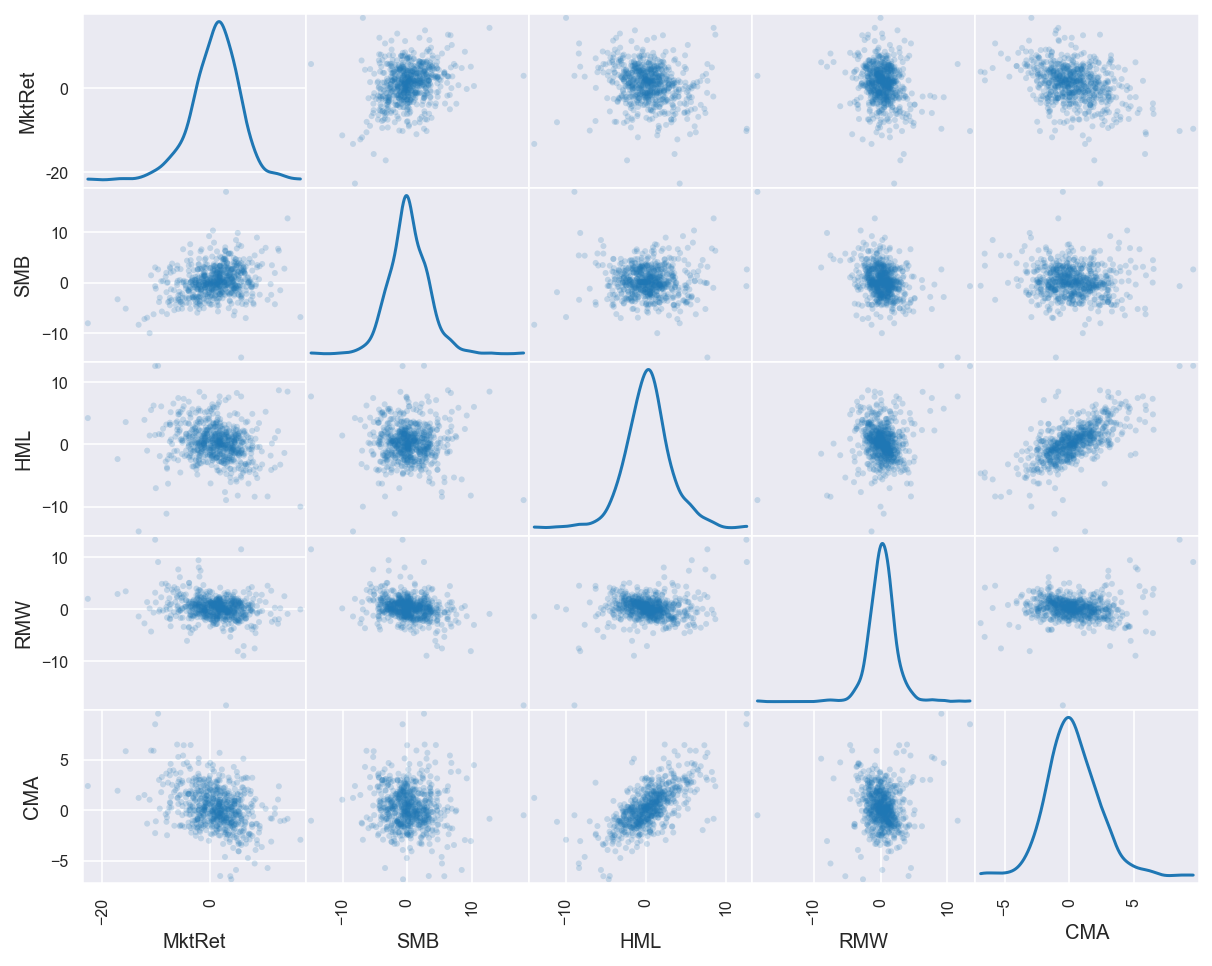

In [9]:
# among factor columns
pd.plotting.scatter_matrix(FF5_m, alpha=0.2, figsize=(10,8), diagonal='kde')

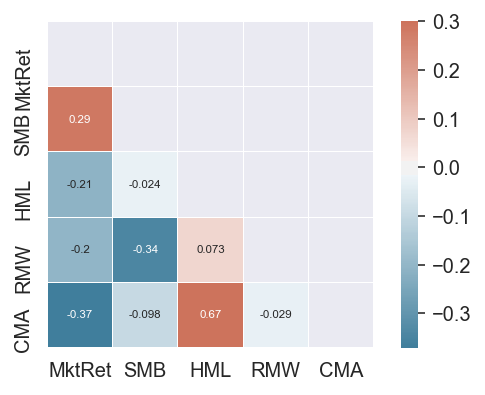

In [10]:
C = FF5_m.corr() # see correlation
mask = np.triu(np.ones_like(C, dtype=bool)) # Generate a mask for the upper triangle
f, ax = plt.subplots(figsize=(5, 3)) # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(C, annot=True, annot_kws = {'fontsize':'xx-small'} ,mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.01) # Draw the heatmap with the mask and correct aspect ratio

In [11]:
FF5_m.agg(['mean','std','skew','kurtosis','max','min']) # large variations

,MktRet,SMB,HML,RMW,CMA
mean,0.941705,0.245737,0.264624,0.243309,0.259422
std,4.445684,3.036731,2.875792,2.168072,1.994344
skew,-0.495774,0.334688,0.018850,-0.325994,0.321993
kurtosis,1.938968,2.927923,2.361640,12.311538,1.602861
max,16.610000,18.080000,12.580000,13.380000,9.560000
min,-22.640000,-14.890000,-13.960000,-18.480000,-6.860000


FF5 Findings:
- Something strange around 2000, can do further research.
- There are some factors are sort of correlated with other, such as HML vs CMA.

### II.B) AQR monthly returns

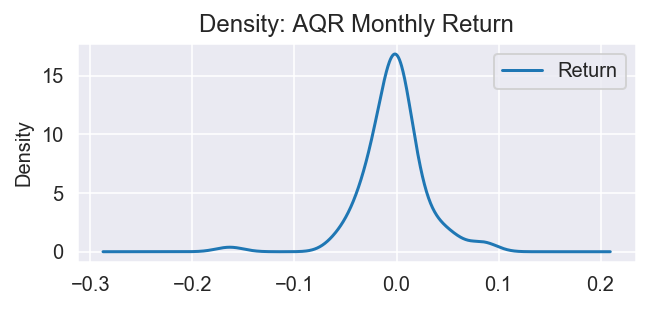

In [12]:
AQR_m.plot(kind='kde', figsize=(5,2), title='Density: AQR Monthly Return')


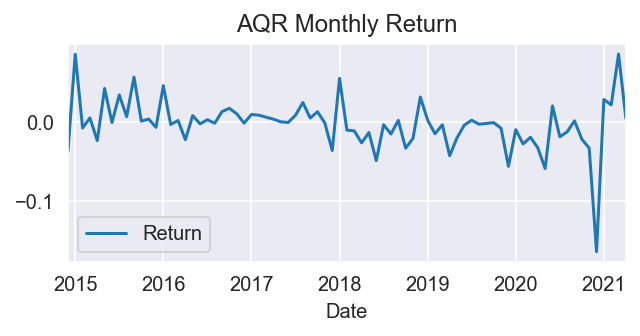

In [13]:
AQR_m.plot(figsize=(5,2), title='AQR Monthly Return')

In [14]:
AQR_m.agg(['mean','std','skew','kurtosis','max','min'])

,Return
mean,-0.002930
std,0.032206
skew,-1.086107
kurtosis,8.172043
max,0.085250
min,-0.163390


AQR Monthly Returns Findings:
- Pay attention on extremes, such as what impacted AQR before 2021.

### II.C) Relationship between FF5 and AQR returns:

In [15]:
start = max(b1, b3)
end = min(e1, e3)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start)[:7])
print('end_date: ', str(end)[:7])

FF5_m_2 = FF5_m.loc[start:end]
AQR_m_2 = AQR_m.loc[start:end]

data_all_m = pd.merge(AQR_m_2, FF5_m_2, left_index=True, right_index=True)
print(data_all_m.shape)
data_all_m

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-12
end_date:  2021-02
(75, 6)


,Return,MktRet,SMB,HML,RMW,CMA
Date,,,,,,
2014-12-01,-0.037259,-0.06,2.85,2.23,-1.16,0.88
2015-01-01,0.085110,-3.11,-0.86,-3.56,1.68,-1.65
2015-02-01,-0.007797,6.14,0.23,-1.81,-1.16,-1.78
2015-03-01,0.004880,-1.12,3.04,-0.41,0.10,-0.51
2015-04-01,-0.023646,0.59,-3.06,1.88,-0.04,-0.45
...,...,...,...,...,...,...
2020-10-01,-0.021894,-2.09,4.76,4.03,-0.60,-0.53
2020-11-01,-0.033094,12.48,6.75,2.11,-2.78,1.05
2020-12-01,-0.163390,4.64,4.67,-1.36,-2.15,0.00


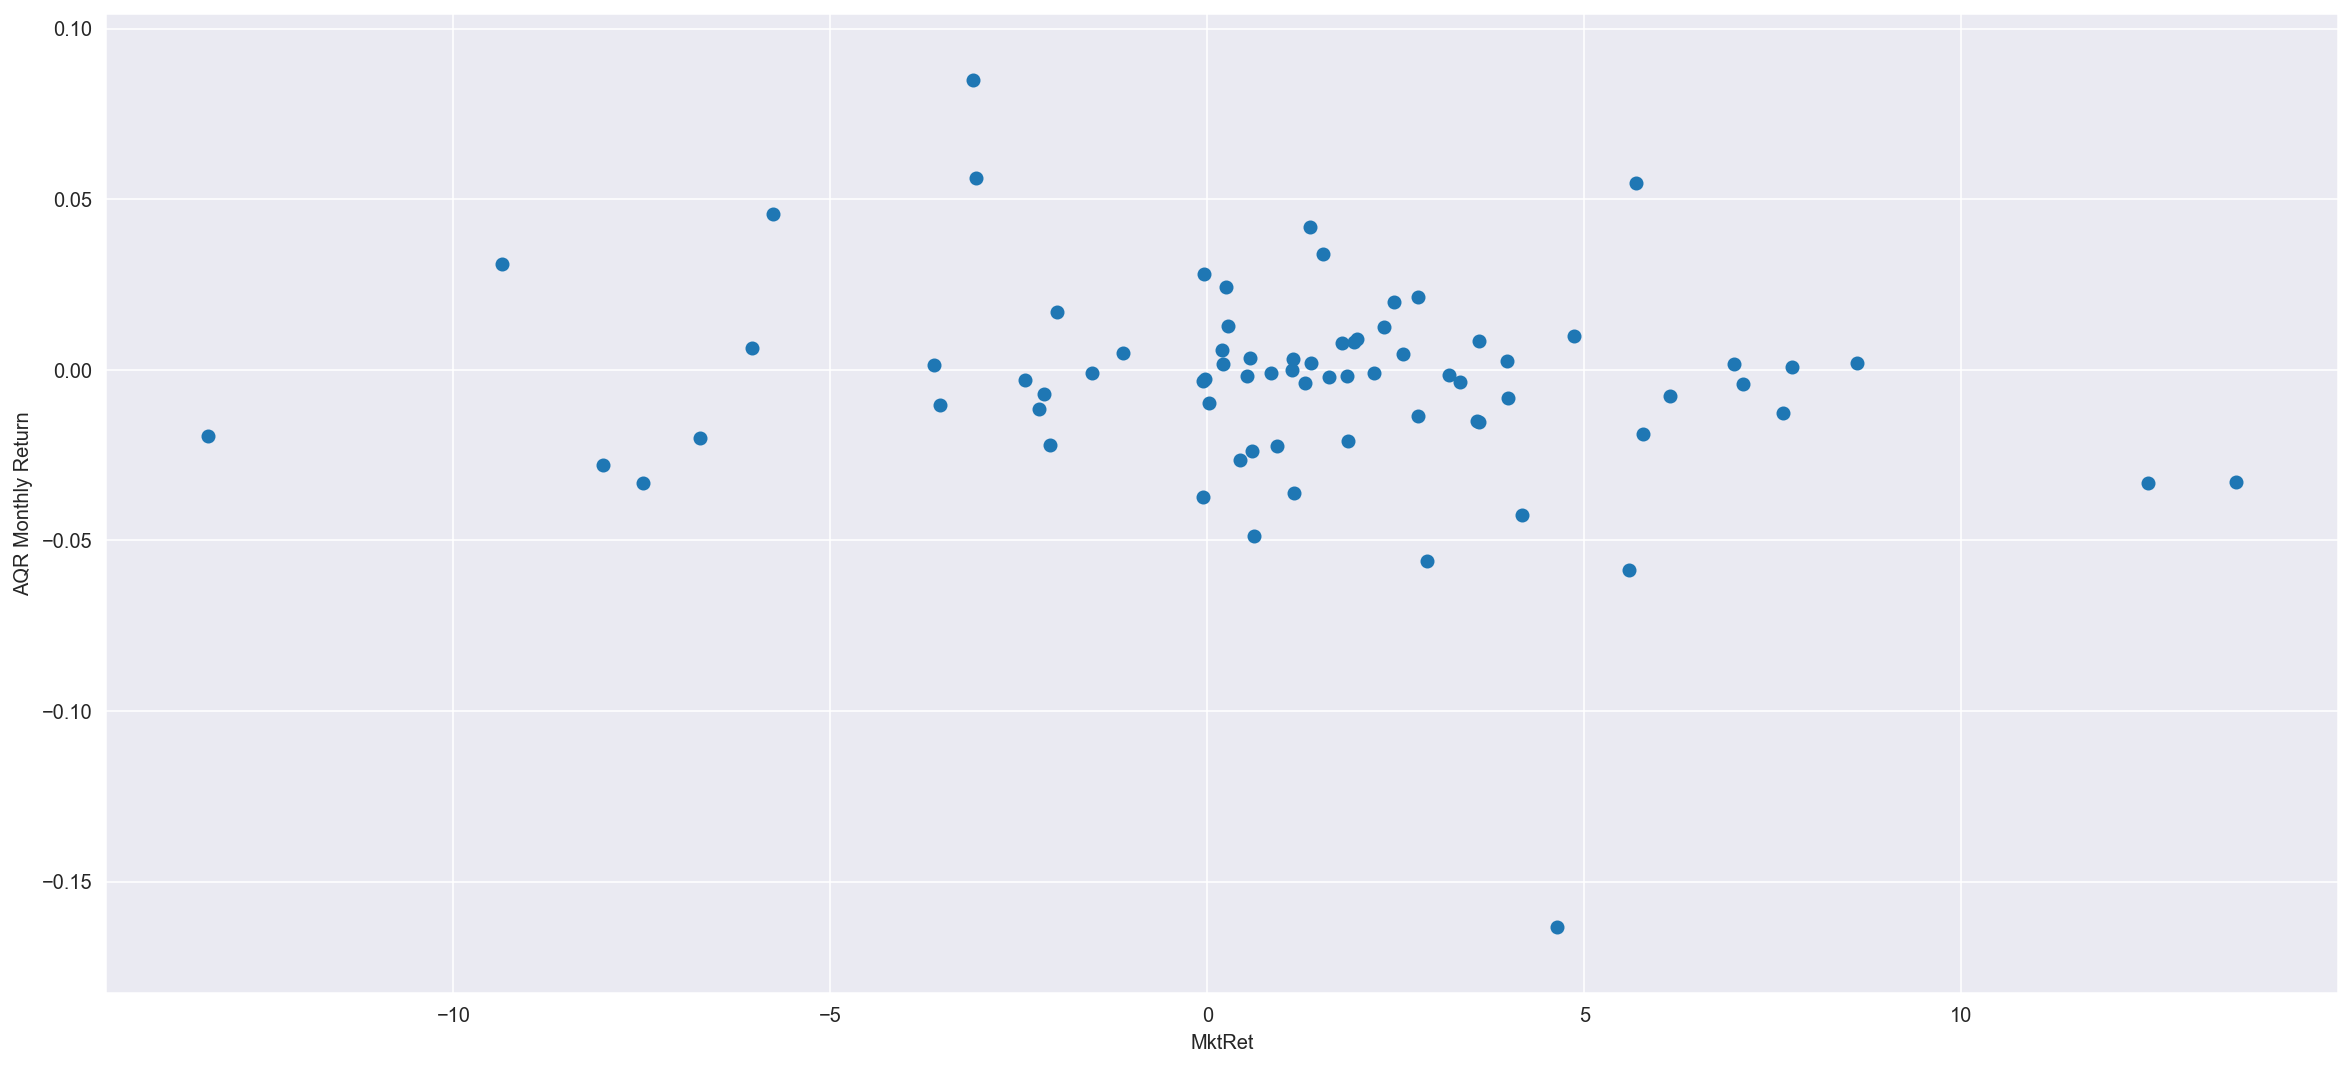

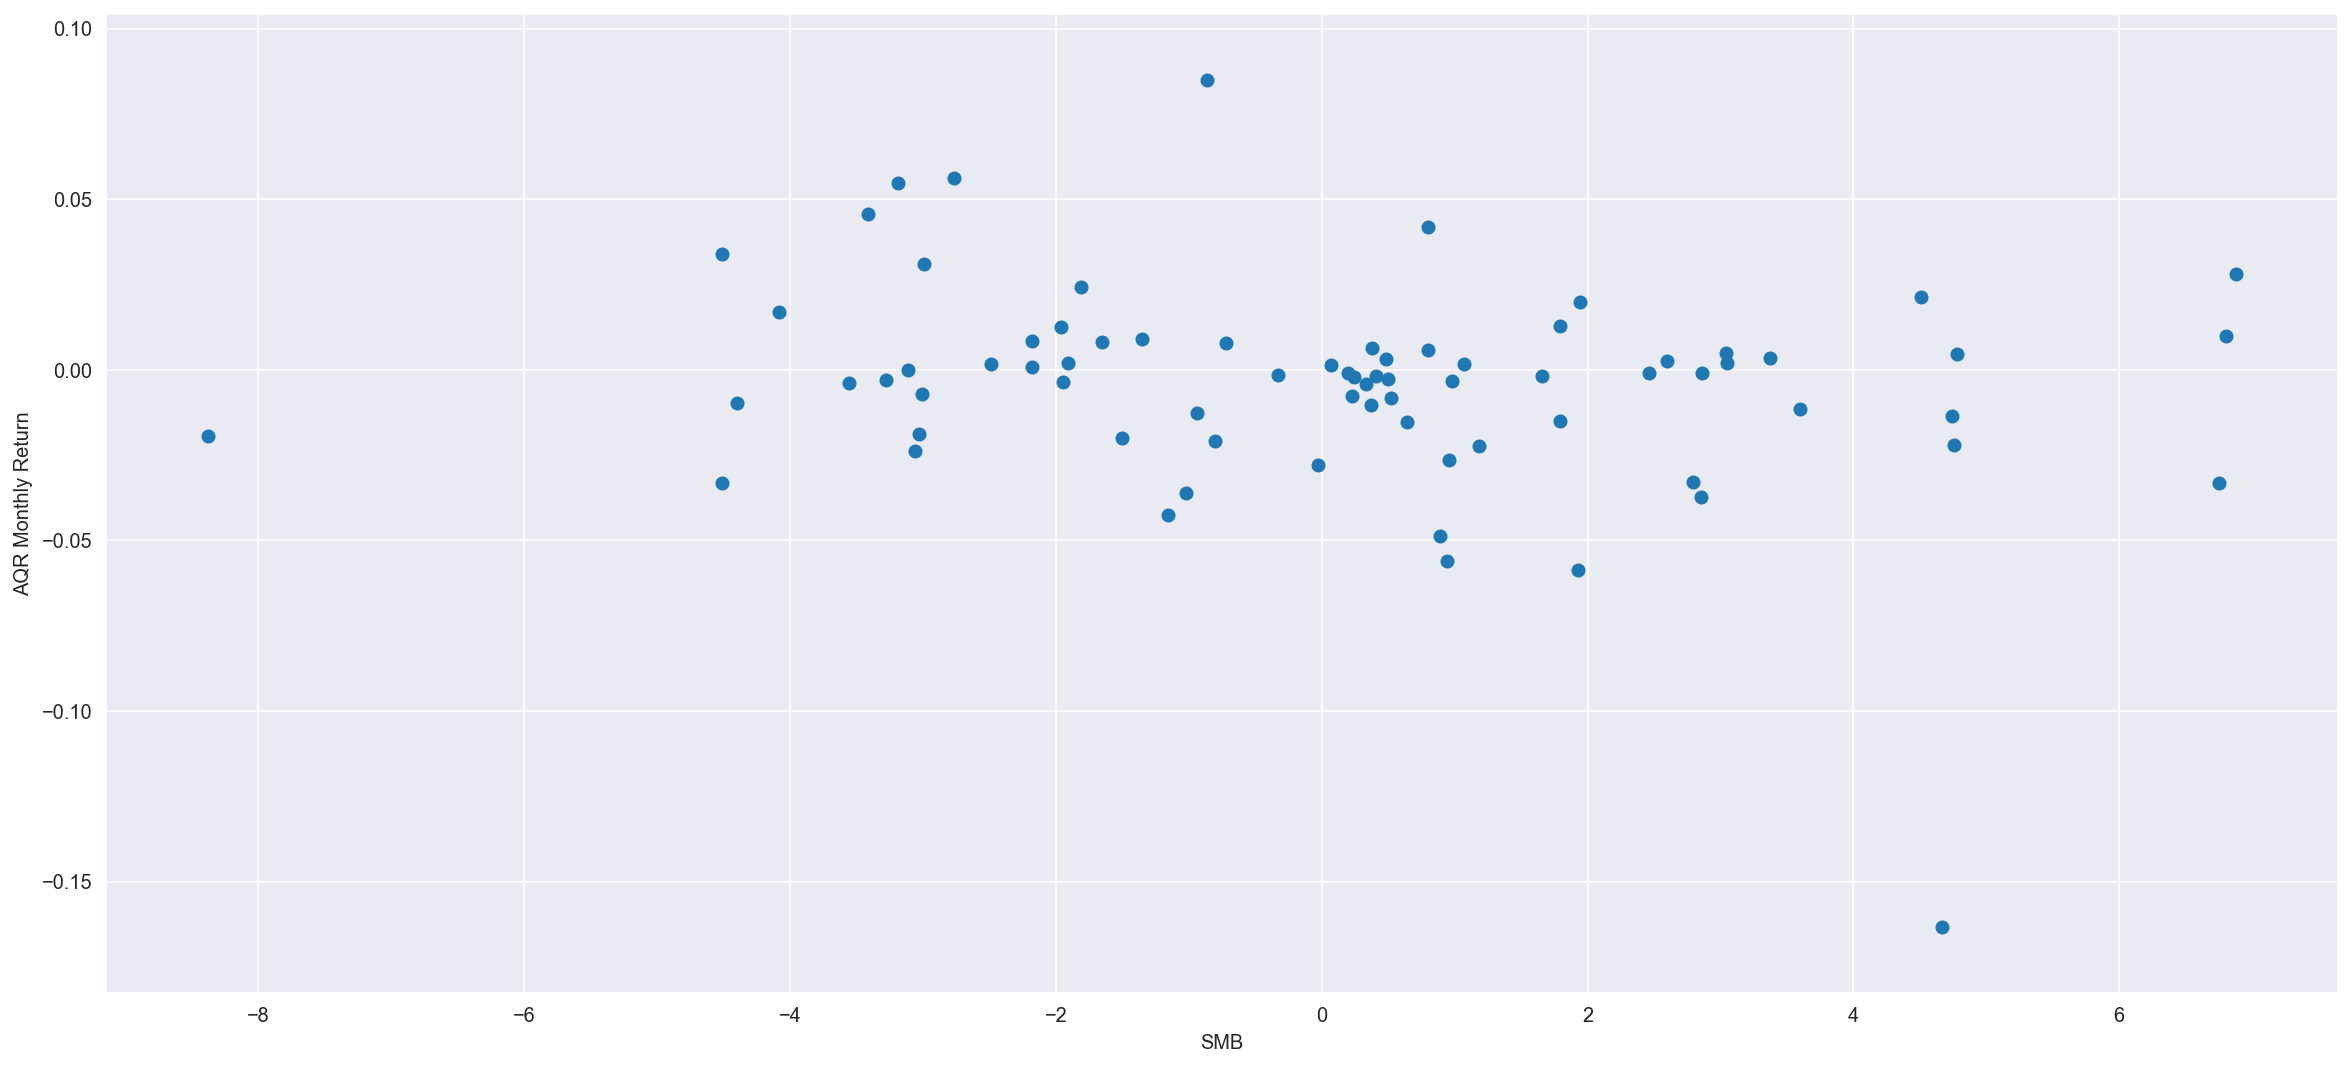

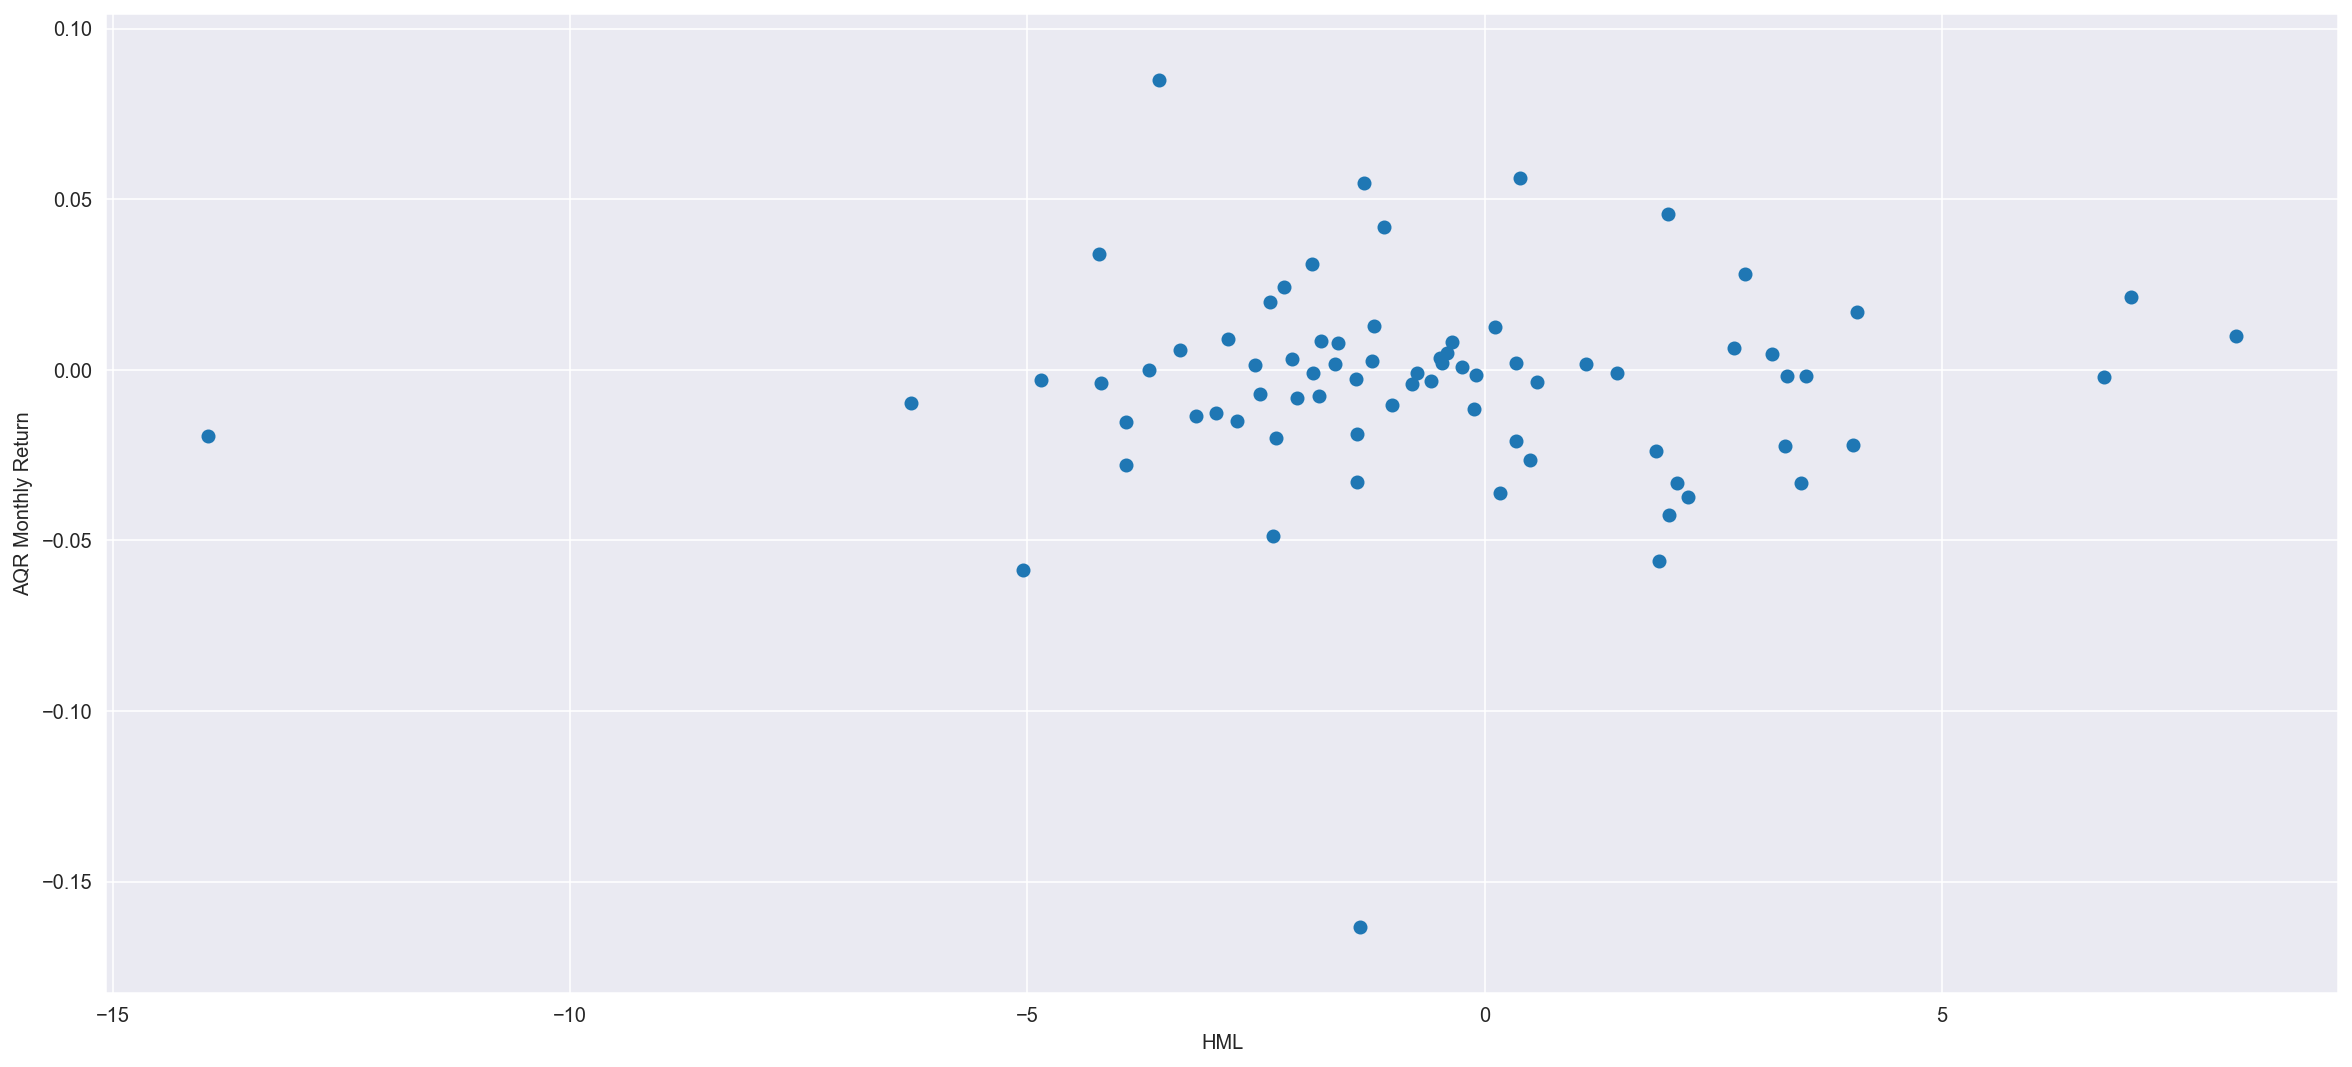

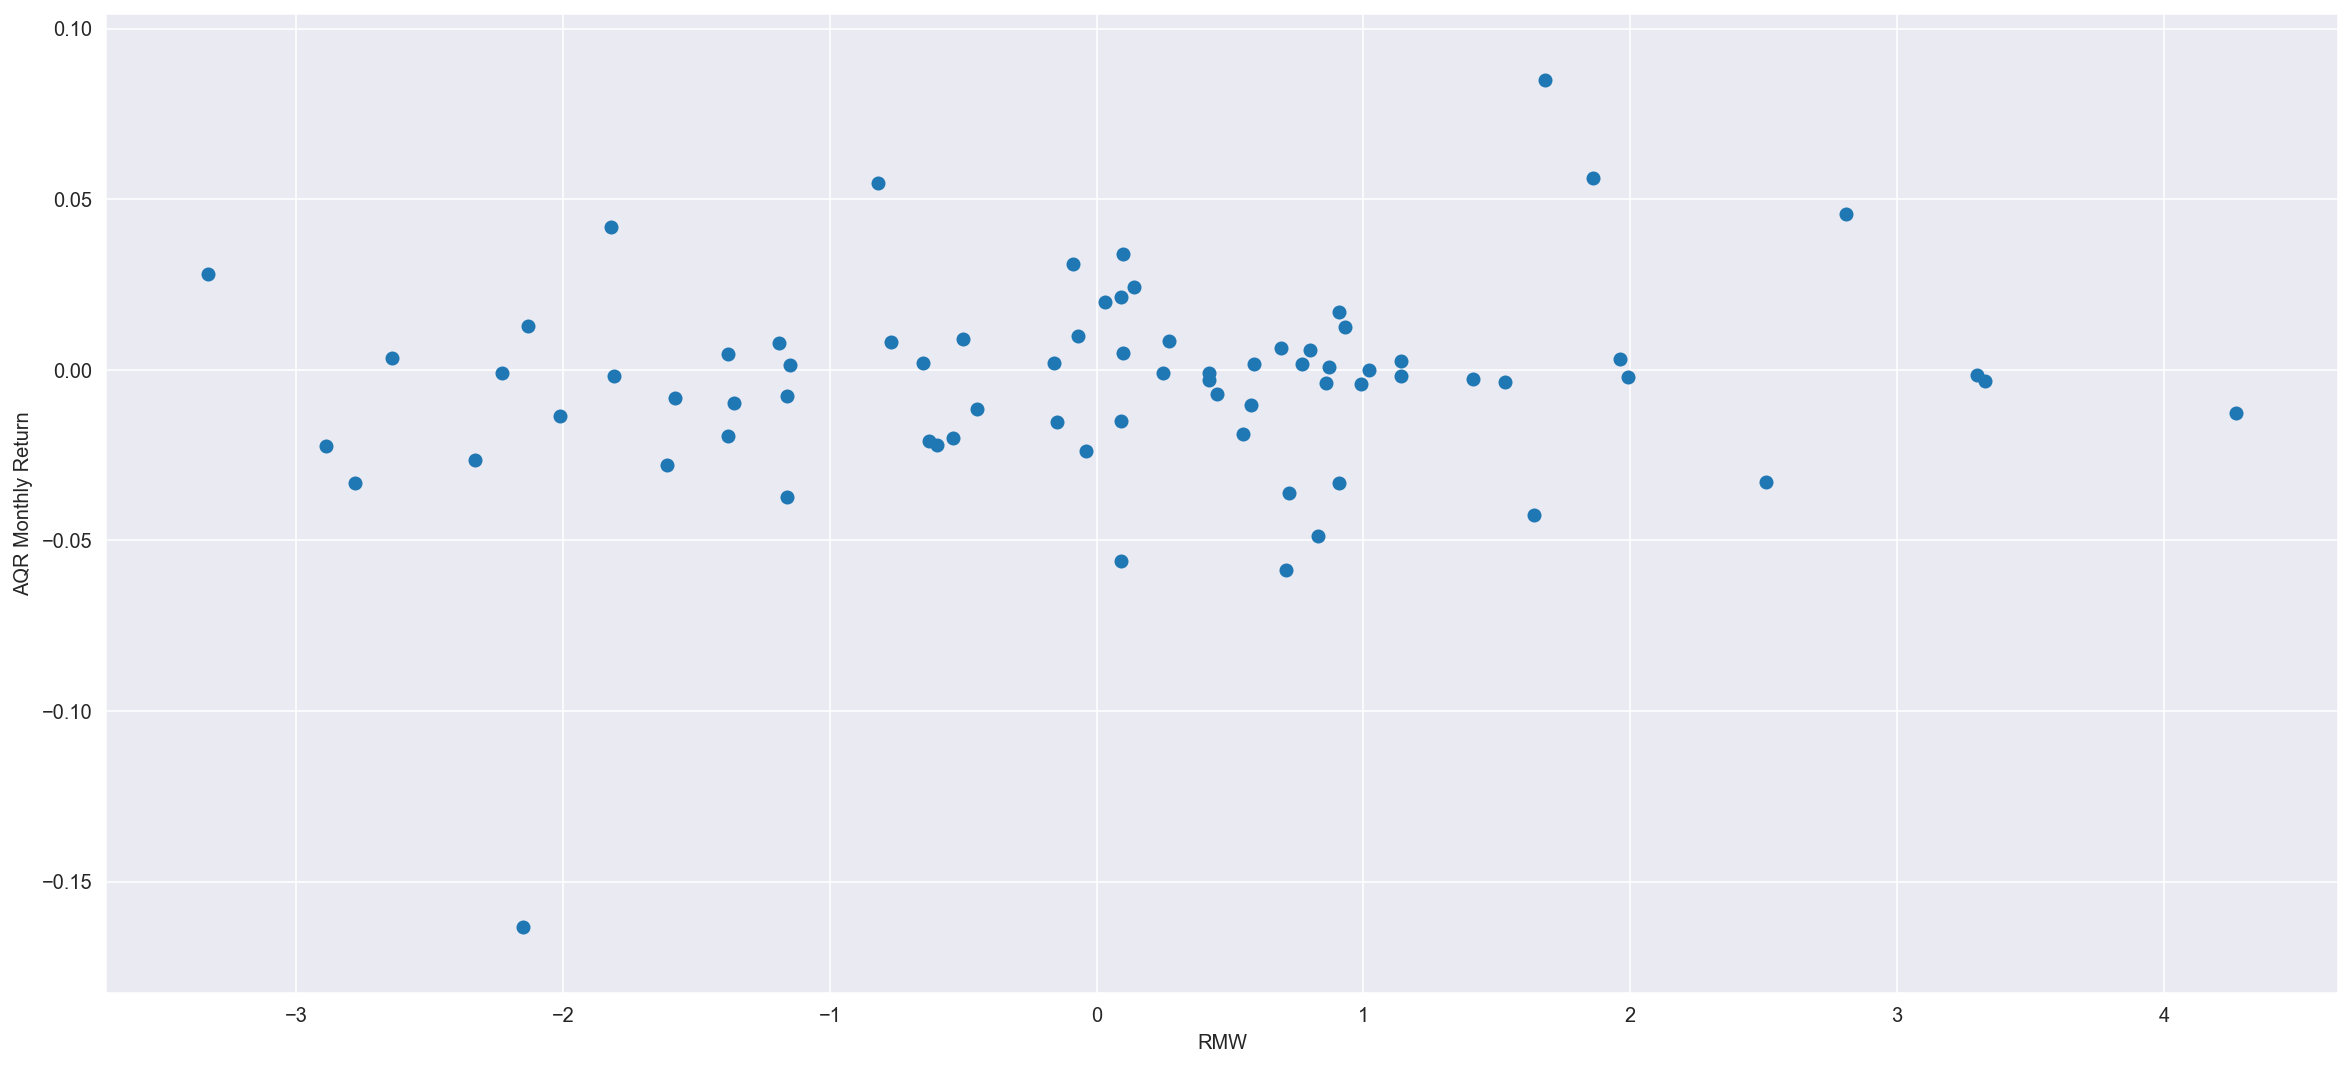

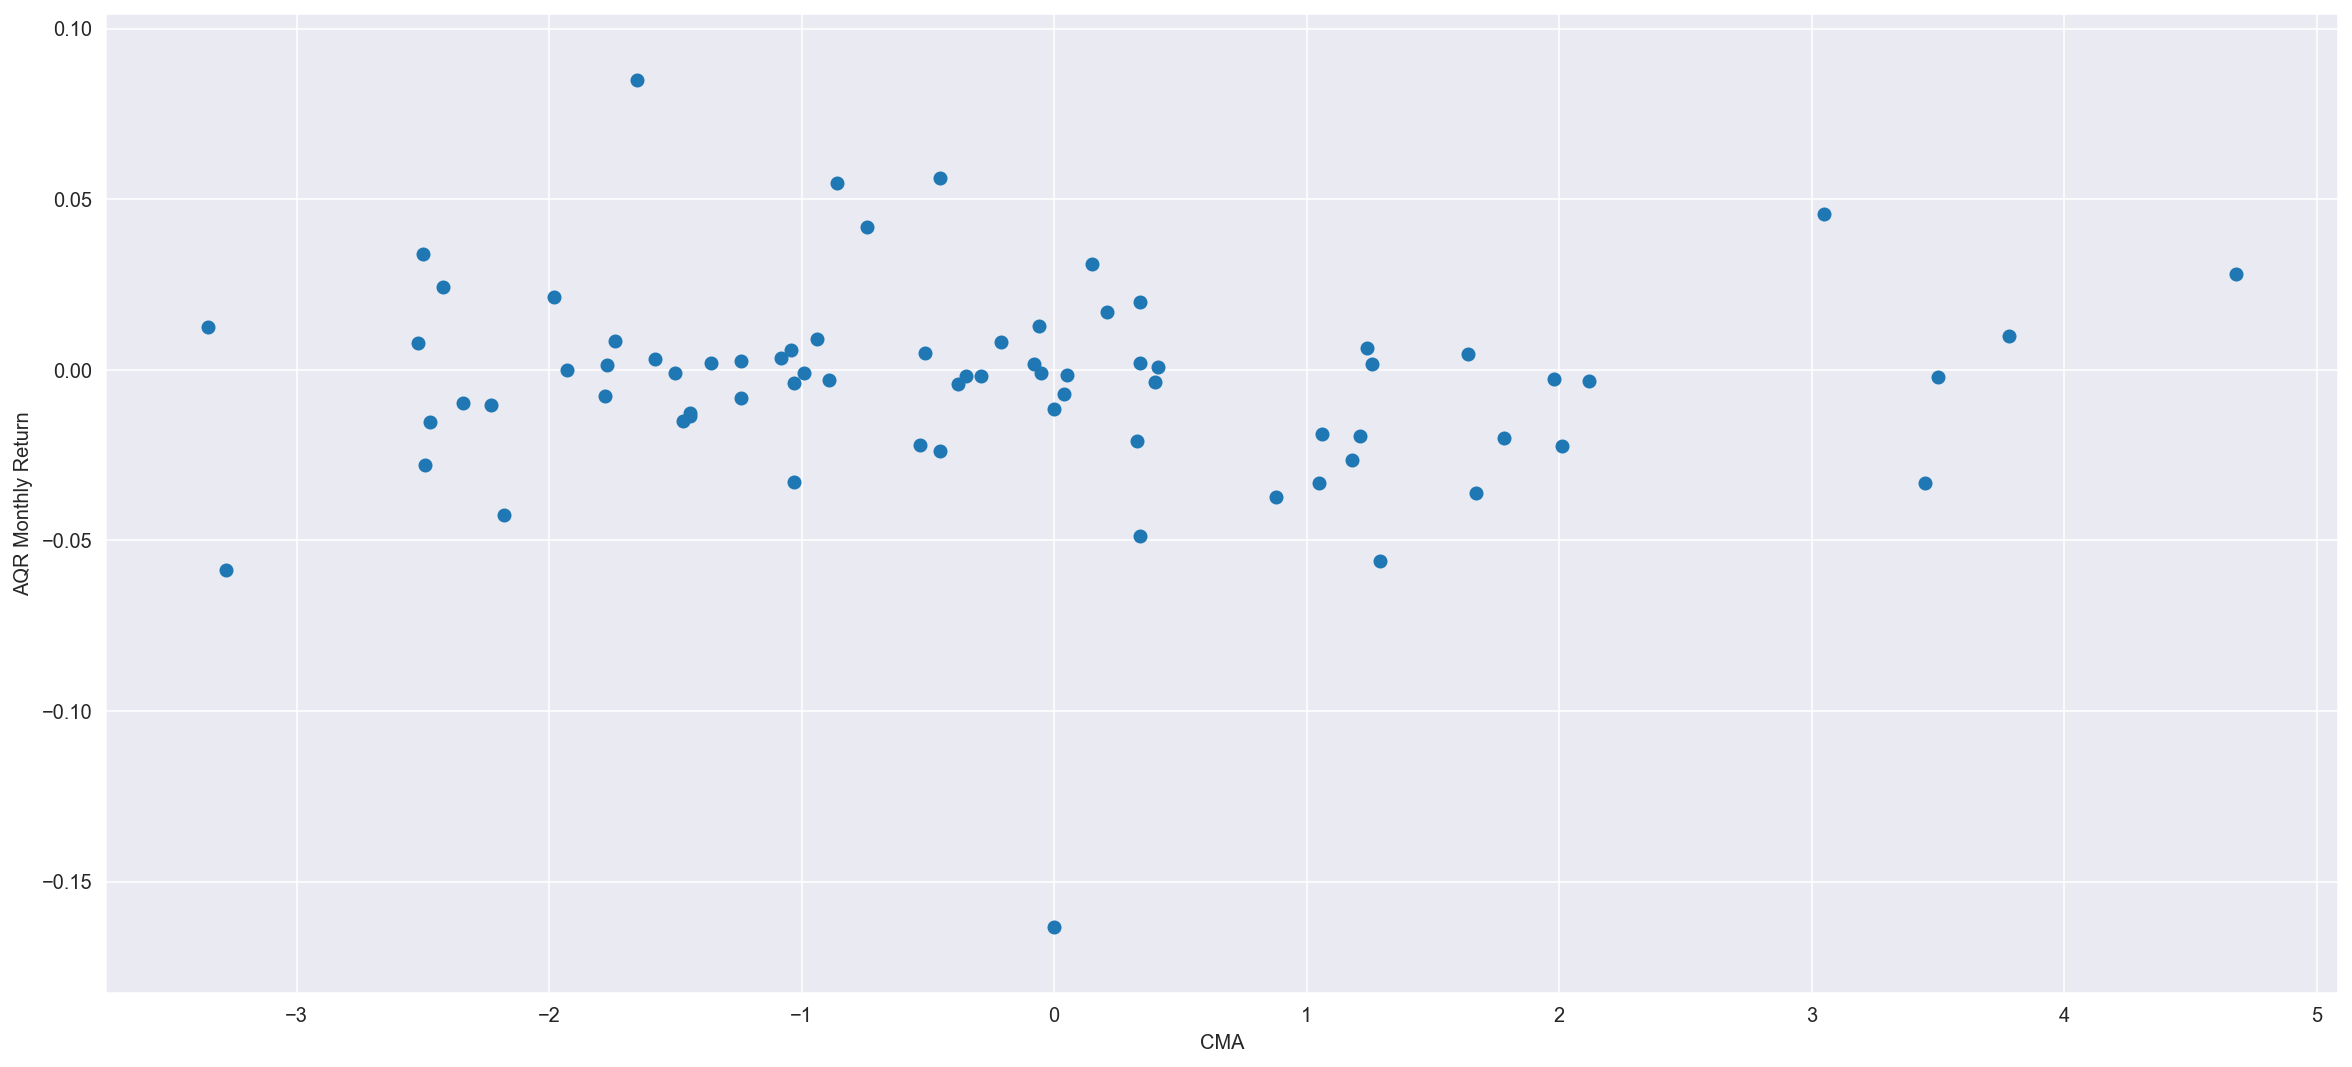

In [16]:
attributes = FF5_m_2.columns
for att in attributes:
    # plt.figure(figsize=(5,5))
    plt.scatter(FF5_m_2[att], AQR_m_2['Return'])
    plt.xlabel(att)
    plt.ylabel('AQR Monthly Return')
    plt.show()

In [17]:
# correlations
print(data_all_m.corr()[['Return']])

          Return
Return  1.000000
MktRet -0.184486
SMB    -0.217977
HML     0.035924
RMW     0.156176
CMA    -0.052198


Factors and AQR return Findings:
- In short, monthly data is a small sample, lack of obvious and strong conclusions can be made through scatter plots.


### II.D) Perform tests for stationarity of all data series.
The **Augmented Dickey-Fuller test** is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The **null hypothesis** of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The **alternate hypothesis** (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is **non-stationary**. It has some time dependent structure.
**Alternate Hypothesis (Ha)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is **stationary**. It does not have time-dependent structure.

We interpret this result using the **p-value** from the test. 
- **p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is **non-stationary**.
- **p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is **stationary**.

In [18]:
from statsmodels.tsa.stattools import adfuller
sig = 0.05
print(f'Performing ADF test... at significant level = {sig}')
for i in FF5_m_RF.columns:
    print('-'*15)
    print(f'{i}')
    result = adfuller(FF5_m_RF[i])
    print(f'  p-value: {result[1]}')
    if result[1] > sig:
        print('  Result: non-stationary')
    else:
        print('  Result: stationary')

for i in AQR_m.columns:
    print('-'*15)
    print(f'{i}')
    result = adfuller(AQR_m[i])
    print(f'  p-value: {result[1]}')
    if result[1] > sig:
        print('  Result: non-stationary')
    else:
        print('  Result: stationary')

Performing ADF test... at significant level = 0.05
---------------
MktRet
  p-value: 0.0
  Result: stationary
---------------
SMB
  p-value: 1.148608879537585e-27
  Result: stationary
---------------
HML
  p-value: 1.490492305770346e-28
  Result: stationary
---------------
RMW
  p-value: 1.1194881286479064e-10
  Result: stationary
---------------
CMA
  p-value: 3.853140591567842e-10
  Result: stationary
---------------
RF
  p-value: 0.22960053765924954
  Result: non-stationary
---------------
Return
  p-value: 1.1734305321913614e-05
  Result: stationary


Stationary Finding:
- Based on ADF test, the time series of risk-free rate is the only one that is non-stationary.

### III. Regression
- Regress AQR monthly returns on the Fama-French factors 
- Discuss the regression results, including 
    - t-test, 
    - F-tests and 
    - $R^2$. 
    - Is the intercept statistically different from 0?

**Model**
$$\text{AQR Return}_i = a_i + b_i*\text{MktRet} + s_i*\text{SMB} + h_i*\text{HMI} + r_i*\text{RMW} + c_i*\text{CMA} + \epsilon_i$$

In [19]:
# regressors: 5 Factors
X_m = data_all_m[data_all_m.columns[1:]]
# response variable: Returns of QMNIX Monthly   
y_m = data_all_m[['Return']]

In [20]:
# Running OLS model:
import statsmodels.api as sm
X_m = sm.add_constant(X_m)
model_m = sm.OLS(y_m, X_m, missing='raise')
result_m = model_m.fit()
tstat_m = result_m.tvalues
coeff_m = result_m.params
fitted_m = result_m.fittedvalues
resid_m = result_m.resid
result_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.724
Date:                Fri, 16 Apr 2021   Prob (F-statistic):              0.141
Time:                        01:13:49   Log-Likelihood:                 159.15
No. Observations:                  75   AIC:                            -306.3
Df Residuals:                      69   BIC:                            -292.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.004     -0.512      0.610      -0.009       0.005
MktRet        -0.0013      0.001     -1.431      0.157      -0.003       0.001
SMB           -0.0021      0.002     -1.328      0.189      -0.005       0.001
HML            0.0023      0.001      1.636      0.106      -0.001       0.005
RMW            0.0019      0.003      0.745      0.459      -0.003       0.007
CMA           -0.0031      0.002     -1.260      0.212      -0.008       0.002
==============================================================================
Omnibus:                       31.261   Durbin-Watson:                   2.407
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.396
Skew:                          -1.097   Prob(JB):                     7.98e-29
Kurtosis:                       9.049   Cond. No.                         5.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpret:
**t-test**: in the table, for each t-test, it means given other coefs are statistically significant
- H_0: not significant. 
- H_a: the coef is significant.
- p < 0.05, reject null, conclude significance.

Therefore, given all others are significant, no individual coefficient is statistically significant.

**F-test**: in the table, for the F-stats, it means the overall model evaluation.
- H_0: our model does not explain the variance any better than the intercept only model. we want the intercept only model.
- H_a: our model is better than the intercept only one.
- Prob (F-statistic) is just the p-value of this test. If Prob (F-statistic) < 0.05, reject null, conclude our model is good.

Therefore, p-value = 0.141 > 0.05 and we fail to reject null, and we need to conclude that our model is not outperformed the intercept-only model.

**$R^2$**: the percentage of variance explained by our model factors.

0.111 means the model is not great in terms of explaining AQR return's variance.

**Intercept**: from t-test above, we conclude that, given other coefs are statistically significant, the intercept is not statistically significant.

#### Conclusion:

As we can see here, the model is not ideal in any ways. In other words, we did not find any useful factors that might influence the returns of AQR. 

It is likely because 
- we have limited observations when using monthly data. 
- monthly data did not satisfy OLS assumptions, and hence OLS failed.

Later on, we will see improvements in the case of daily data.

### IV. Demonstrate graphically whether the classical linear regression assumptions are satisfied or not for section III. Regressoin using monthly data

** Assumptions for OLS**
- Linearity
$$ y = X\beta + \epsilon $$
- Strict Exogeneity
$$ \mathbf{E}[\epsilon | X ] = 0$$
- No Multicollinearity
$$ \mathbf{P}[\text{rank}(X) = p] = 1 $$
- Spherical Errors
$$ \text{Var}[\epsilon|X] = \sigma^2I_n$$
- Normality
$$ \epsilon|X ∼ N(0, \sigma^2I_n)$$

### IV.A) Linearity: 
Nonlinearity is usually most evident in a plot of **observed versus predicted values** 
or a plot of **residuals versus predicted values**, which are a part of standard regression output.

The points should be symmetrically distributed around a diagonal line in the former plot or 
around horizontal line in the latter plot, with a roughly constant variance.  

(The residual-versus-predicted-plot is better than the observed-versus-predicted plot for 
this purpose, because it eliminates the visual distraction of a sloping pattern.)  

Look carefully for evidence of a "bowed" pattern, indicating that the model makes systematic 
errors whenever it is making unusually large or small predictions. In multiple regression 
models, nonlinearity or nonadditivity may also be revealed by systematic patterns in plots 
of the residuals versus individual independent variables.

In [21]:
def linearity_test(model, y):
    ''' Visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args
    ---------
    model: fitted OLS model from statsmodels
    y: observed values
    '''
    fitted_vals = model.fittedvalues
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    # Plotting the diagonal line
    line_coords = np.linspace(-0.04, 0.04,)
    ax[0].plot(line_coords, line_coords,color='grey')
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    # Plotting the horizontal line
    line_coords = np.linspace(-0.04, 0.04,)
    hr = np.zeros(len(line_coords))
    ax[1].plot(line_coords, hr,color='grey')
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')   

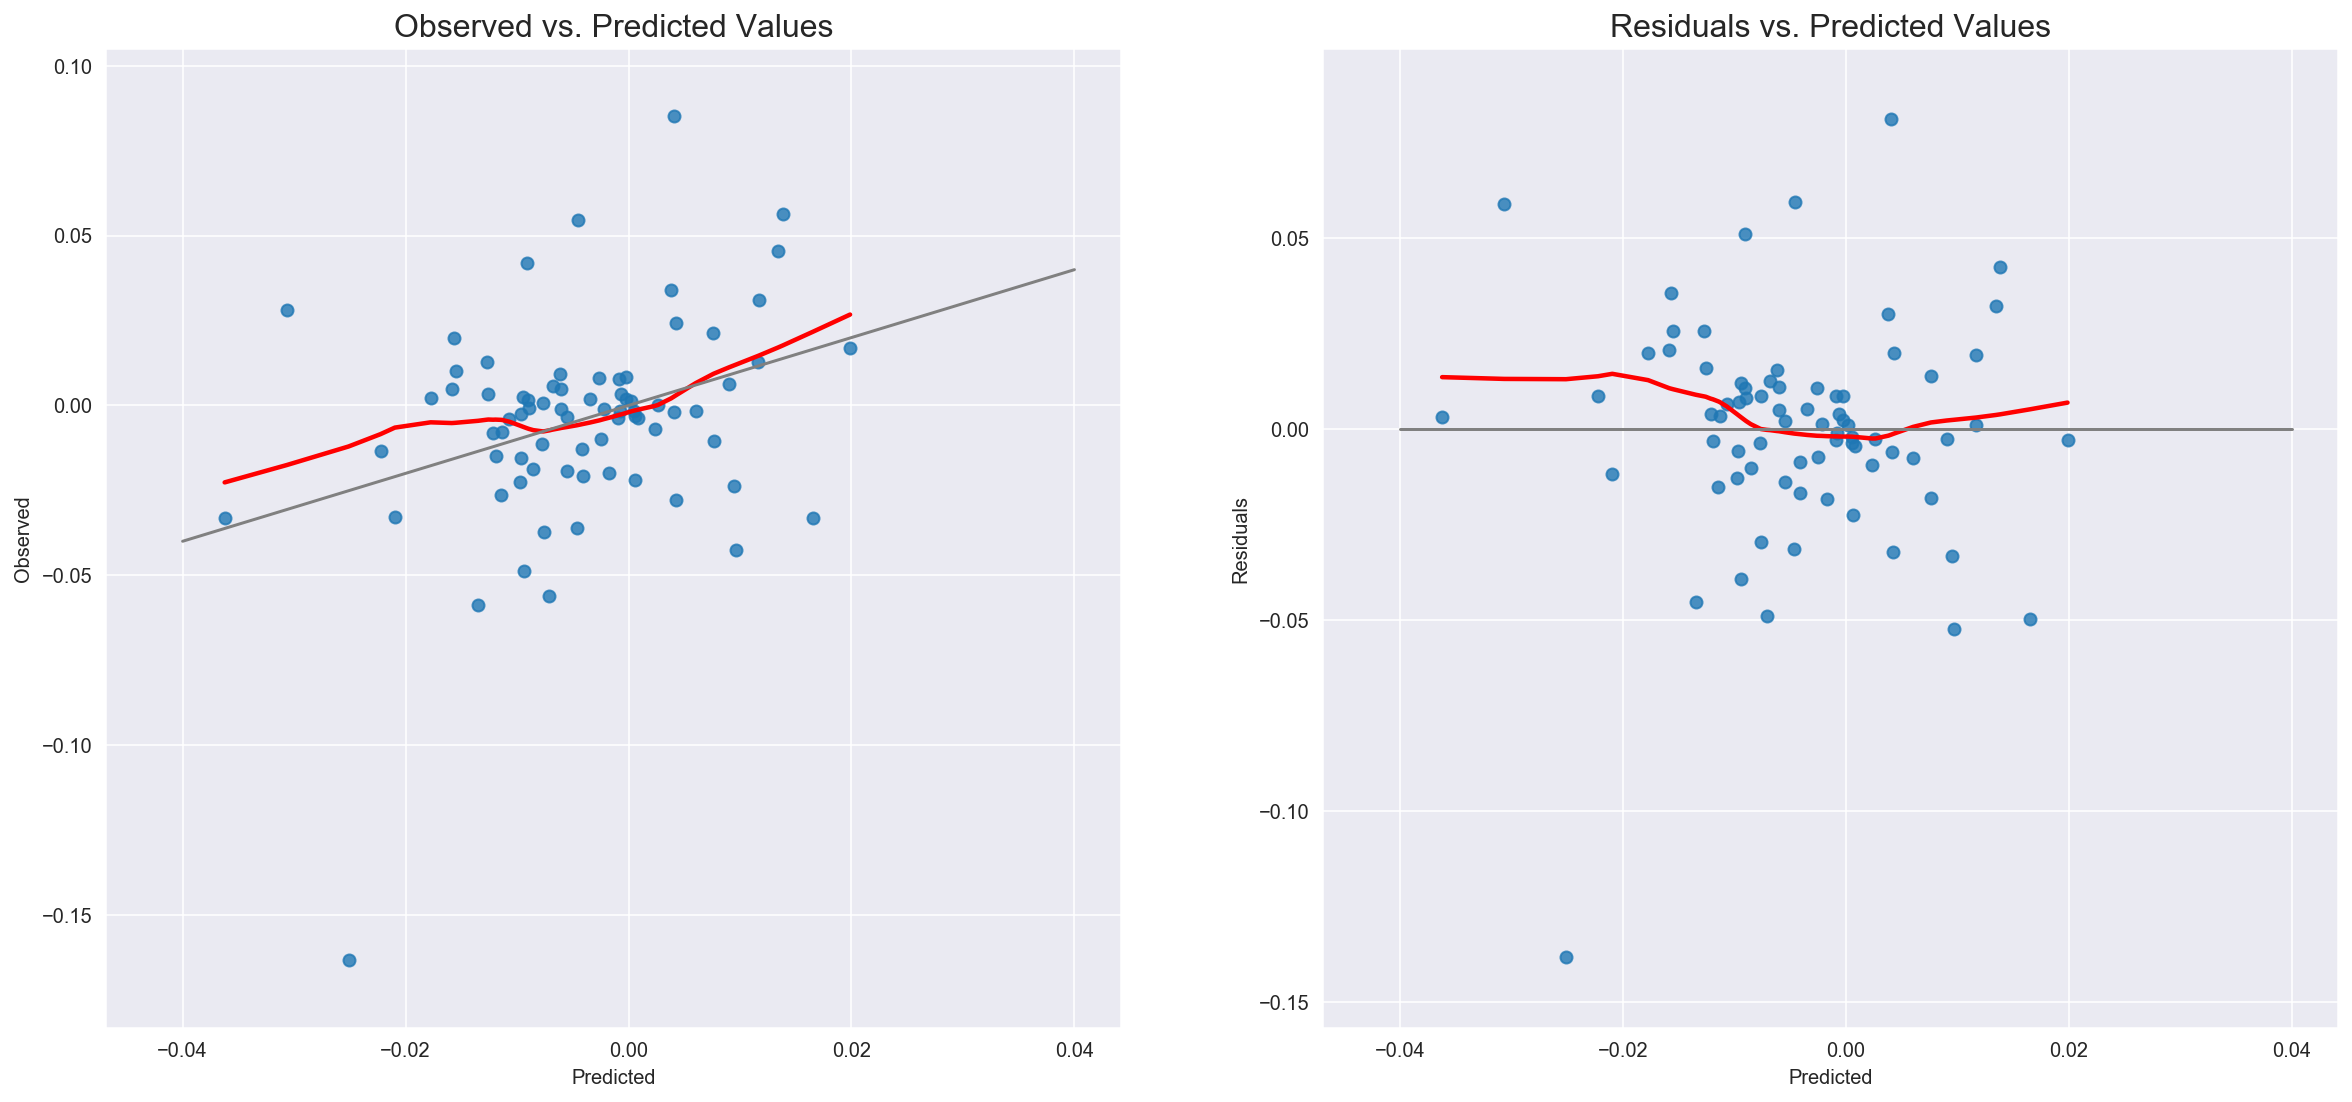

In [22]:
linearity_test(result_m, y_m) 

Linearity is roughly satisfied since there is clearly a bowl pattern indicating the model is making unusual large/small predictions. If a perfect linearity exists, the left plot should be scattered around diagnal line, and the right plot should be scattered around a horizontal line.

### IV.B) Strict exogeneity
The distribution of error terms has zero mean and doesn’t depend on the independent variables X. 
i.e. there must be no relationship between the X and the error term.

In [23]:
print(f"mean of residuals = {resid_m.mean()}")

mean of residuals = 1.1564823173178714e-19


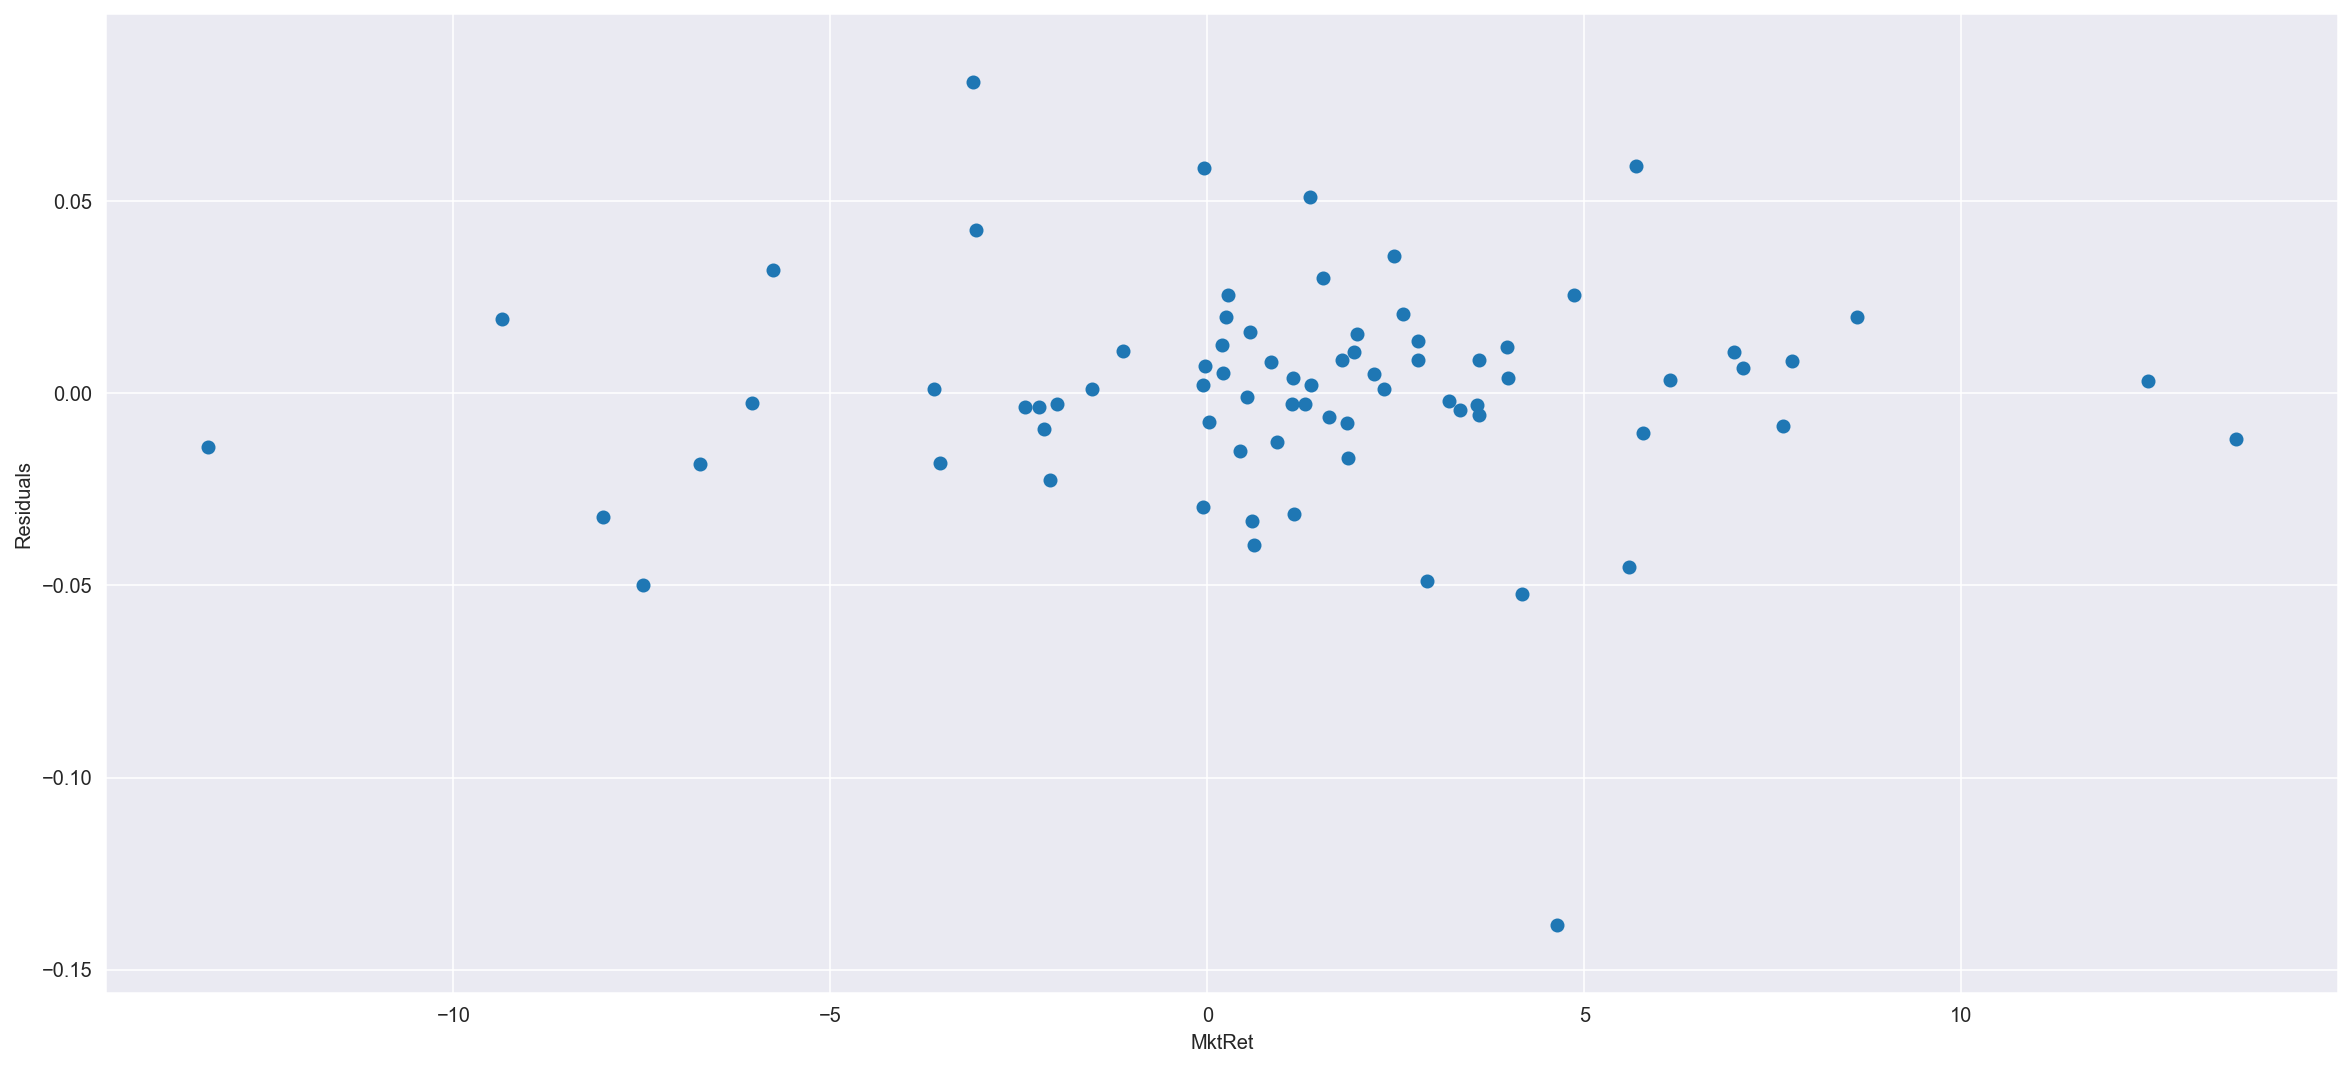

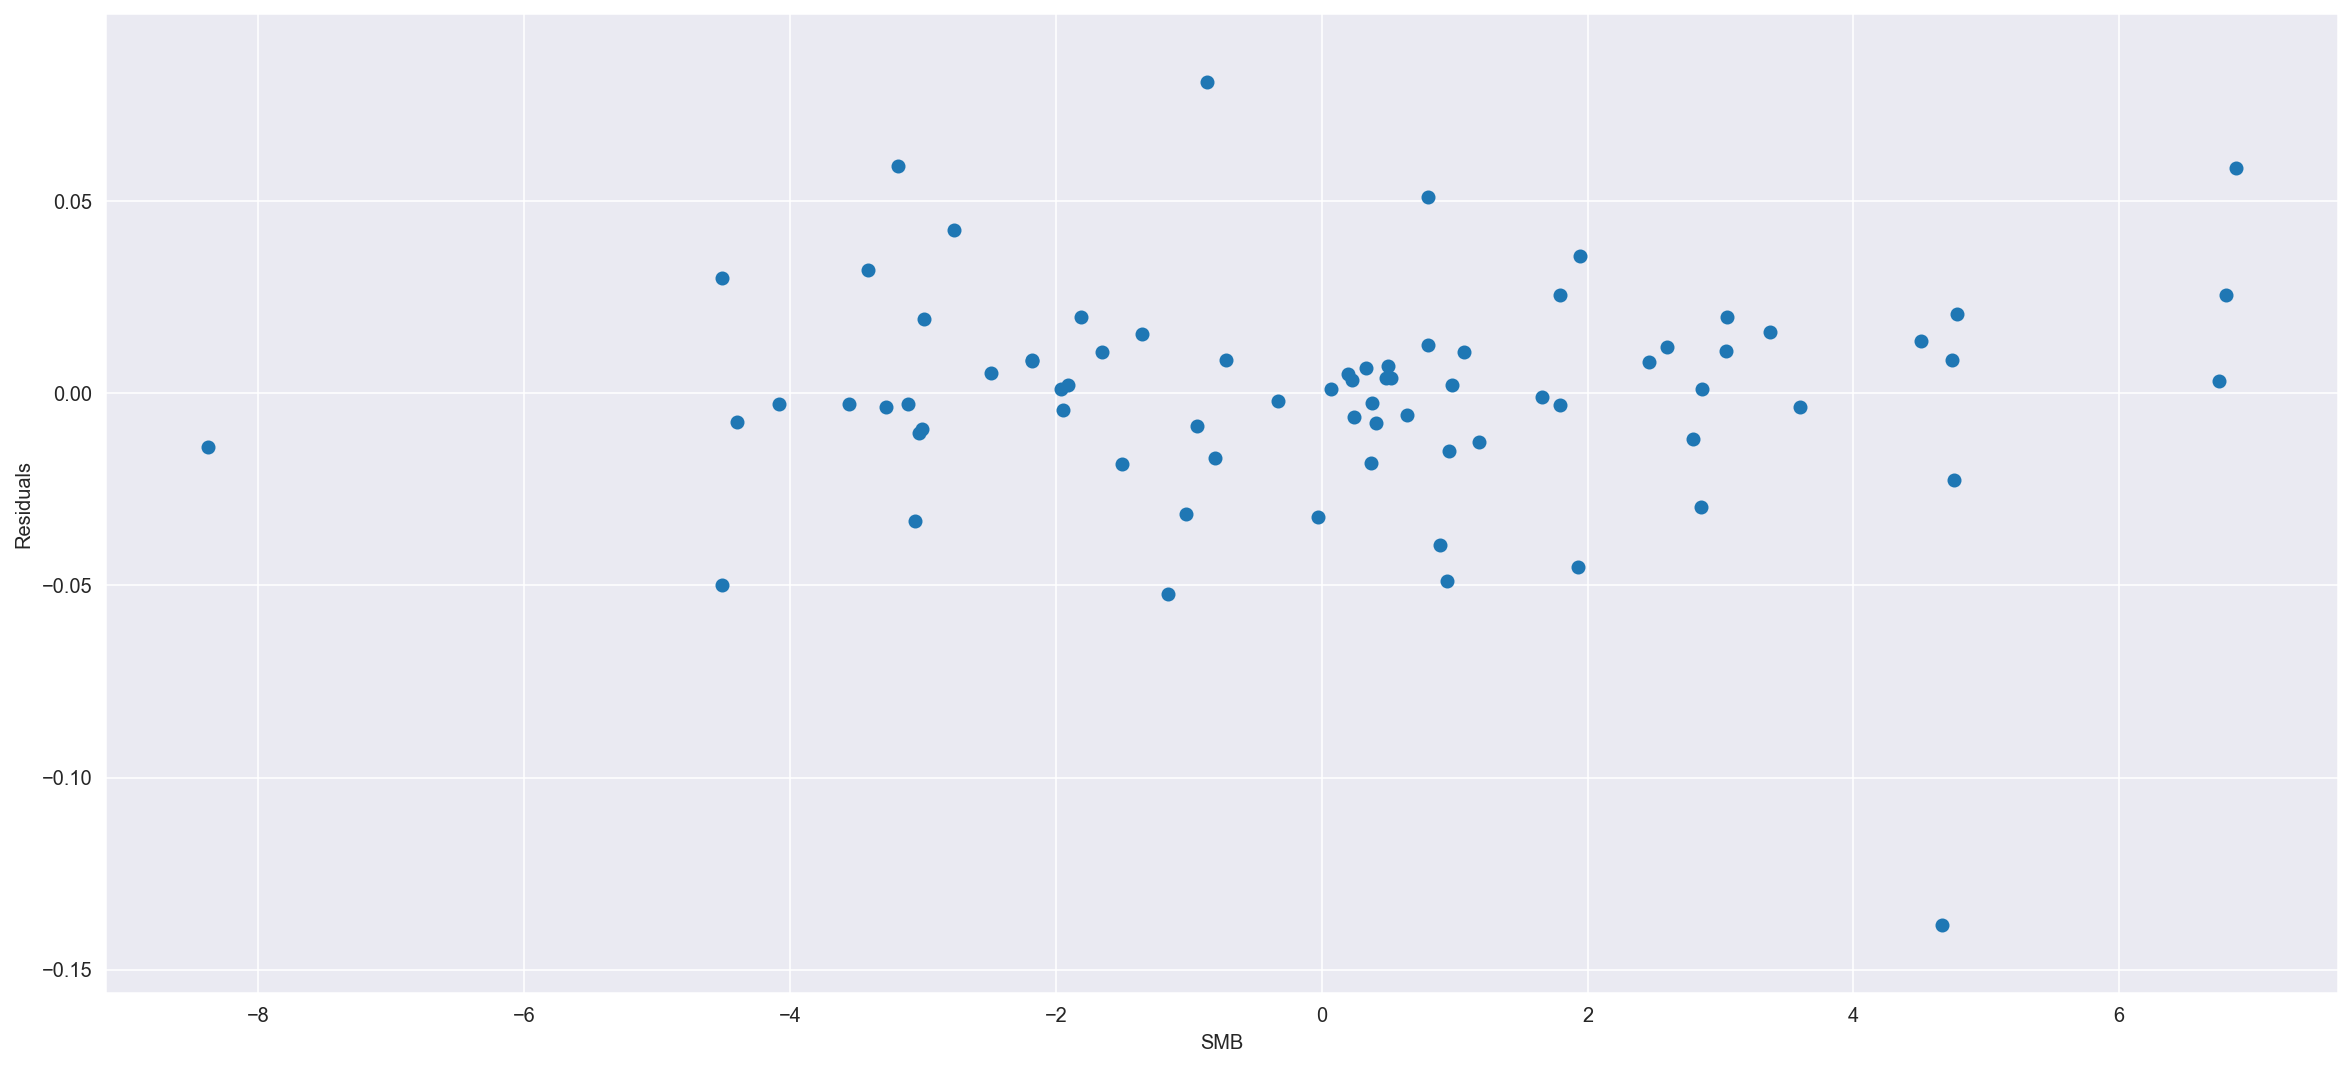

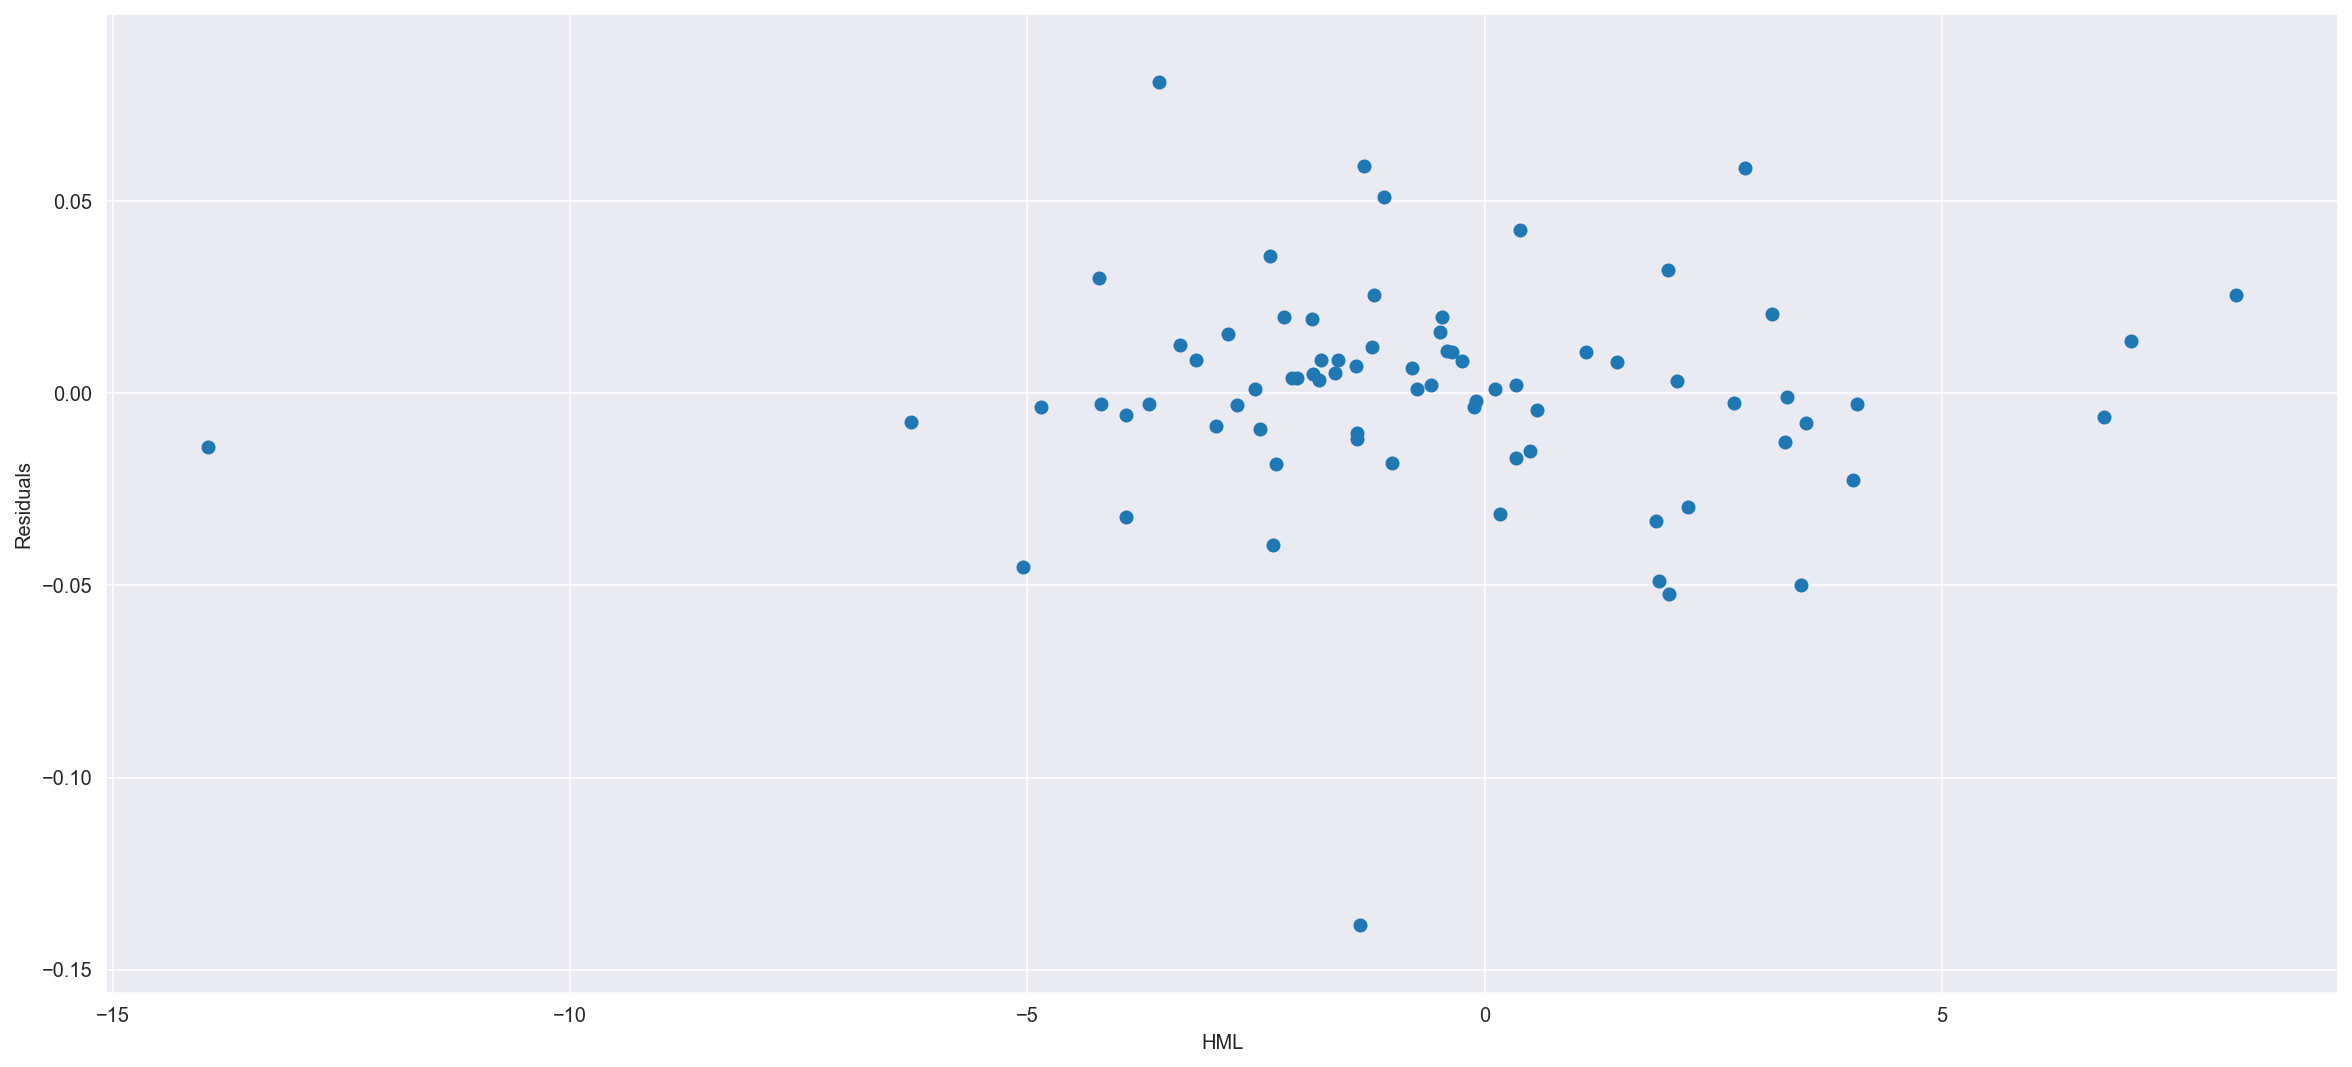

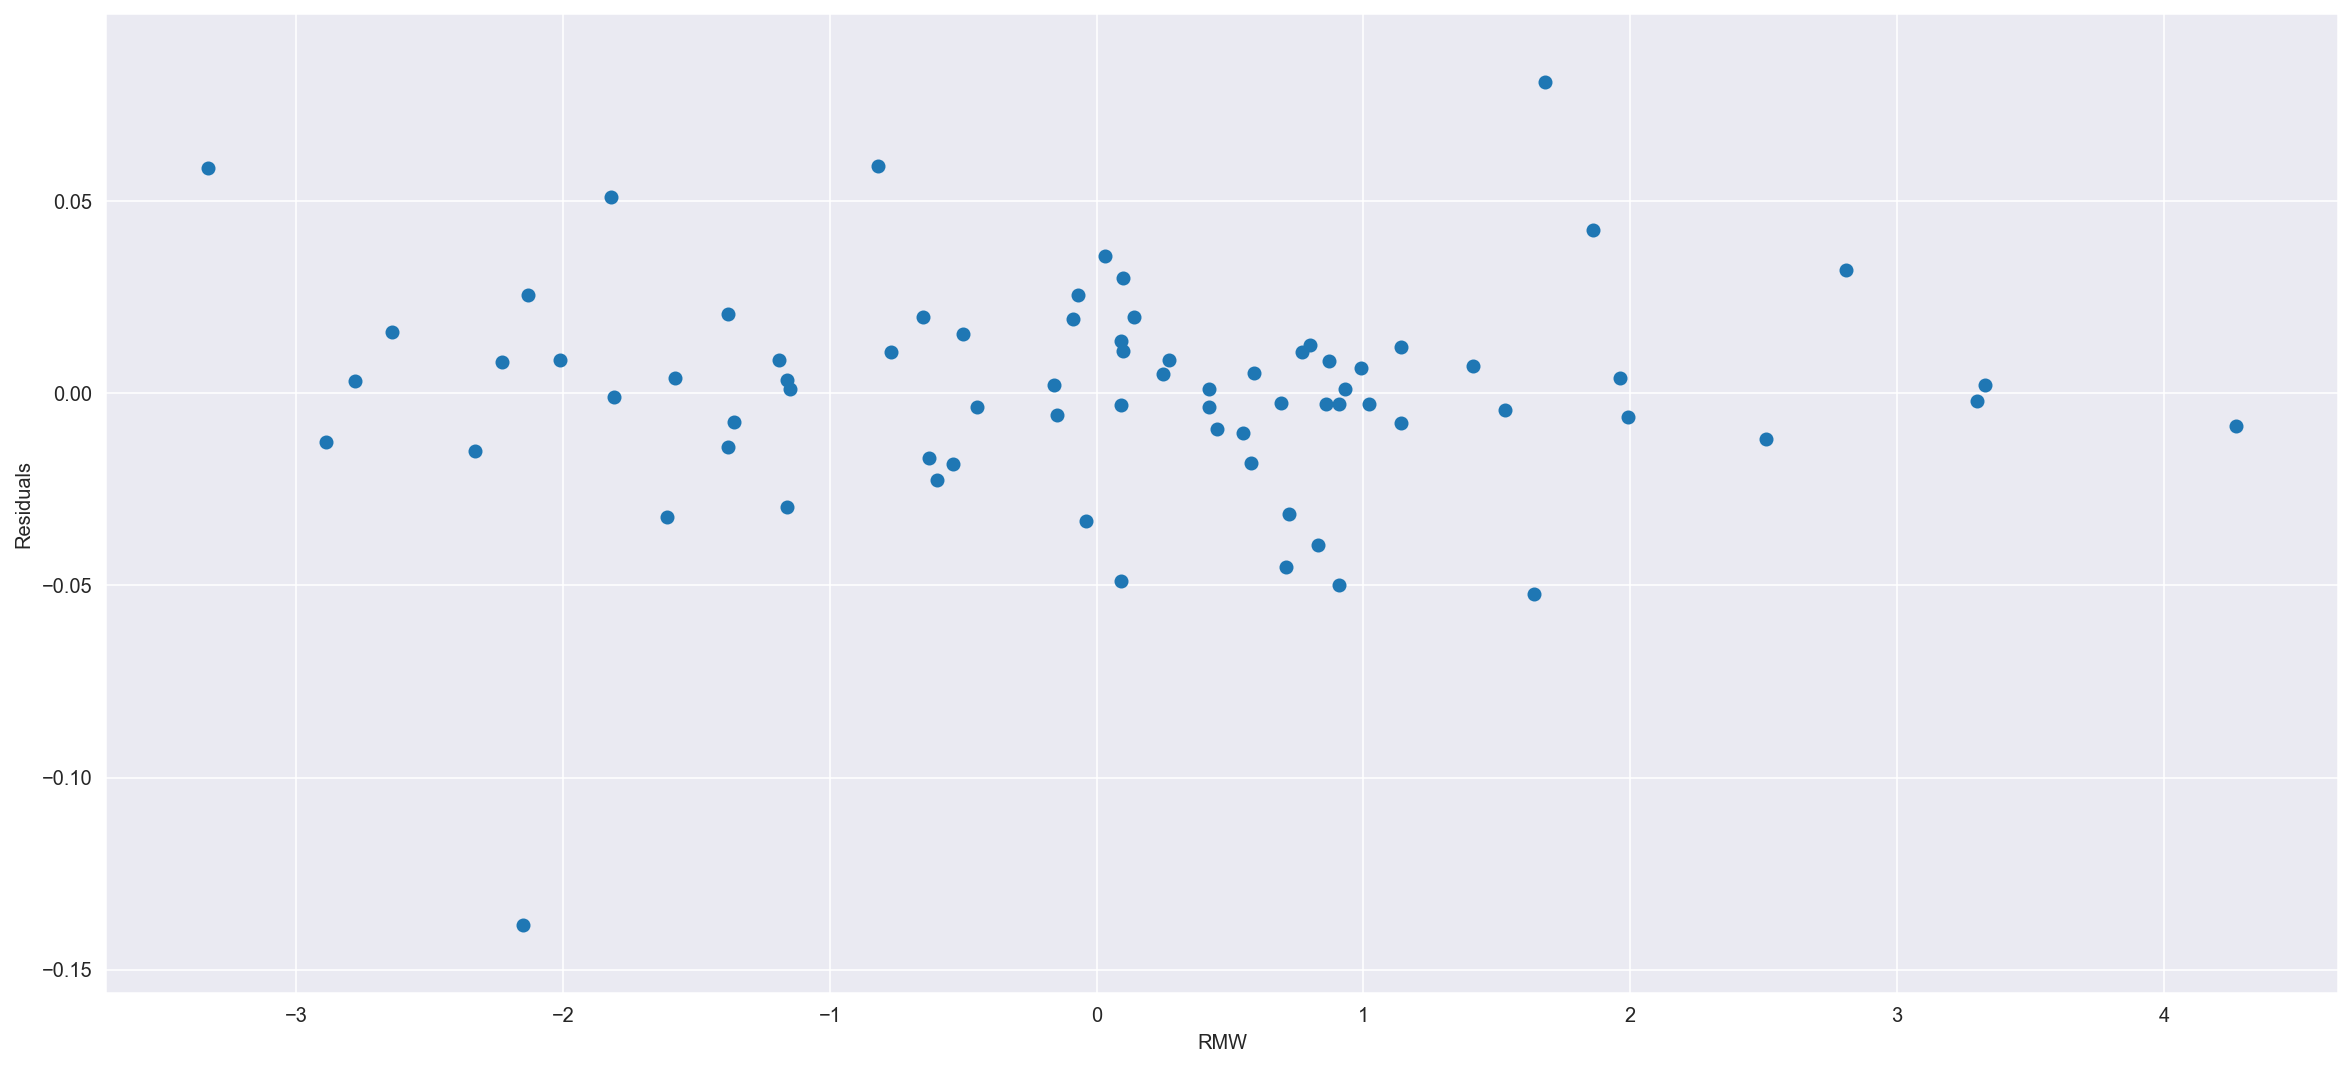

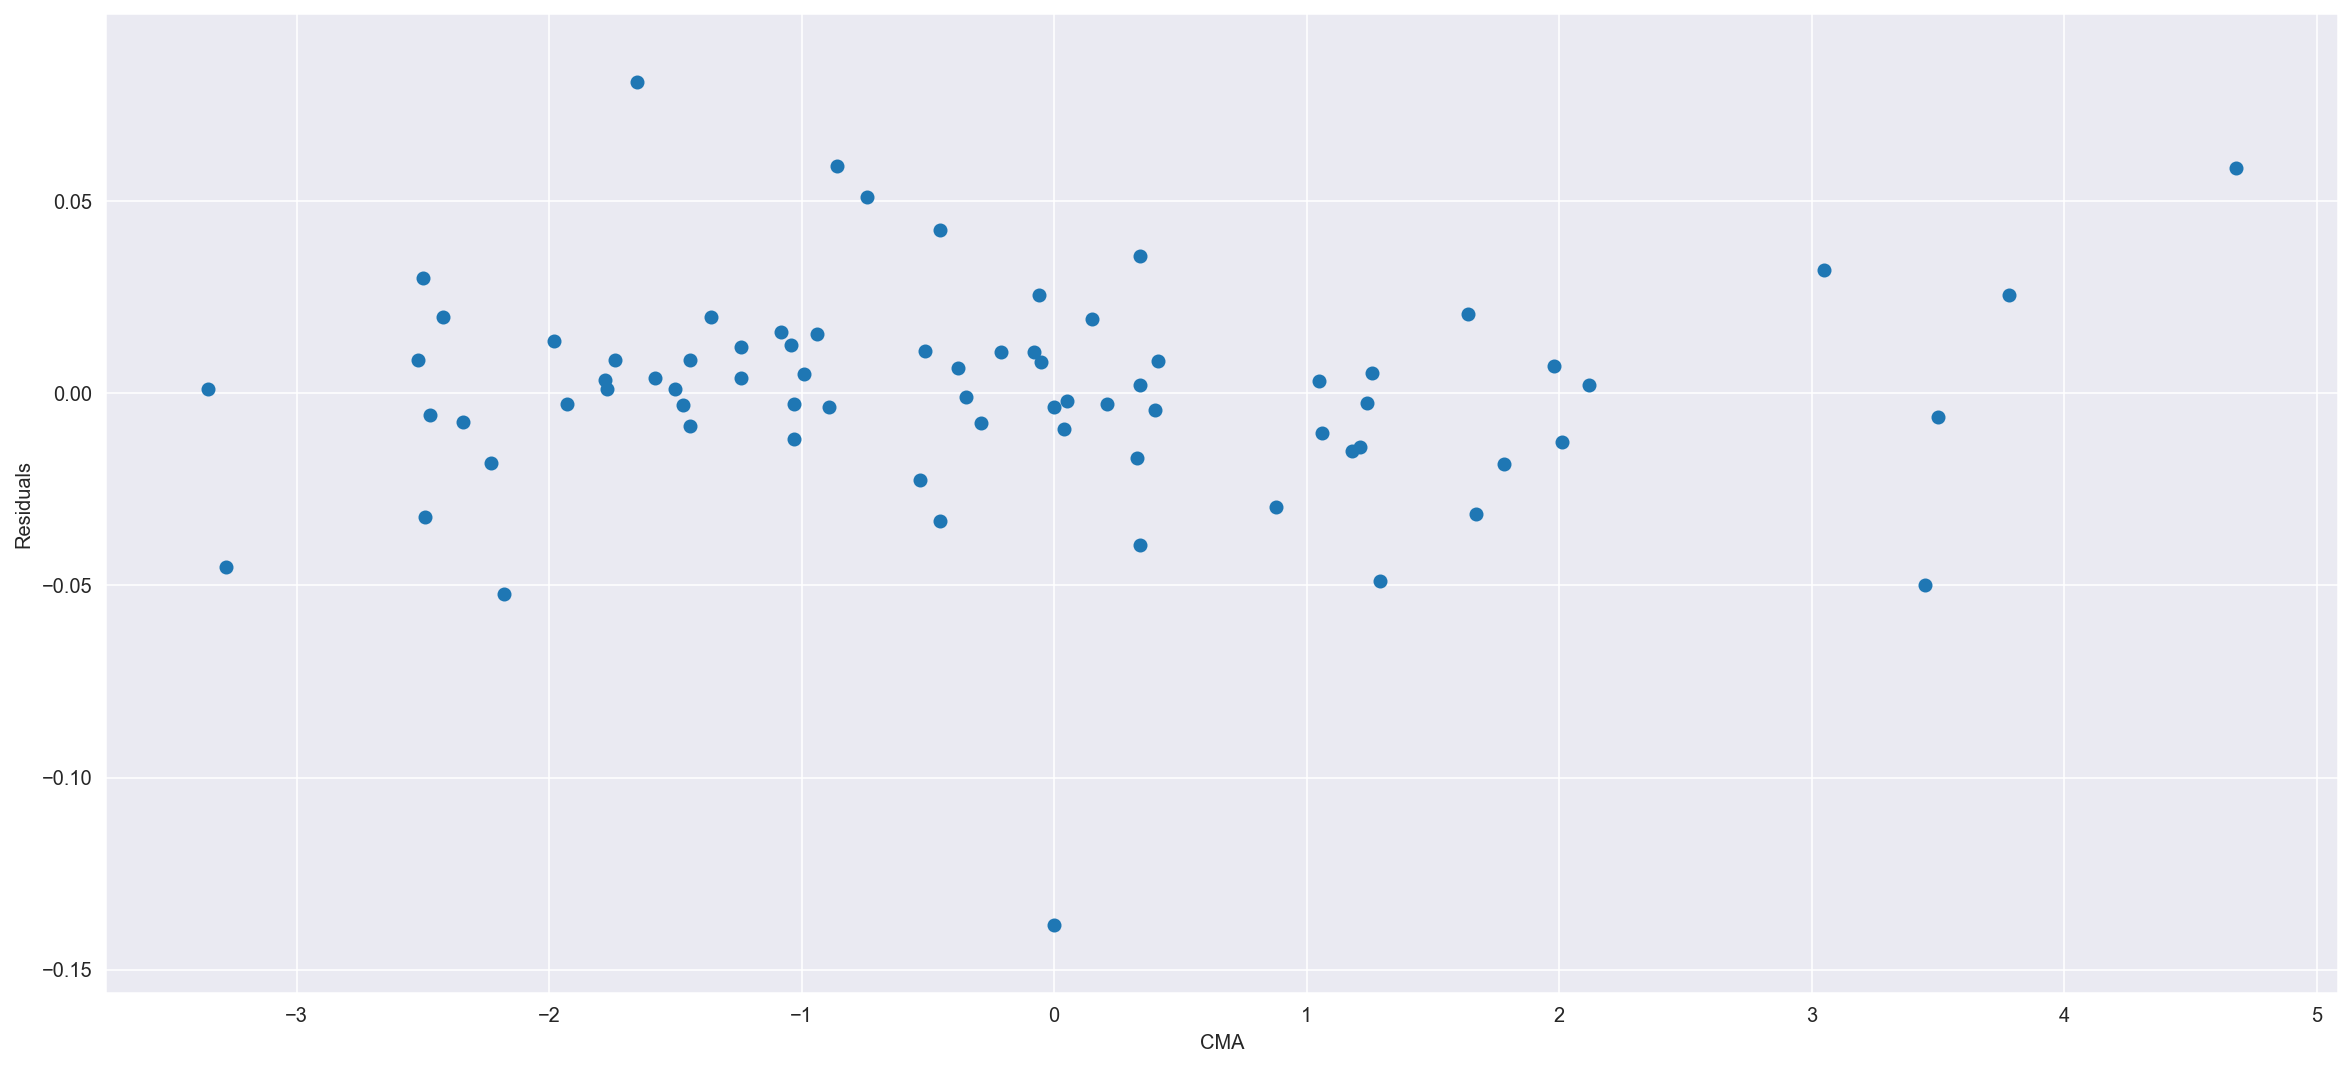

,residuals
MktRet,6.723815e-17
SMB,-6.763683e-17
HML,-2.192624e-17
RMW,8.045496e-18
CMA,1.256002e-16
residuals,1.000000e+00


In [24]:
attributes = FF5_m_2.columns
for att in attributes:
    plt.scatter(y = resid_m, x = FF5_m_2[att])
    plt.xlabel(att)
    plt.ylabel('Residuals')
    plt.show()
df = FF5_m_2.copy(deep=True)
df['residuals'] = resid_m
df.corr()[['residuals']]

In [25]:
from scipy.stats.stats import pearsonr
# Pearson correlation coefficient
def pearson_corr_test(X_with_cons, model_resid):
    print('Performing Pearson Correlation Test ...')
    for column in X_with_cons.columns[1:]:
        corr_test = pearsonr(X_with_cons[column], model_resid)
        print(f'{column} \n correlation: {corr_test[0]} \n p-value: {corr_test[1]}')
        if corr_test[1] < 0.05:
            print(" Rej null, conclude correlated.\n")
        else:
            print(' Fail to rej null, conclude non-correlated\n')

In [26]:
pearson_corr_test(X_m, resid_m)

Performing Pearson Correlation Test ...
MktRet 
 correlation: 5.398376808775549e-17 
 p-value: 1.0000000000000002
 Fail to rej null, conclude non-correlated

SMB 
 correlation: -3.5141904440853417e-17 
 p-value: 1.0000000000000002
 Fail to rej null, conclude non-correlated

HML 
 correlation: -5.3769541858344994e-17 
 p-value: 1.0000000000000002
 Fail to rej null, conclude non-correlated

RMW 
 correlation: -2.9527665419310685e-17 
 p-value: 1.0000000000000002
 Fail to rej null, conclude non-correlated

CMA 
 correlation: 1.900638594142051e-16 
 p-value: 0.9999999999999992
 Fail to rej null, conclude non-correlated



For both graphical and test approaches, we see that Strict exogeneity is satisfied. Residual mean is about zero, and the correlation between residuals and regressors are really small to zero. 

### IV.C) No Multicollinearity
There should be no linear relationship between the independent variables. 

- Looking at bivariate correlation. corr > 0.8 is an indicator of multicollinearity

Notes:

Here are more potential indicators of multicollinearity:

1. Very high standard errors for regression coefficients
When standard errors are orders of magnitude higher than their coefficients, that’s an indicator.

2. The overall model is significant, but none of the coefficients are
Remember that a p-value for a coefficient tests whether the unique effect of that predictor on Y
is zero. If all predictors overlap in what they measure, there is little unique effect, even if 
the predictors as a group have an effect on Y.

3. Large changes in coefficients when adding predictors
If the predictors are completely independent of each other, their coefficients won’t change at 
all when you add or remove one. But the more they overlap, the more drastically their 
coefficients will change.

4. Coefficients have signs opposite what you’d expect from theory
Be careful here as you don’t want to disregard an unexpected finding as problematic. Not all 
effects opposite theory indicate a problem with the model. That said, it could be 
multicollinearity and warrants taking a second look at other indicators.

5. Coefficients on different samples are wildly different
If you have a large enough sample, split the sample in half and run the model separately on 
each half. Wildly different coefficients in the two models could be a sign of multicollinearity.

6. High Variance Inflation Factor (VIF) and Low Tolerance
These two useful statistics are reciprocals of each other. So either a high VIF or a low 
tolerance is indicative of multicollinearity. VIF is a direct measure of how much the variance 
of the coefficient (ie. its standard error) is being inflated due to multicollinearity. the square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. If no features are correlated, then all values for VIF will be 1. To deal with multicollinearity we should iteratively remove features with high values of VIF. A rule of thumb for removal could be VIF larger than 10 (5 is also common). Another possible solution is to use PCA to reduce features to a smaller set of uncorrelated components.

7. High Condition Indices
Condition indices are a bit strange.  The basic idea is to run a Principal Components Analysis 
on all predictors. If they have a lot of shared information, the first Principal Component 
will be much higher than the last. Their ratio, the Condition Index, will be high if 
multicollinearity is present.

In [27]:
# bivariate correlation
FF5_m_2.corr()

,MktRet,SMB,HML,RMW,CMA
MktRet,1.000000,0.393864,0.192458,0.070688,-0.184678
SMB,0.393864,1.000000,0.458916,-0.336846,0.124623
HML,0.192458,0.458916,1.000000,0.007708,0.457051
RMW,0.070688,-0.336846,0.007708,1.000000,-0.033850
CMA,-0.184678,0.124623,0.457051,-0.033850,1.000000


In [28]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def VIF_test(X_constant_added):
    vif = [variance_inflation_factor(X_constant_added.values, i) for i in range(X_constant_added.shape[1])]
    VIF_df = pd.DataFrame({'vif': vif}, index=X_constant_added.columns).T
    VIF_df = VIF_df[VIF_df.columns[1:]]
    return VIF_df
VIF_test(X_m)

,MktRet,SMB,HML,RMW,CMA
vif,1.363003,1.784255,1.689486,1.242304,1.401449


No Multicollinearity is satisfied. (Indicator of strong Multicollinearity: corr > 0.8, VIF >5)

### IV.D) Spherical error variance
There is homoscedasticity and no autocorrelation.

- The error terms in the regression should all have the same variance.
    (Heteroscedastic errors: error variance is not constant, i.e. depend on Xs.)
- The error terms of different observations should not be correlated with each other, i.e.error terms should be IID (Independent and Identically Distributed).

When we have time series data, then the regression is likely to suffer from autocorrelation because data next year will most likely be dependent on data this year. Hence, error terms in different observations will surely be correlated with each other.

Check for autocorrelation by viewing the residual time series plot. If autocorrelation is present in the model, we can try taking lags of independent variables to correct for the trend component. If you do not correct for autocorrelation, then OLS estimates won’t be BLUE, and they won’t be reliable enough.

We can also use two statistical tests: **Breusch-Pagan** and **Goldfeld-Quandt**. In both of them, the null hypothesis **H0** assumes homoscedasticity:

p-value <0.05 : reject the null, conclude heteroscedasticity.

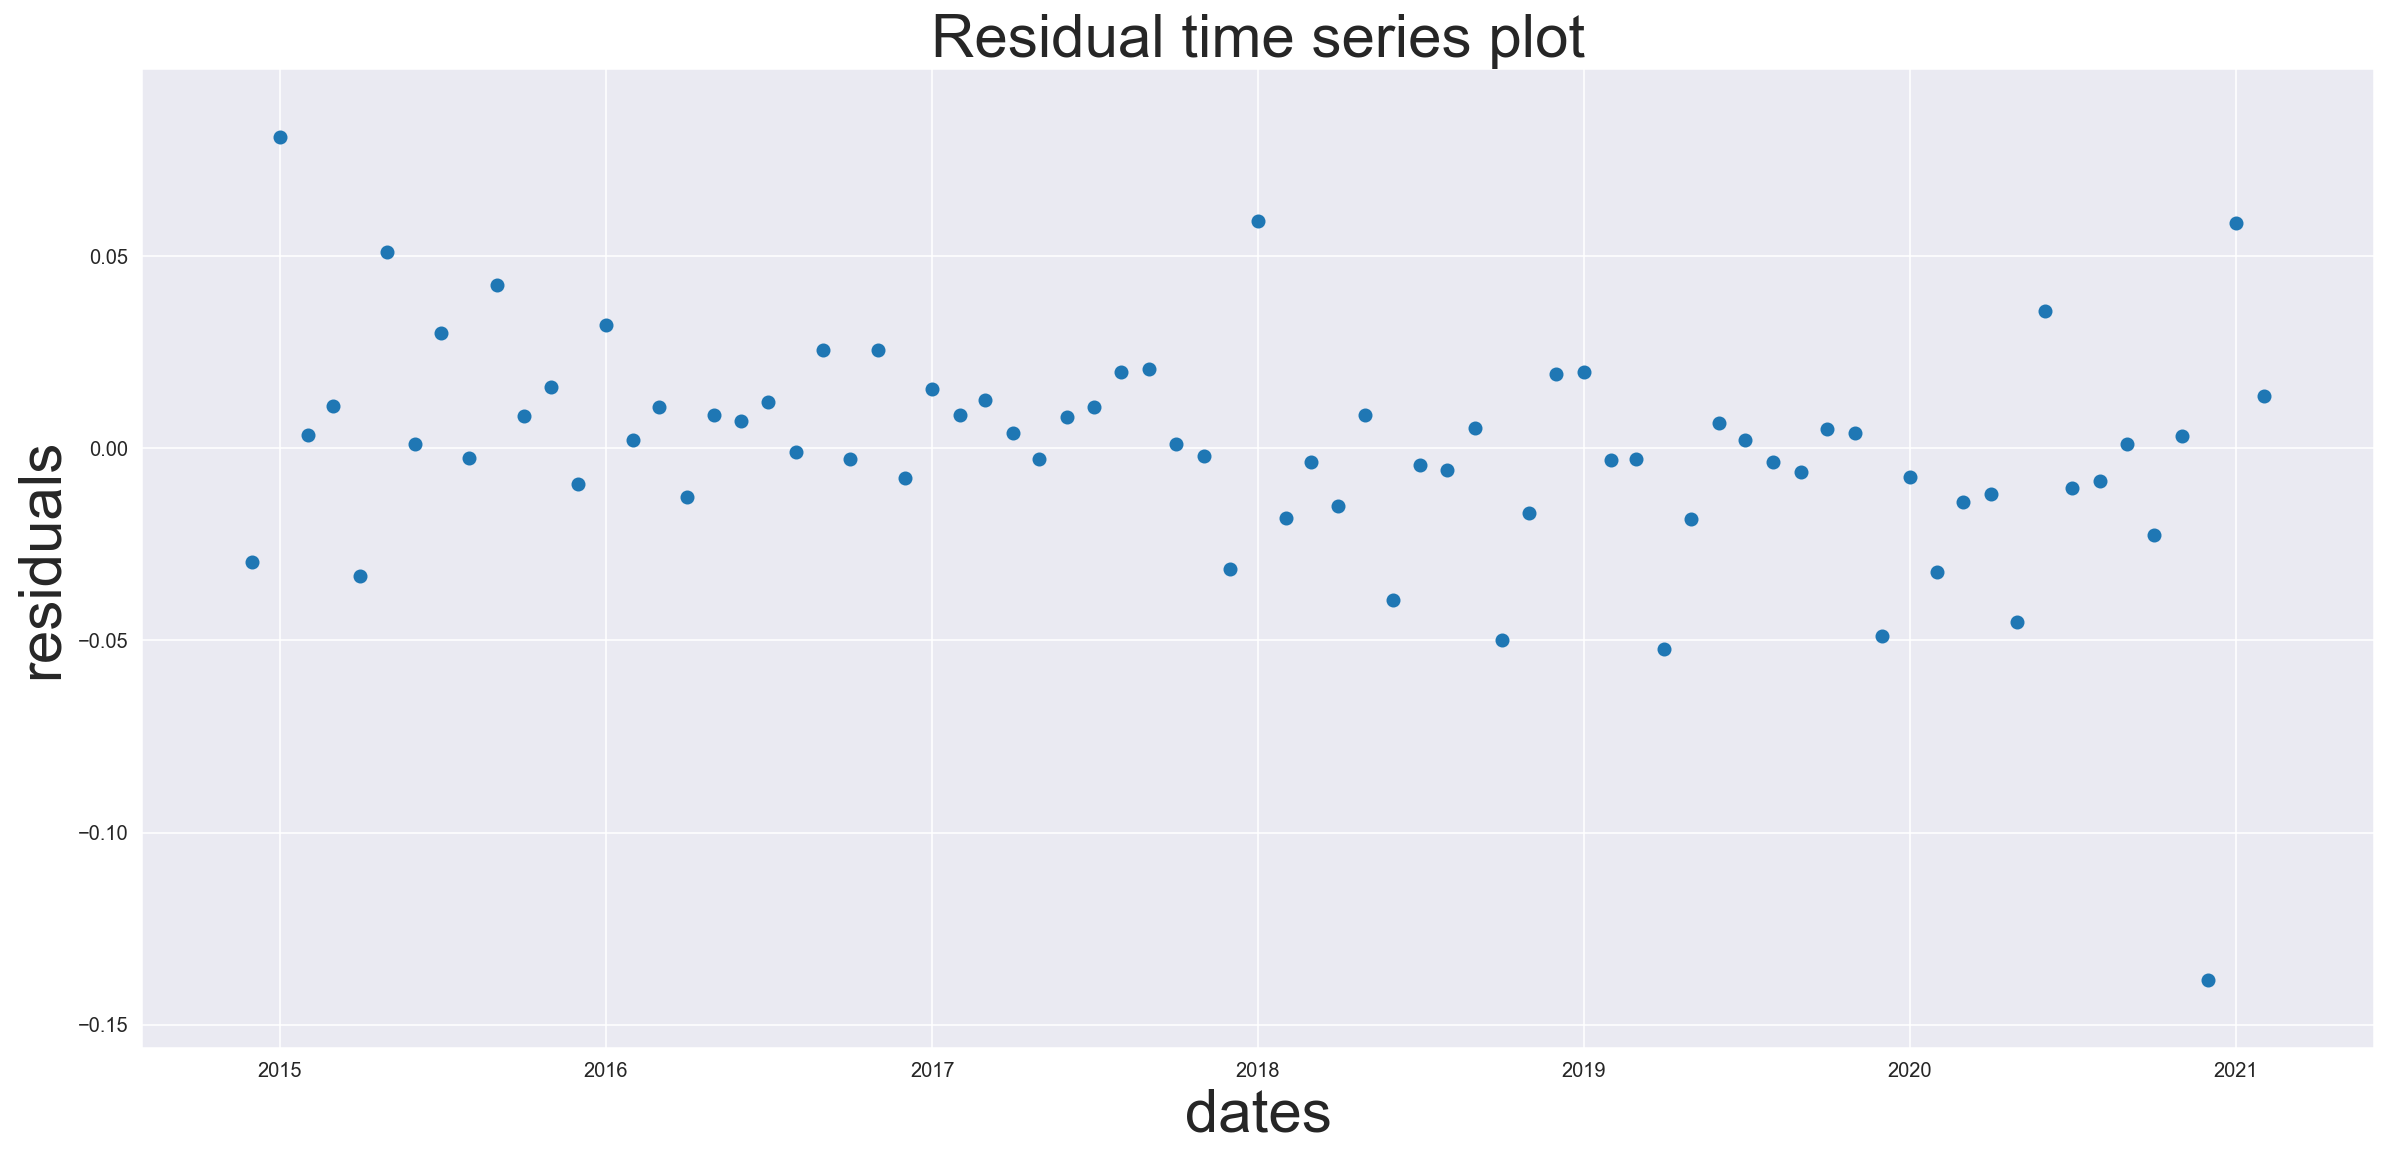

In [29]:
# to see constant variance of error terms
plt.scatter(y = resid_m, x = FF5_m_2.index)
plt.title('Residual time series plot', fontsize = 30)
plt.ylabel('residuals', fontsize = 30)
plt.xlabel('dates', fontsize = 30)
plt.show()

In [30]:
def homoscedasticity_test(model):
    ''' Testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args
    ----------
    model: fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Standardized Residuals vd Fitted', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog,), 
                           columns=['value'], 
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog, alternative="two-sided")[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])
    def conclude(score):
        if score < 0.05:
            print('Reject Null, conclude heteroscedasticity')
        else:
            print('Fail to Reject Null, conclude homoscedasticity')
            
    print('\n---- Breusch-Pagan test ----')
    print(bp_test)
    conclude(bp_test.loc['f p-value'].values)
    print('\n---- Goldfeld-Quandt test ----')
    print(gq_test)
    conclude(gq_test.loc['p-value'].values)
    print('\n---- Residuals plots ----')


---- Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  3.520611
p-value                        0.620271
f-value                        0.679698
f p-value                      0.640294
Fail to Reject Null, conclude homoscedasticity

---- Goldfeld-Quandt test ----
                value
F statistic  2.536846
p-value      0.011107
Reject Null, conclude heteroscedasticity

---- Residuals plots ----


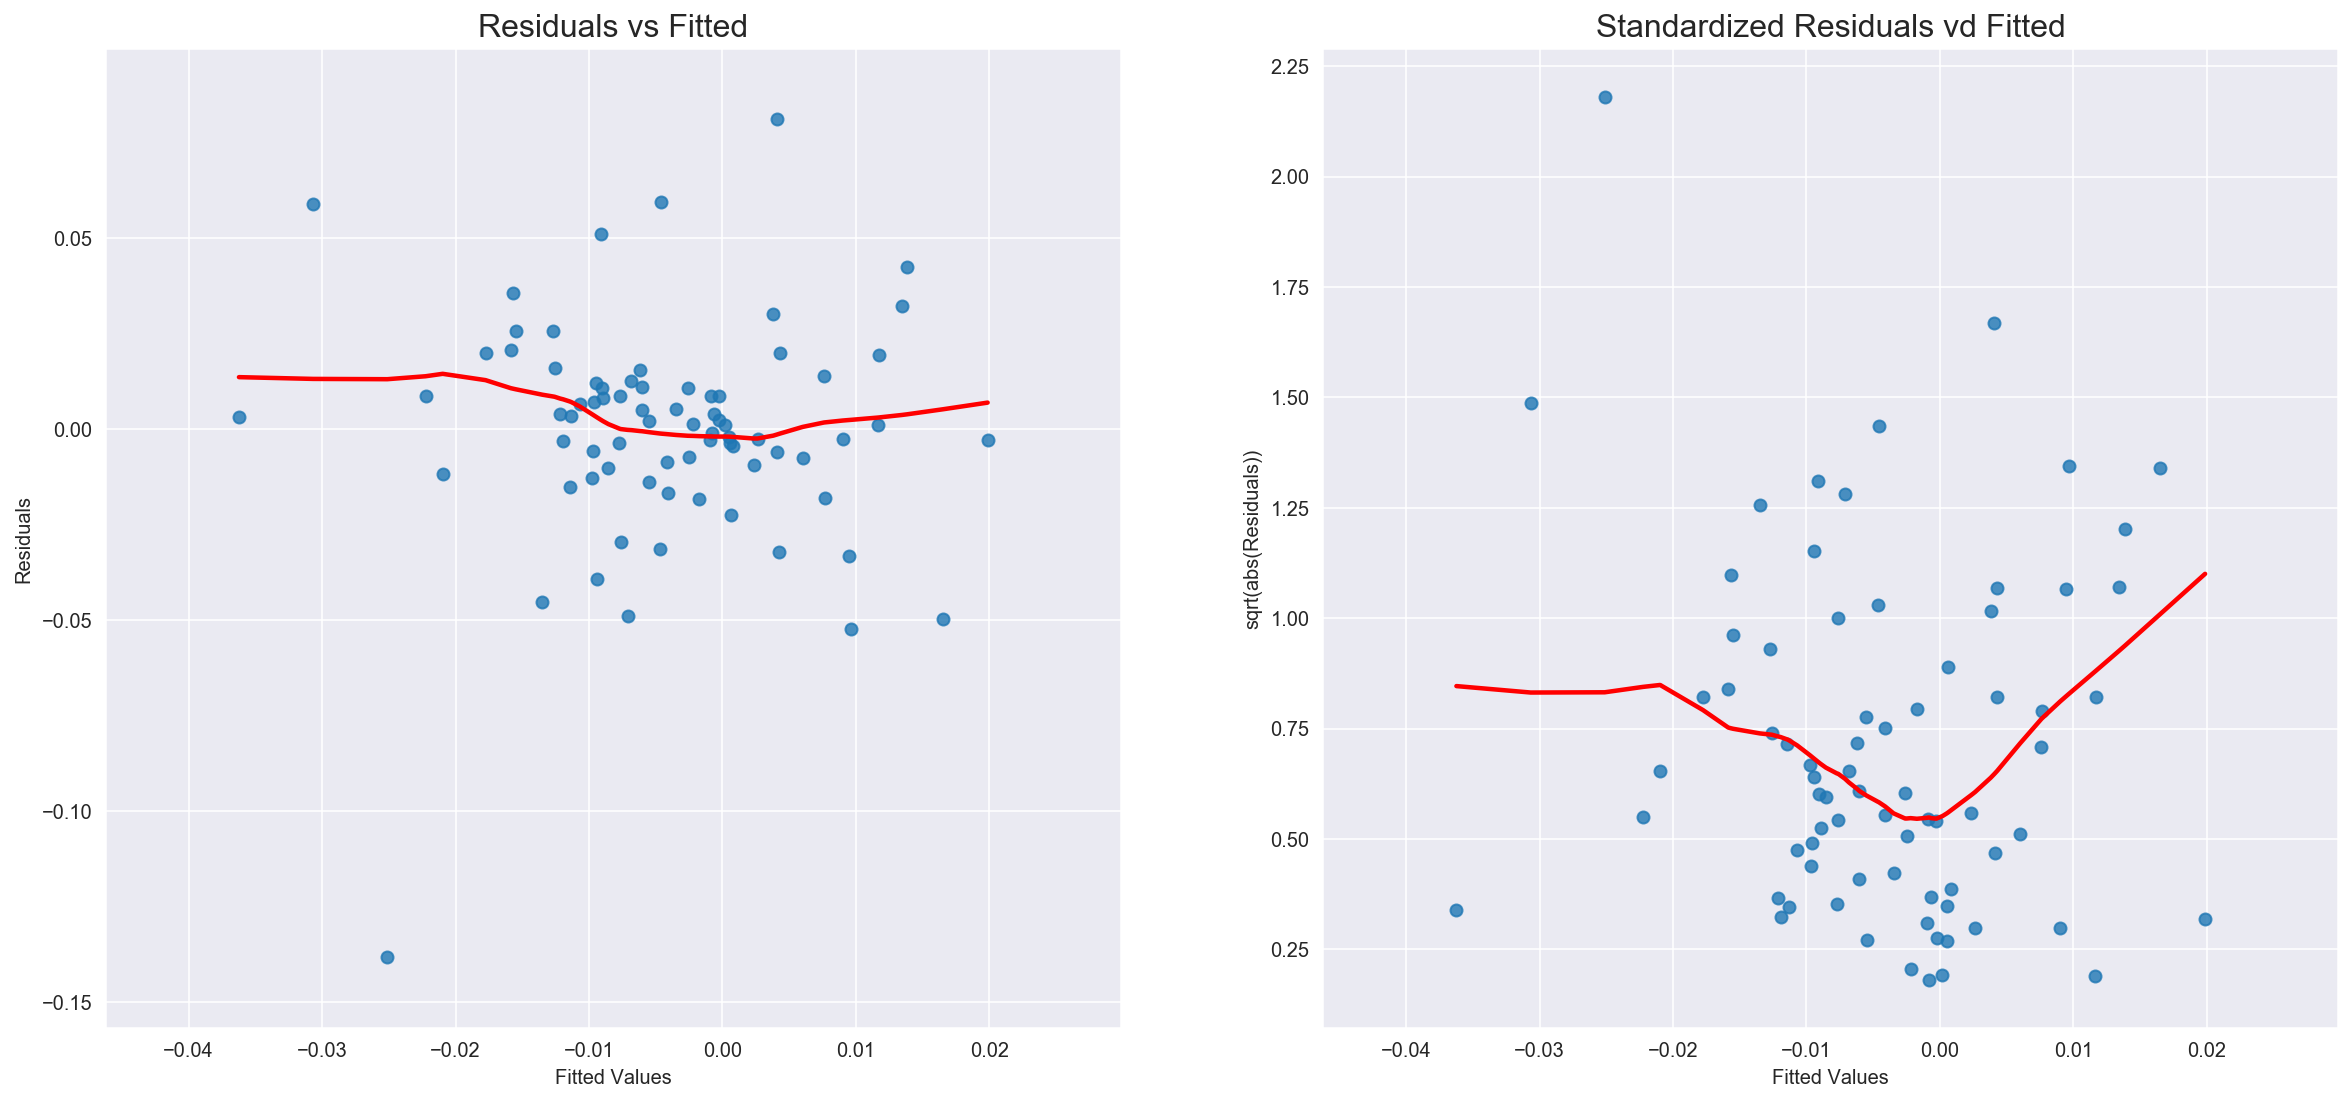

In [31]:
homoscedasticity_test(result_m)

In [32]:
# check autocorrelation of error terms
# check autocorrelation of error terms
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
def autocorrelation_test(rds):
    durbinWatson = durbin_watson(rds)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')
    plot_acf(rds, lags = 15)
    plt.show()

Durbin-Watson: 2.4070607283279104
Little to no autocorrelation 

Assumption satisfied


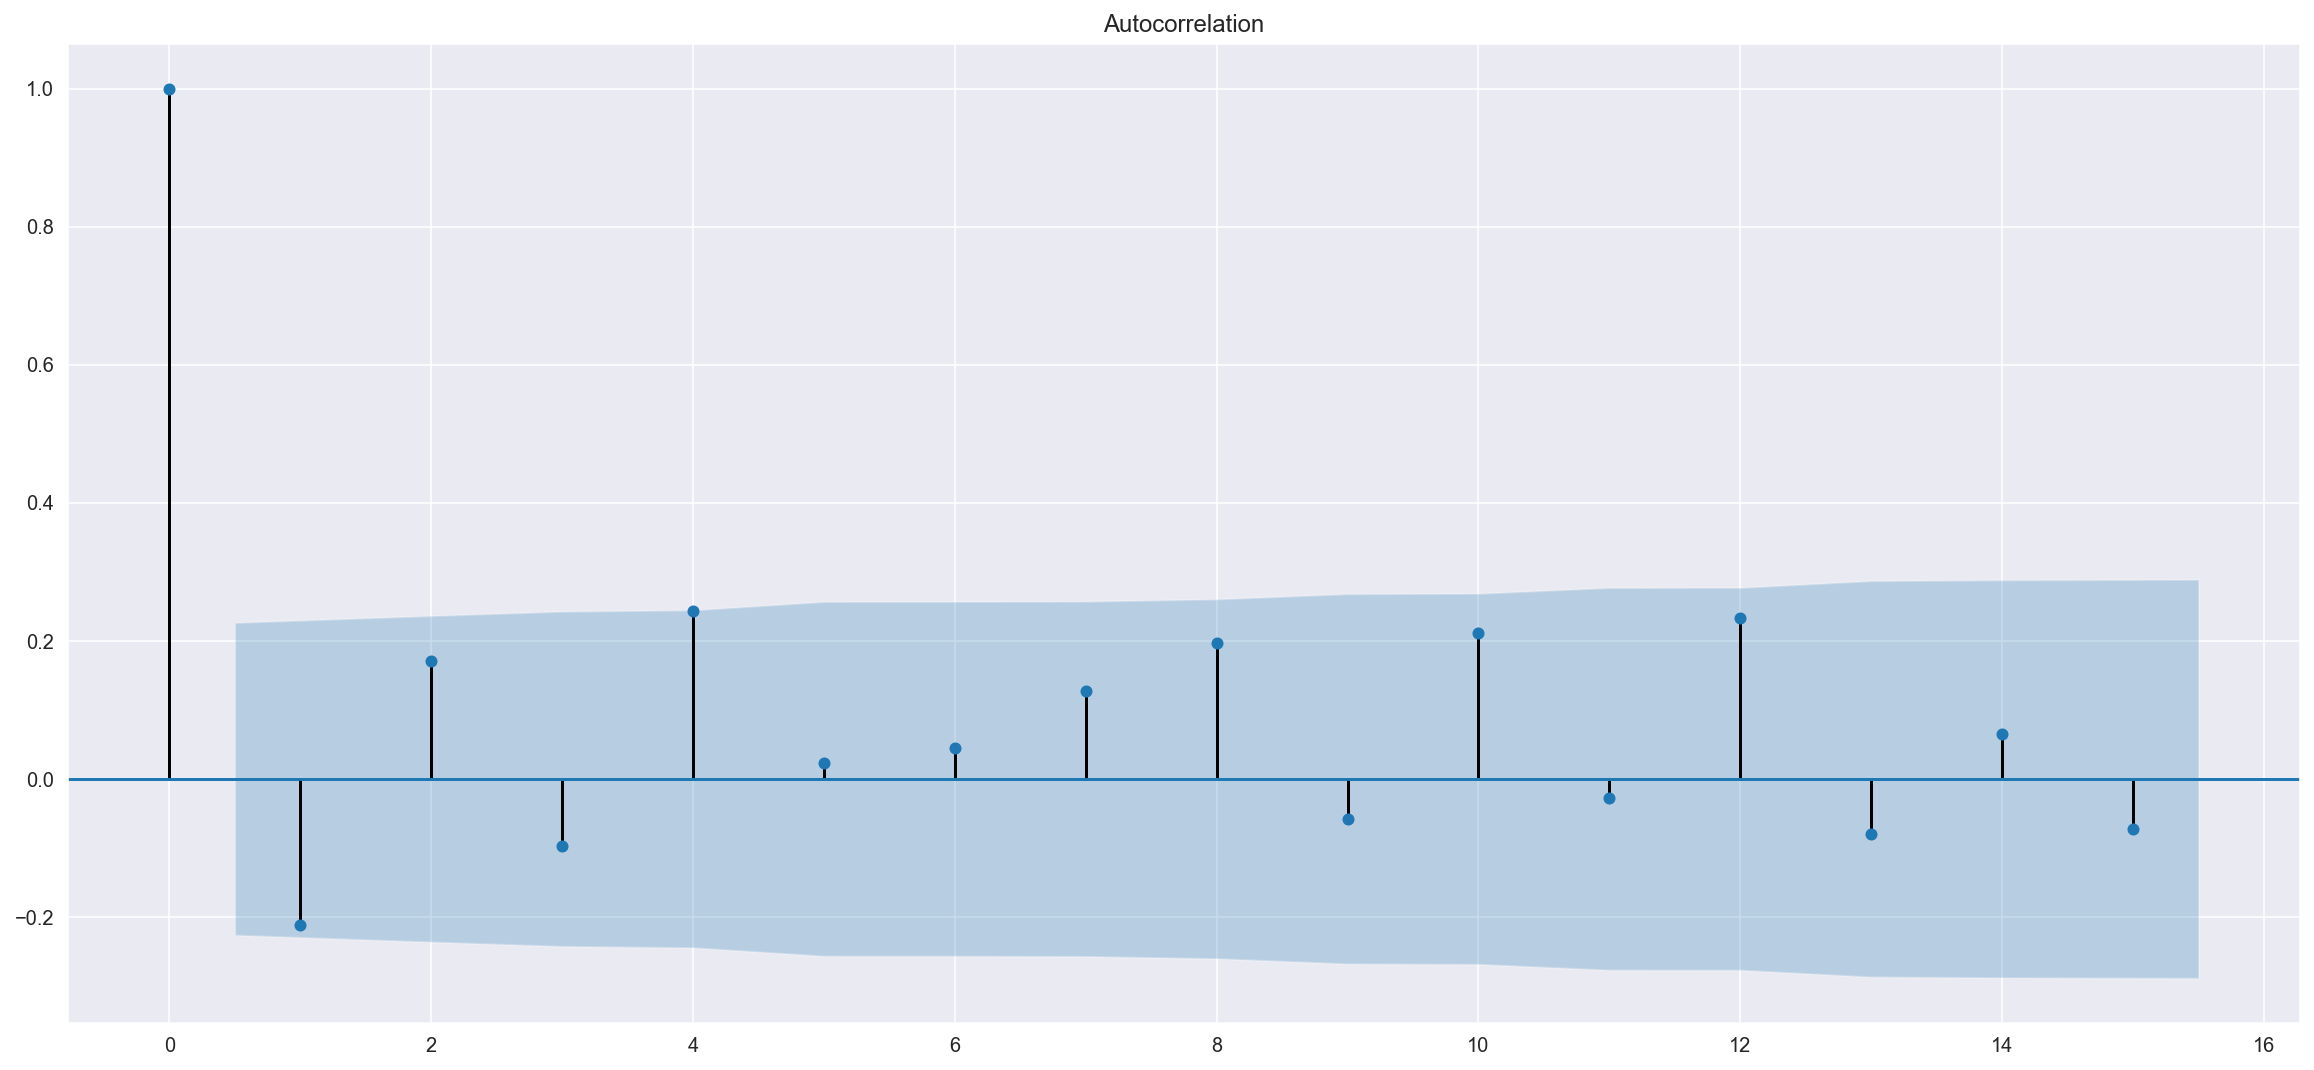

In [33]:
autocorrelation_test(resid_m)

Spherical error variance is sort of satisfied since we see a roughtly constant residual variance over time, and there is no strong evidence of autocorrelation of residuals.

### IV.E) Normality:

In [34]:
print(f'residual mean: {resid_m.mean()}')
print(f'residual std: {resid_m.std()}')
s = pd.DataFrame(np.random.normal(resid_m.mean(), resid_m.std(), len(resid_m)))
print(f'skewness: \n   residual: {resid_m.skew()} \n   normal: {s[0].skew()}')
print(f'kurtosis: \n   residual: {resid_m.kurtosis()} \n   normal: {s[0].kurtosis()}')

residual mean: 1.1564823173178714e-19
residual std: 0.02917965566726079
skewness: 
   residual: -1.1192312248841199 
   normal: 0.3180937577575859
kurtosis: 
   residual: 6.557454221134119 
   normal: -0.8731719322931557


Non-normal


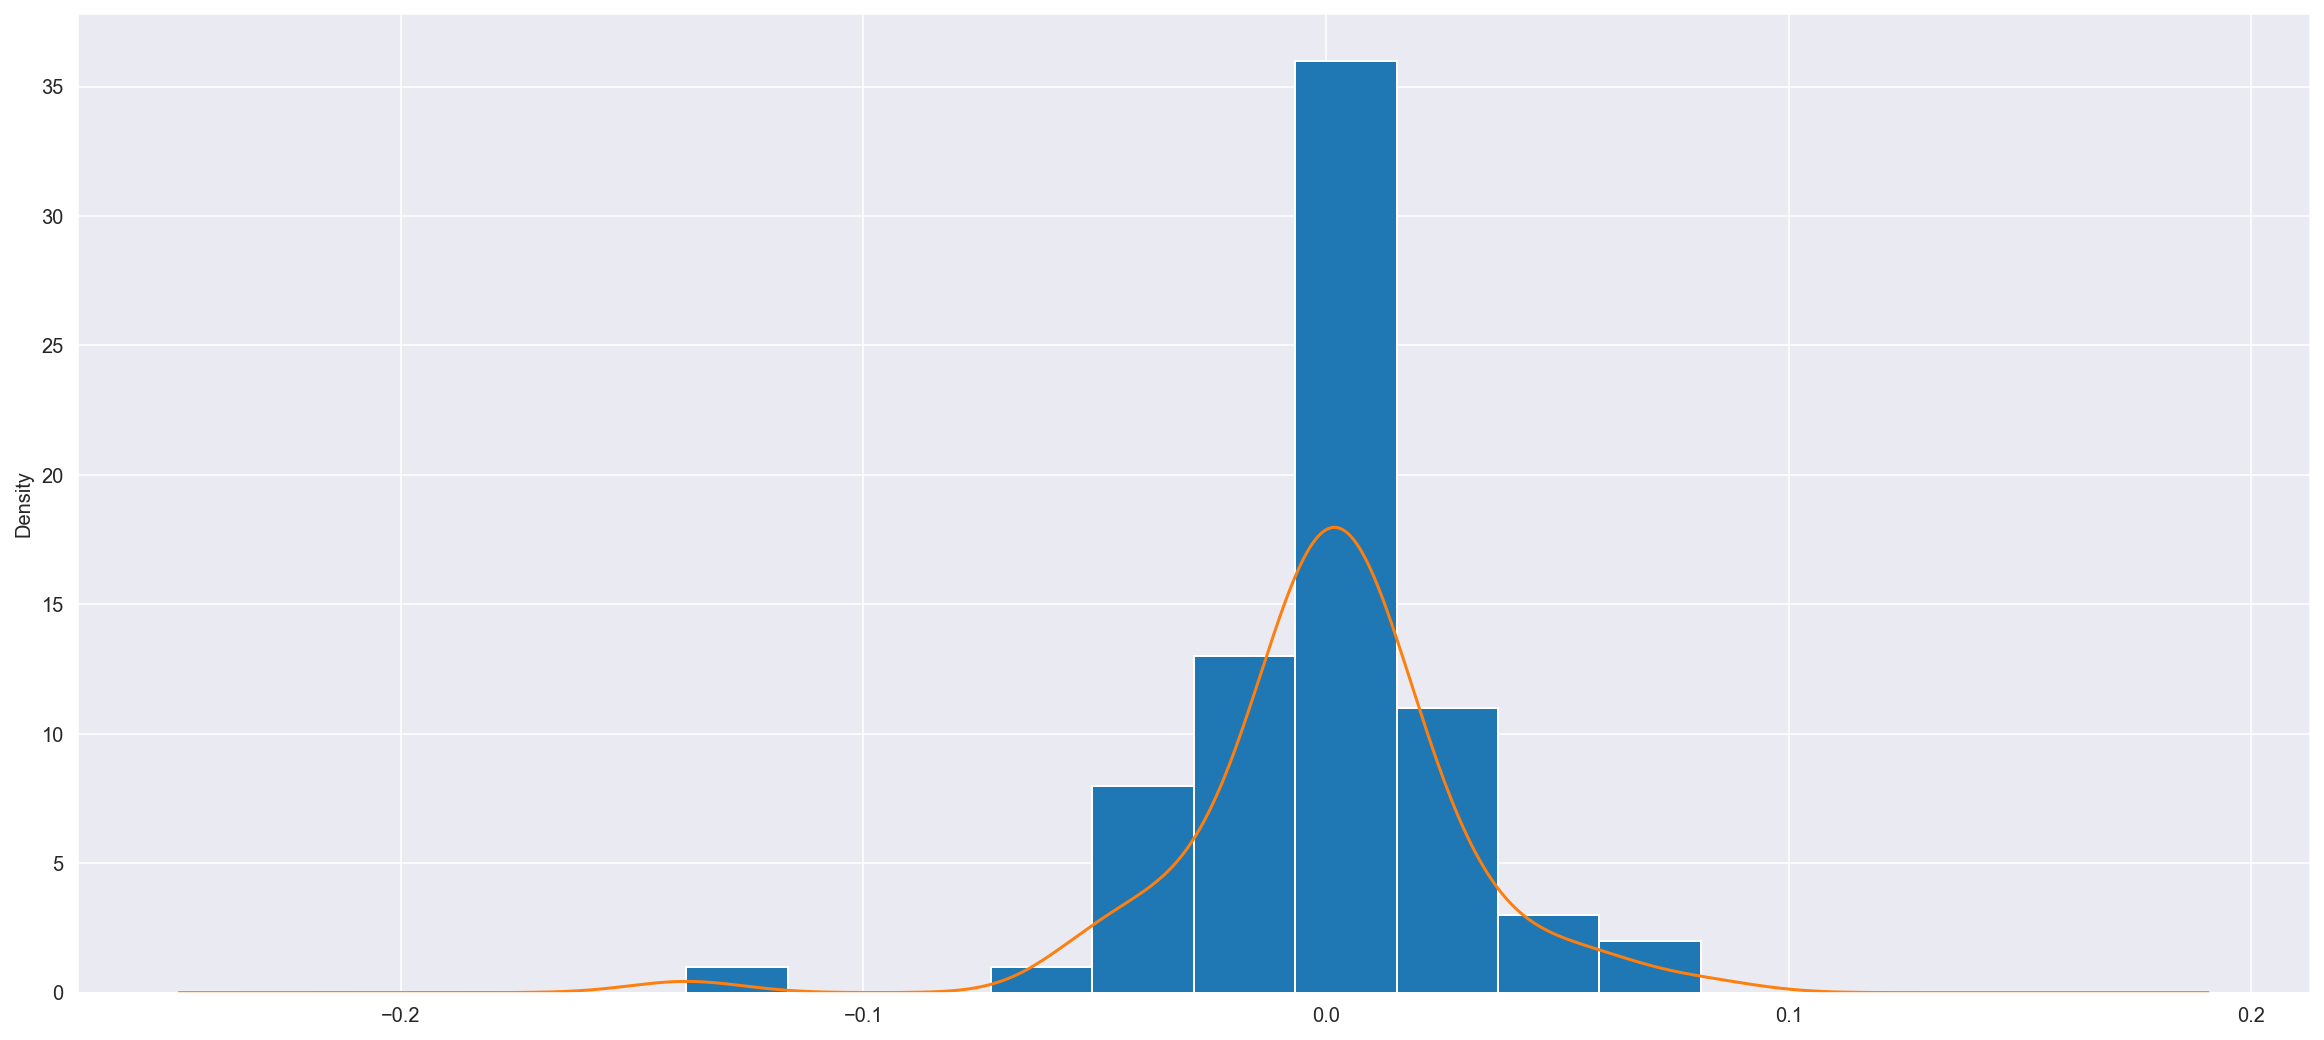

In [35]:
from statsmodels.stats.diagnostic import normal_ad
def normality_test(series):
    pva = normal_ad(series)[1]
    if pva<0.05:
        print('Non-normal')
    else:
        print('Normal')
    series.hist()
    series.plot(kind='kde')
    plt.show()
normality_test(resid_m)

Through the graph, we can see it is roughly Normal. However, with the same mean and std, residuals has skewness and kurotosis that are far away from those for a Normal distribution. There, we conclude that Normal assumption is not satisfied. The residual probably has fat tails.

### Financial/economic interpretation
Don't think monthly data give me a deep insight of the relationship between market and AQR. See Daily Data exploration below with more explaination:)

----------------------------
## PART TWO: Analysis on 10 Industry Portfolios Model

### Datasets
**Portfolio10**:
- Monthly data of the [10 Industry Portfolio model](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_10_ind_port.html)
- [Ken French data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
- 1926-07 to 2021-02

**AQR**:
- same as above, monthly returns

### Goal:
Repeat the analysis again, to explore the relationship between AQR returns and different industries.

### I. Data Gathering:

In [36]:
portfolio10_m = web.DataReader('10_Industry_Portfolios', 'famafrench', start = '1925-01-01', end = '2021-02-01')[0].to_timestamp()
portfolio10_m

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07-01,1.45,15.55,4.69,-1.18,2.90,0.83,0.11,1.77,7.04,2.16
1926-08-01,3.97,3.68,2.81,3.47,2.66,2.17,-0.71,4.25,-1.69,4.38
1926-09-01,1.14,4.80,1.15,-3.39,-0.38,2.41,0.21,0.69,2.04,0.29
1926-10-01,-1.24,-8.23,-3.63,-0.78,-4.58,-0.11,-2.29,-0.57,-2.63,-2.85
1926-11-01,5.20,-0.19,4.10,0.01,4.71,1.63,6.43,5.42,3.71,2.11
...,...,...,...,...,...,...,...,...,...,...
2020-10-01,-2.61,-3.17,-0.77,-4.53,-1.88,-3.90,-2.53,-4.29,4.49,-2.03
2020-11-01,10.02,33.99,13.87,28.60,11.02,14.44,8.39,9.63,2.63,15.69
2020-12-01,4.90,15.43,2.53,6.20,5.00,5.29,1.49,4.70,0.63,5.20


In [37]:
print(f"Portfolio monthly:{portfolio10_m.shape}")
print(f"missing values: {portfolio10_m.isnull().any().sum()}")
b4, e4 = portfolio10_m.index[0], portfolio10_m.index[-1]
print(f"Starting from {str(b4)[:10]} to {str(e4)[:10]}")

Portfolio monthly:(1136, 10)
missing values: 0
Starting from 1926-07-01 to 2021-02-01


In [38]:
start3 = max(b4, b3)
end3 = min(e4, e3)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start3)[:7])
print('end_date: ', str(end3)[:7])
portfolio10_m_3 = portfolio10_m.loc[start3:end3]
AQR_m_3 = AQR_m.loc[start3:end3]

portfolio_all_m = pd.merge(AQR_m_3, portfolio10_m_3, left_index=True, right_index=True)
print(portfolio_all_m.shape)
portfolio_all_m

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-12
end_date:  2021-02
(75, 11)


,Return,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,,
2014-12-01,-0.037259,-2.36,0.58,-0.18,0.41,-1.28,-1.74,1.59,-0.88,1.85,1.13
2015-01-01,0.085110,-0.55,-4.19,-3.86,-4.37,-3.29,-4.90,-0.30,1.56,1.18,-6.12
2015-02-01,-0.007797,5.03,8.08,6.23,4.82,8.28,9.10,5.56,4.31,-4.37,6.86
2015-03-01,0.004880,-2.43,-0.40,-2.02,-2.67,-2.45,-2.21,0.70,0.84,-0.28,-0.75
2015-04-01,-0.023646,0.81,-0.93,-0.63,6.97,1.34,3.40,-2.18,-1.40,0.30,0.51
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,-0.021894,-2.61,-3.17,-0.77,-4.53,-1.88,-3.90,-2.53,-4.29,4.49,-2.03
2020-11-01,-0.033094,10.02,33.99,13.87,28.60,11.02,14.44,8.39,9.63,2.63,15.69
2020-12-01,-0.163390,4.90,15.43,2.53,6.20,5.00,5.29,1.49,4.70,0.63,5.20


### II. Regression:
** 10 Industry Portfolio Model**

$$ \text{AQR Return}_i = b_0 + b_1*\text{NoDur}_i + b_2*\text{Durbl}_i + b_3*\text{Manuf}_i + b_4*\text{Enrgy}_i + b_5*\text{HiTec}_i$$
$$ + b_6*\text{Telcm}_i + b_7*\text{Shops}_i + b_8*\text{Hlth}_i + b_9*\text{Utils}_i + b_{10}*\text{Other}_i + \epsilon_i $$


In [39]:
# regressors: 10 Factors
X_portfolio_m = portfolio_all_m[portfolio_all_m.columns[1:]]   
# response variable: Returns of QMNIX Monthly
y_portfolio_m = portfolio_all_m[['Return']]

In [40]:
# Running OLS model:
import statsmodels.api as sm
X_portfolio_m = sm.add_constant(X_portfolio_m)
model_p_m = sm.OLS(y_portfolio_m, X_portfolio_m, missing='raise')
result_p_m = model_p_m.fit()

tstat_p_m = result_p_m.tvalues
coeff_p_m = result_p_m.params
fitted_p_m = result_p_m.fittedvalues
resid_p_m = result_p_m.resid
result_p_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.299
Date:                Fri, 16 Apr 2021   Prob (F-statistic):              0.250
Time:                        01:14:07   Log-Likelihood:                 161.67
No. Observations:                  75   AIC:                            -301.3
Df Residuals:                      64   BIC:                            -275.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.004     -0.914      0.364      -0.011       0.004
NoDur         -0.0002      0.002     -0.078      0.938      -0.004       0.004
Durbl         -0.0012      0.001     -1.951      0.055      -0.002    2.86e-05
Manuf          0.0030      0.002      1.355      0.180      -0.001       0.007
Enrgy         -0.0001      0.001     -0.174      0.862      -0.001       0.001
HiTec       9.606e-05      0.002      0.064      0.949      -0.003       0.003
Telcm         -0.0029      0.002     -1.781      0.080      -0.006       0.000
Shops          0.0020      0.002      1.205      0.233      -0.001       0.005
Hlth          -0.0010      0.001     -0.765      0.447      -0.004       0.002
Utils         -0.0001      0.001     -0.115      0.909      -0.003       0.002
Other         -0.0005      0.002     -0.269      0.789      -0.005       0.003
==============================================================================
Omnibus:                       24.026   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.654
Skew:                          -0.840   Prob(JB):                     1.13e-18
Kurtosis:                       7.861   Cond. No.                         17.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpret:
**t-test**: in the table, for each t-test, it means given other coefs are statistically significant
- H_0: not significant. 
- H_a: the coef is significant.
- p < 0.05, reject null, conclude significance.

Therefore, given all others are significant, no individual coefficient is statistically significant. All p-values are > 0.05.

**F-test**: in the table, for the F-stats, it means the overall model evaluation.
- H_0: our model does not explain the variance any better than the intercept only model. we want the intercept only model.
- H_a: our model is better than the intercept only one.
- Prob (F-statistic) is just the p-value of this test. If Prob (F-statistic) < 0.05, reject null, conclude our model is good.

Therefore, p-value = 0.25 > 0.05 and we fail to reject null, and we need to conclude that our model is not outperformed the intercept only model.

**$R^2$**: the percentage of variance explained by our model factors.

0.169 means the model is not great with explaining return variance. But better than 5 factor model (0.111).

**Intercept**: from t-test above, we conclude that, given other coefs are statistically significant, the intercept is not statistically significant.

### III. OLS Assumptions check

##### Test Linearity:

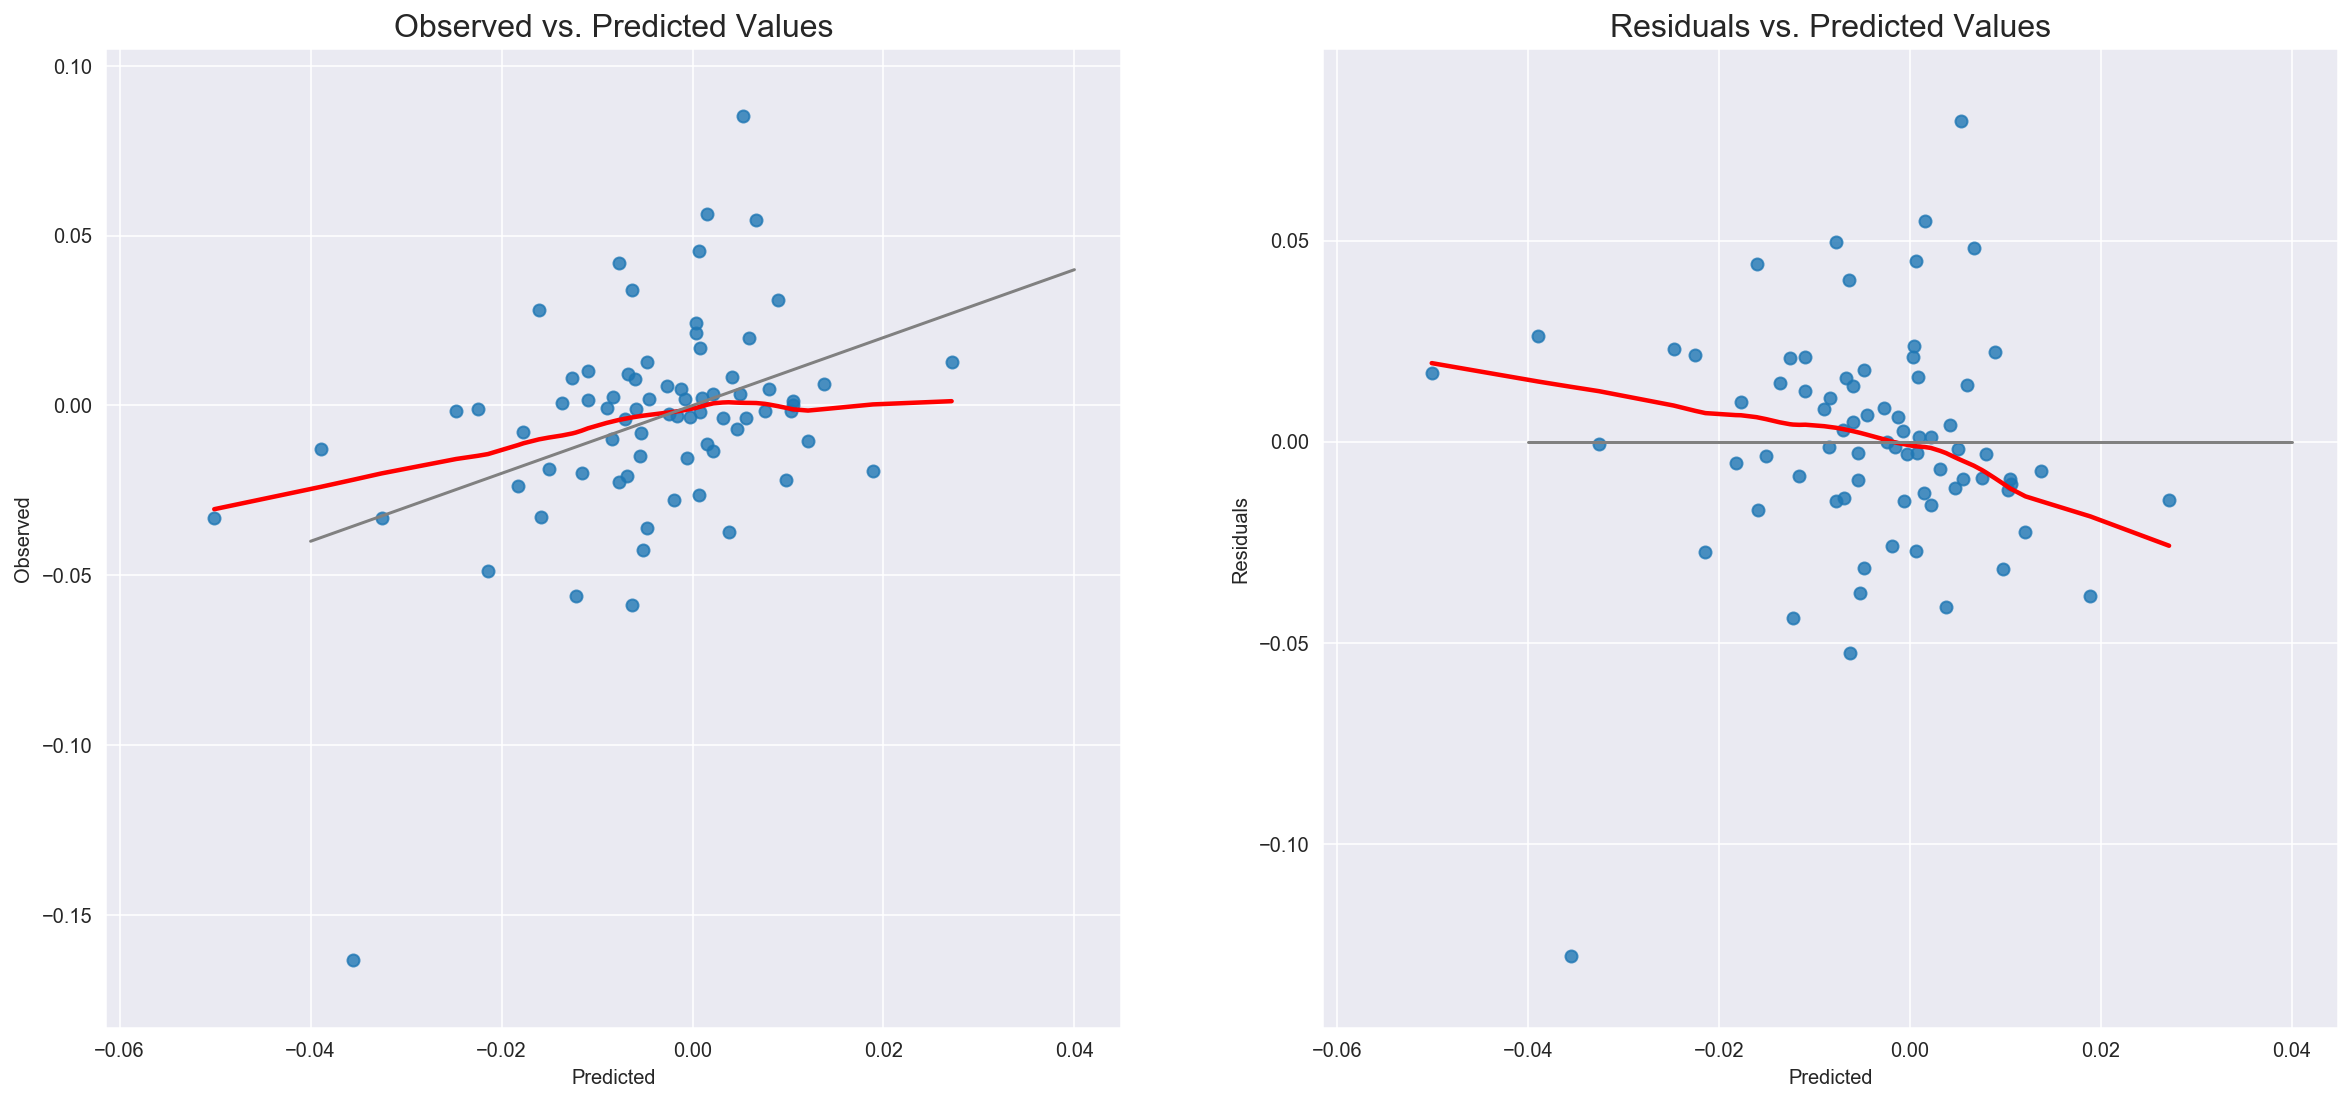

In [41]:
linearity_test(result_p_m, y_portfolio_m) 

Linearity is not really satisfied. 

##### Test Strict exogeneity:

In [42]:
print(f"mean of residuals = {resid_p_m.mean()}")

mean of residuals = -1.1102230246251566e-18


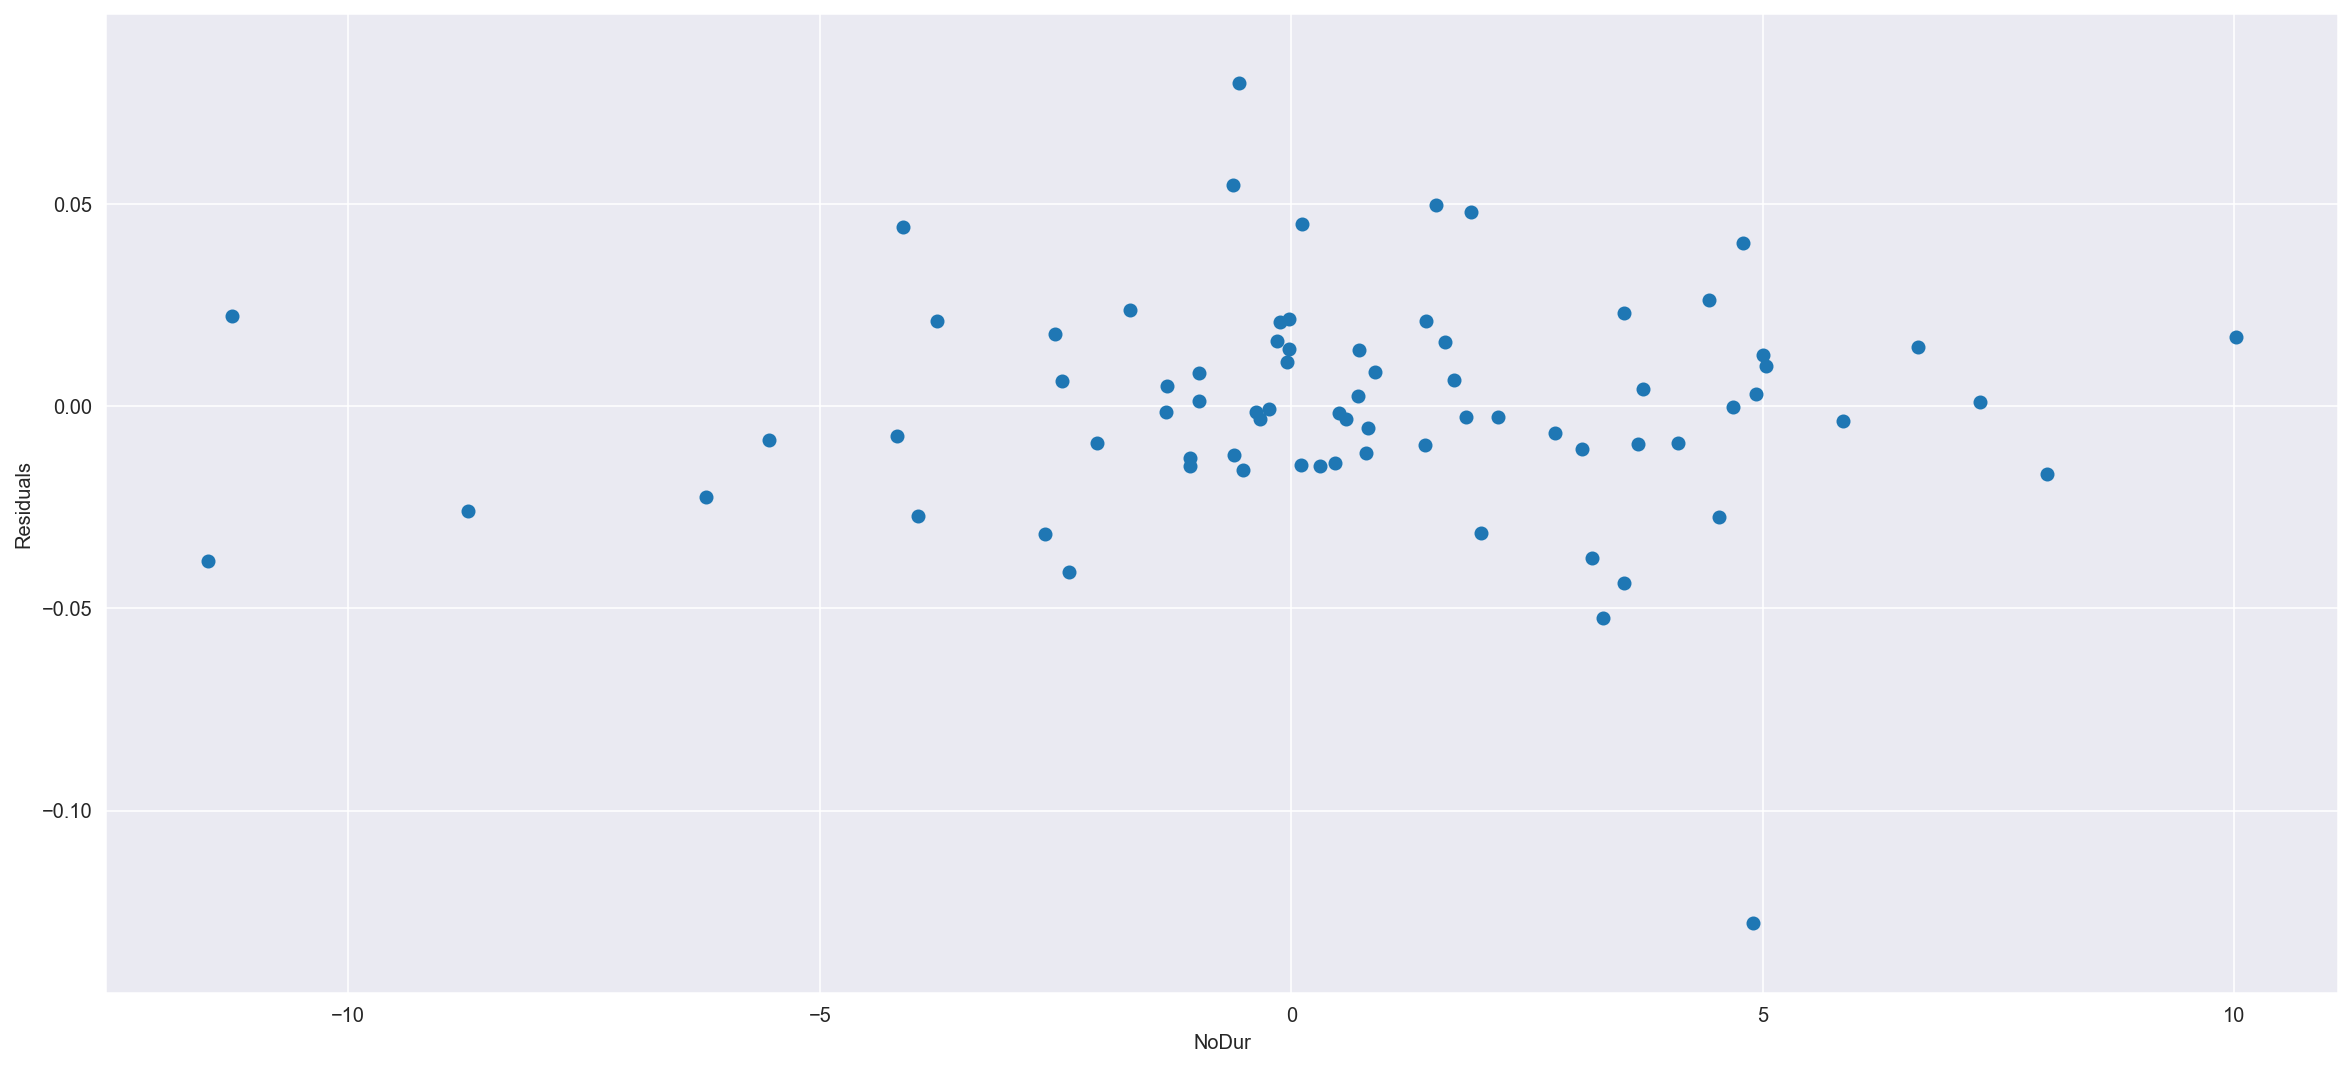

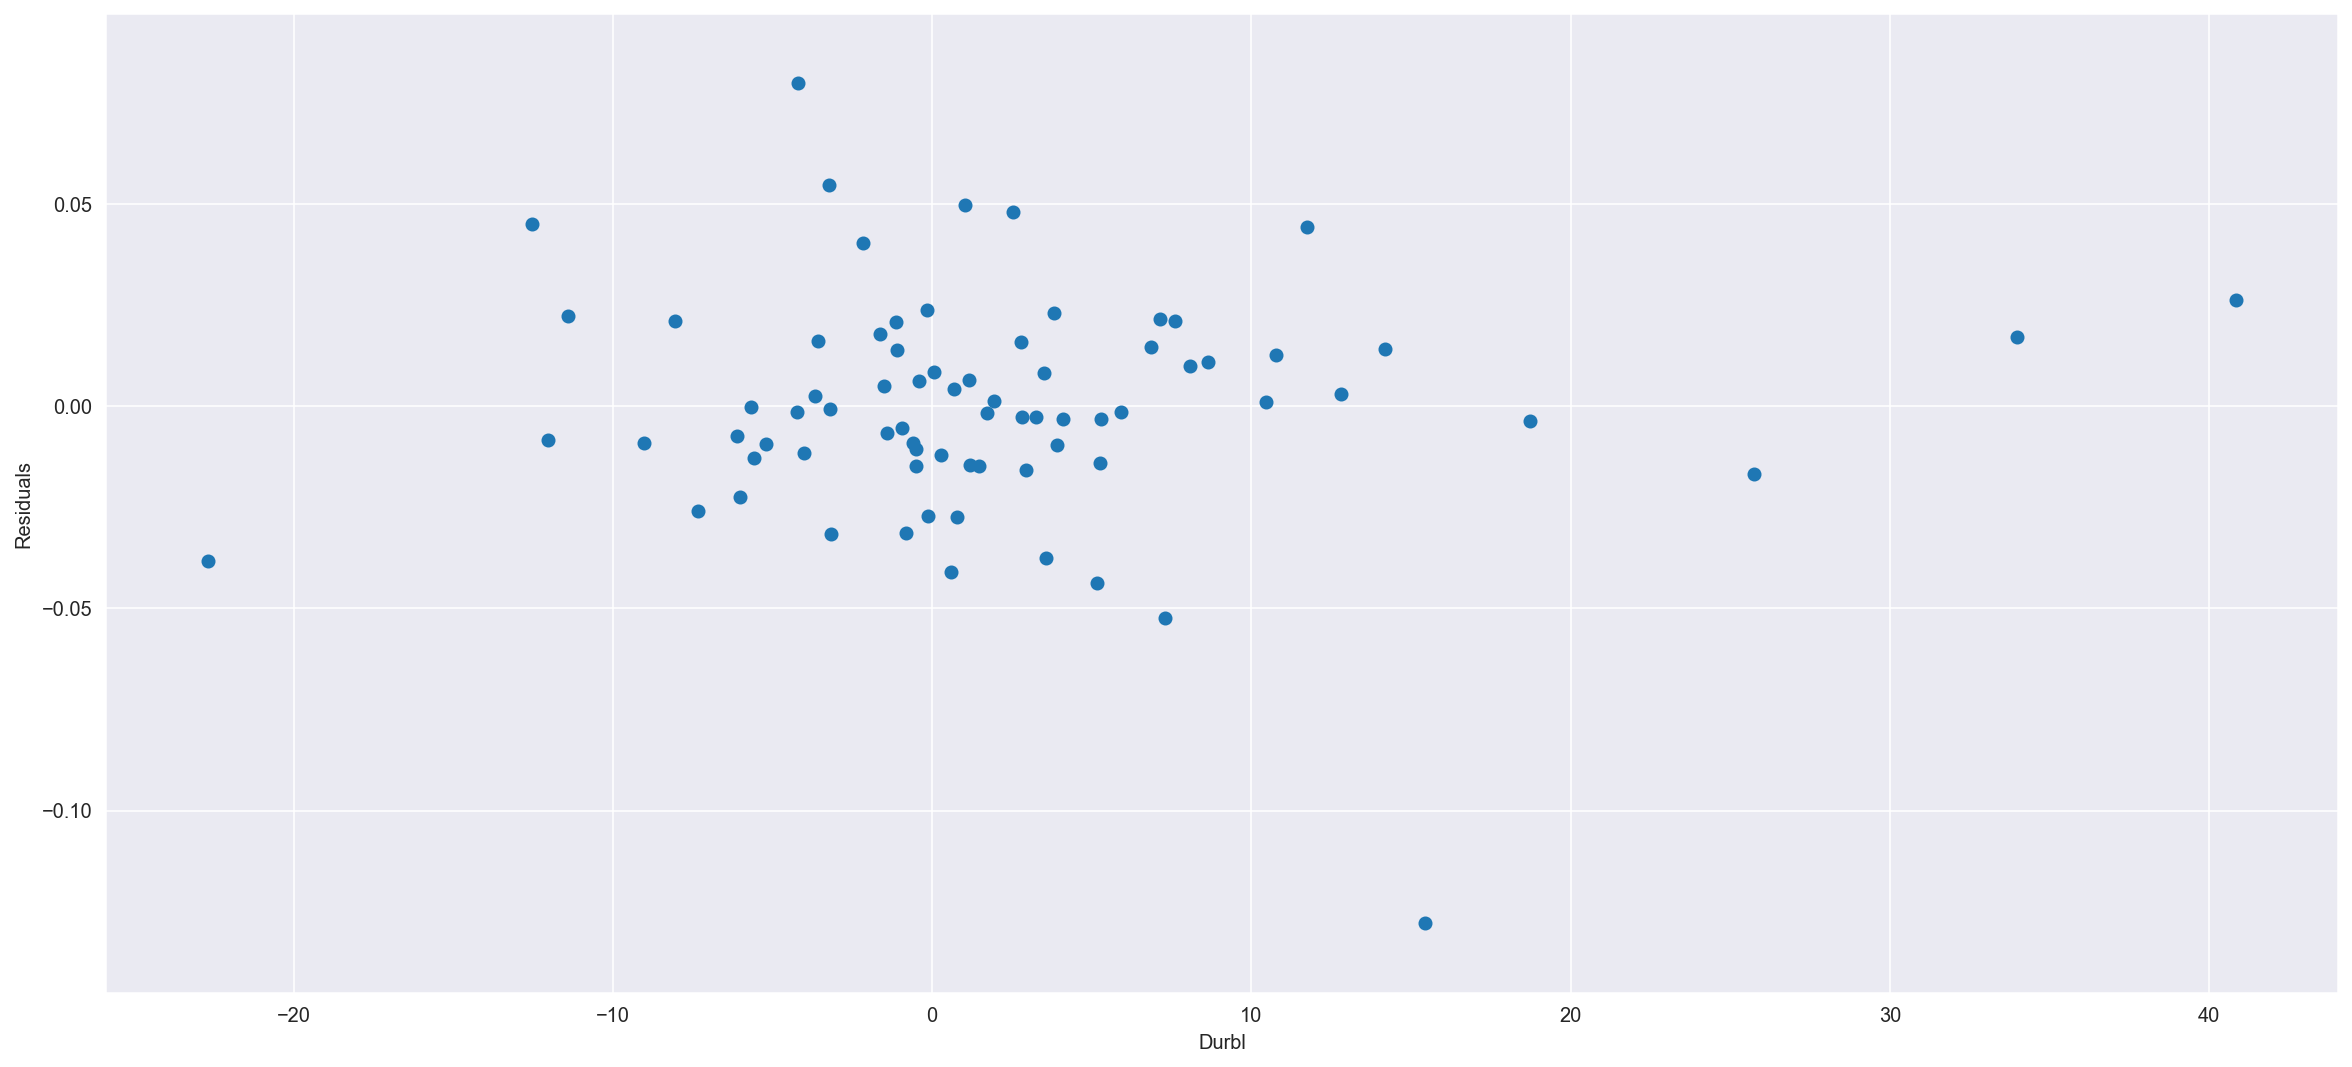

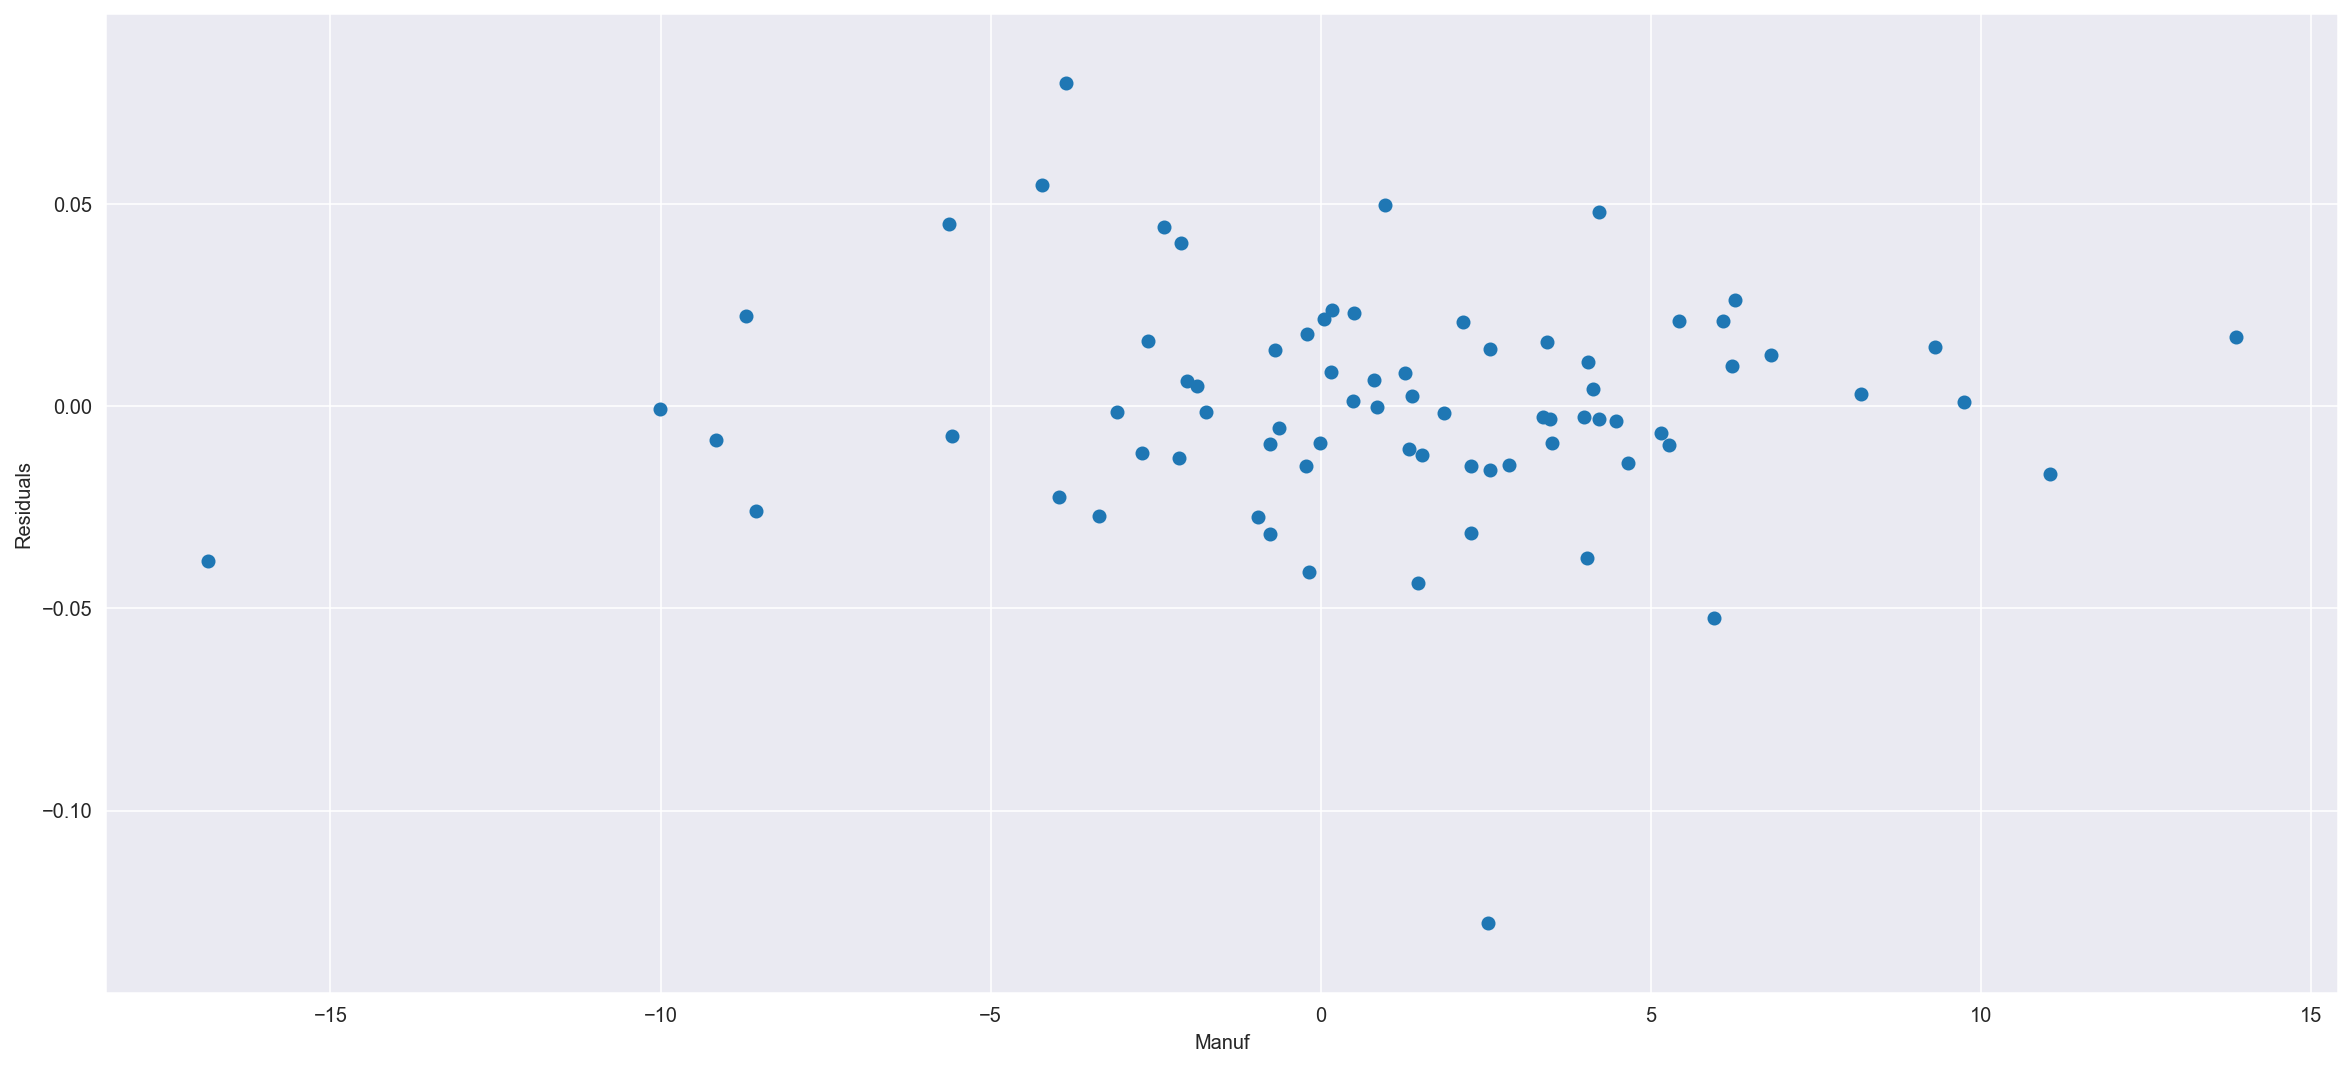

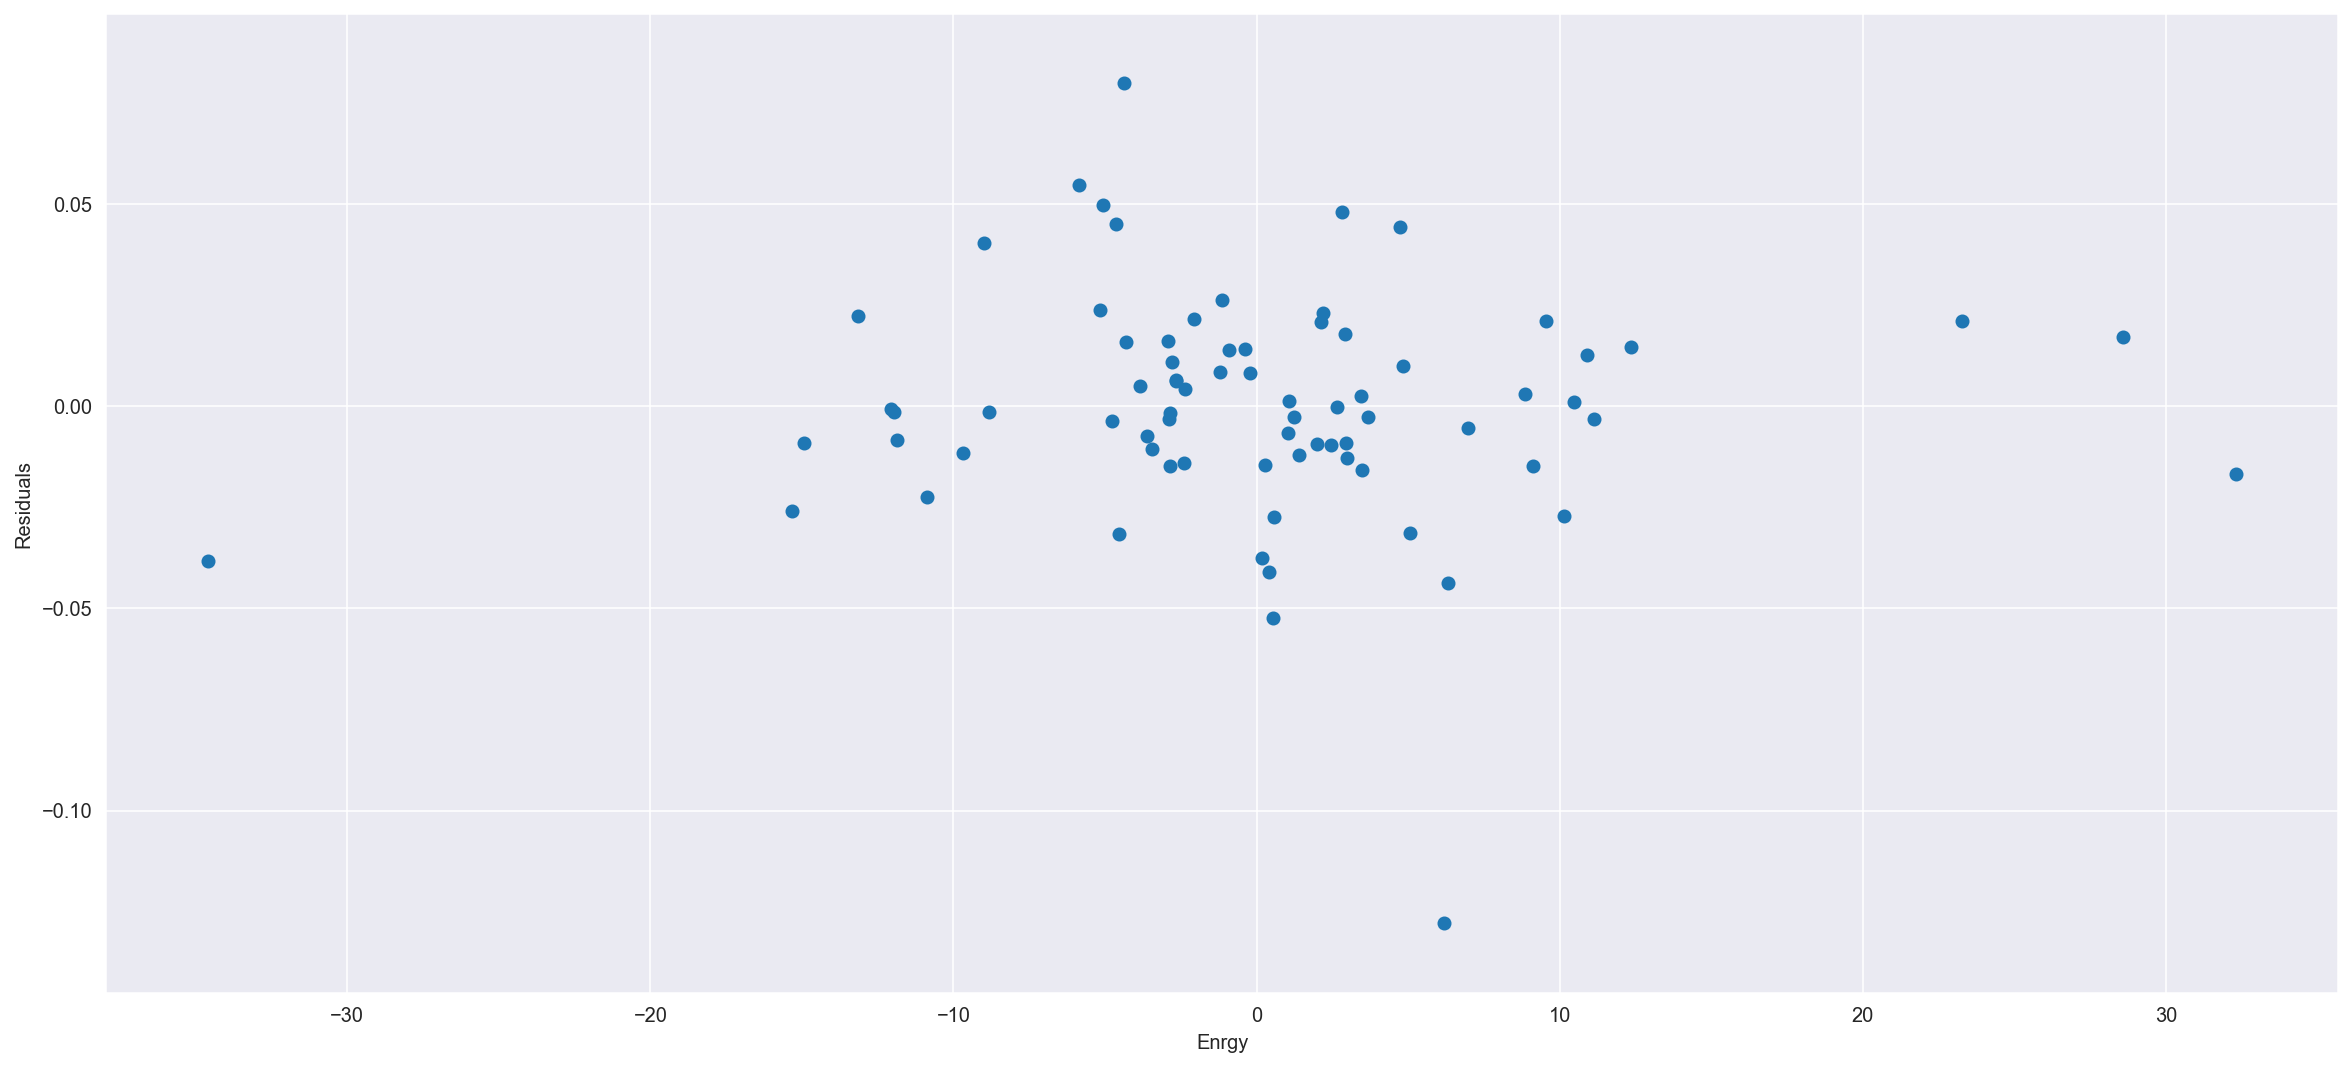

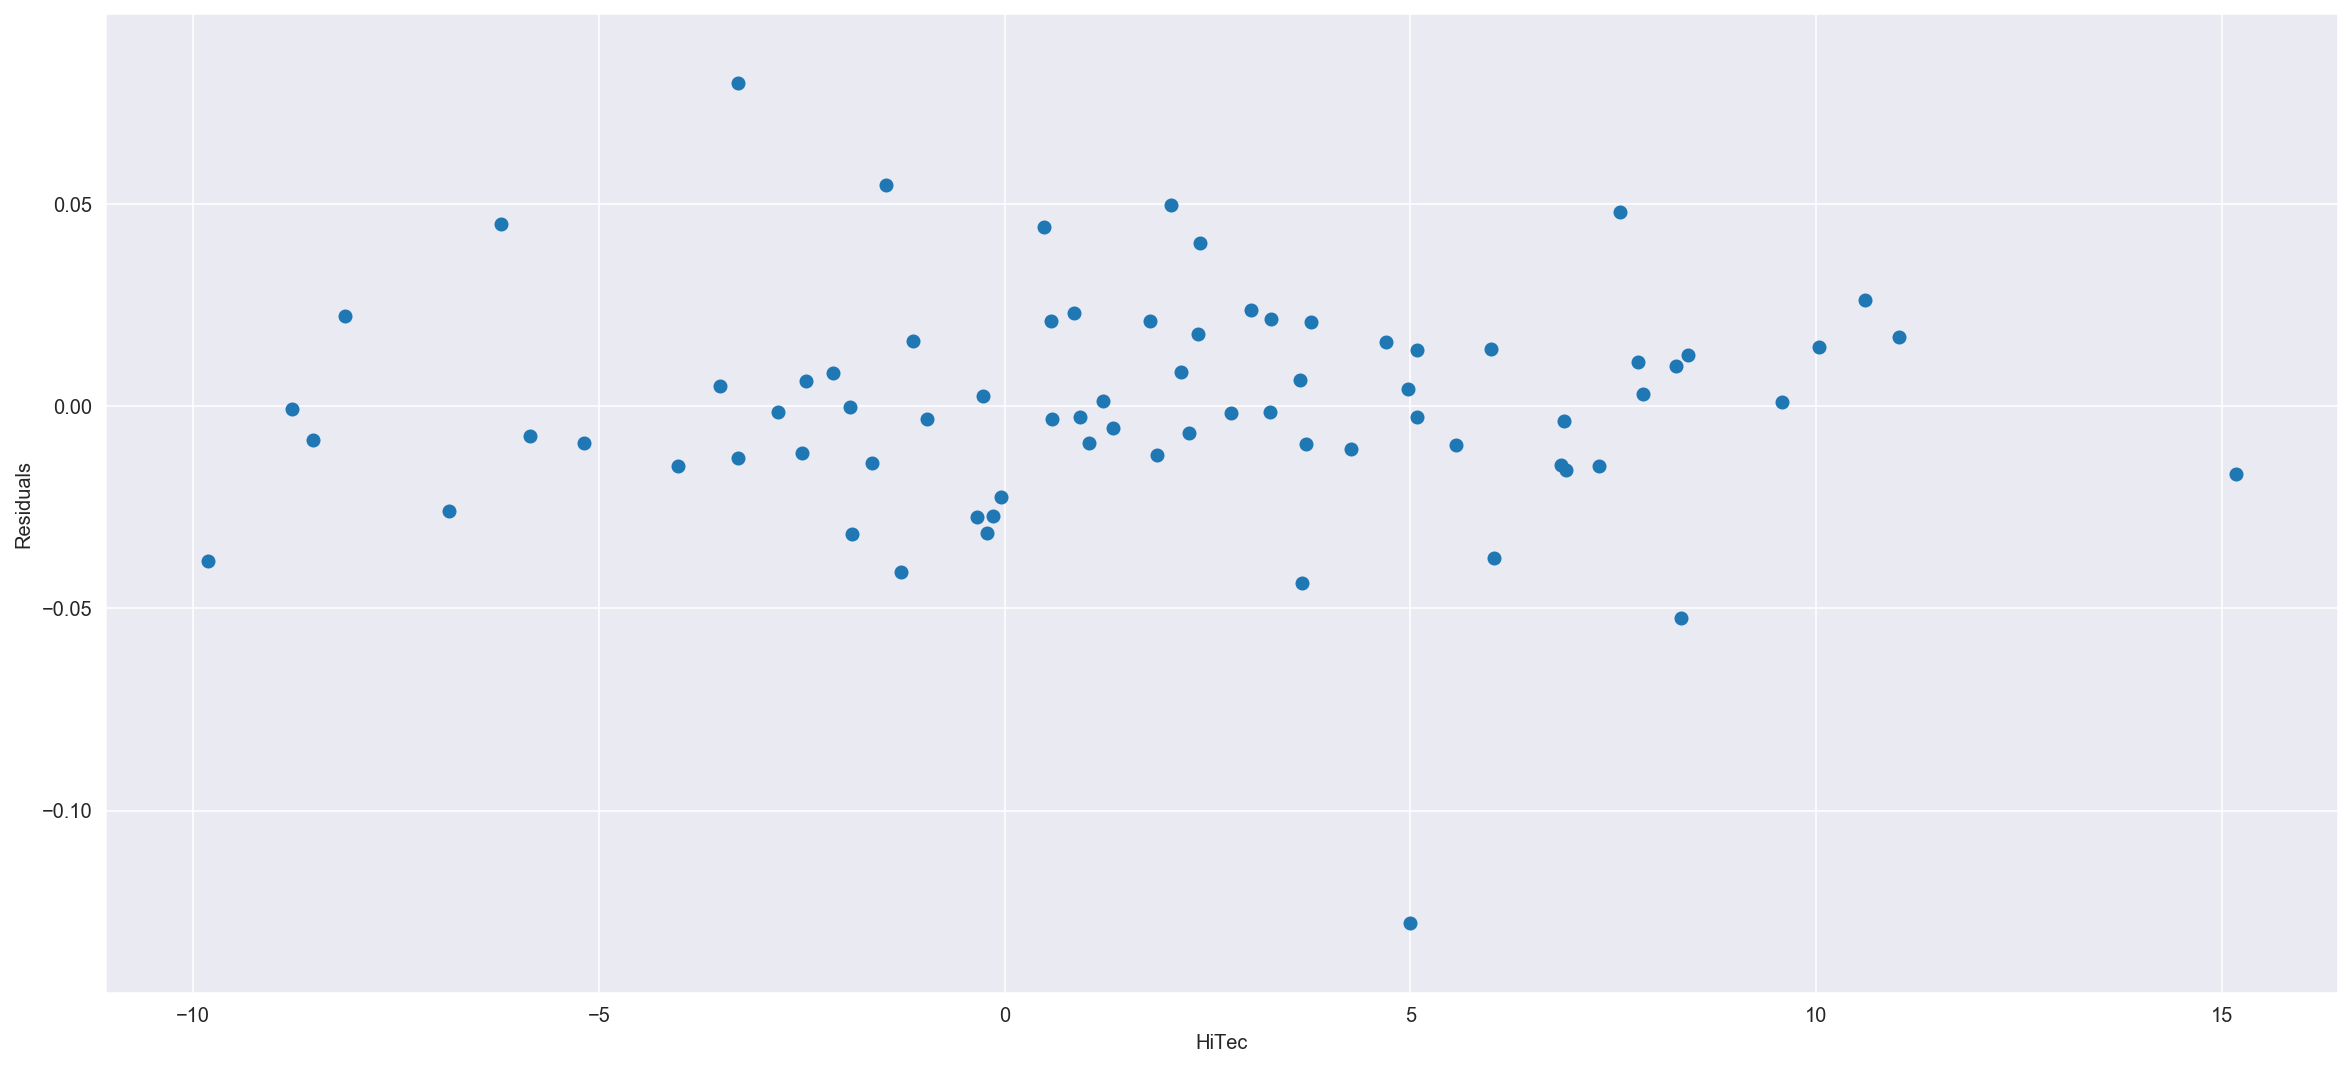

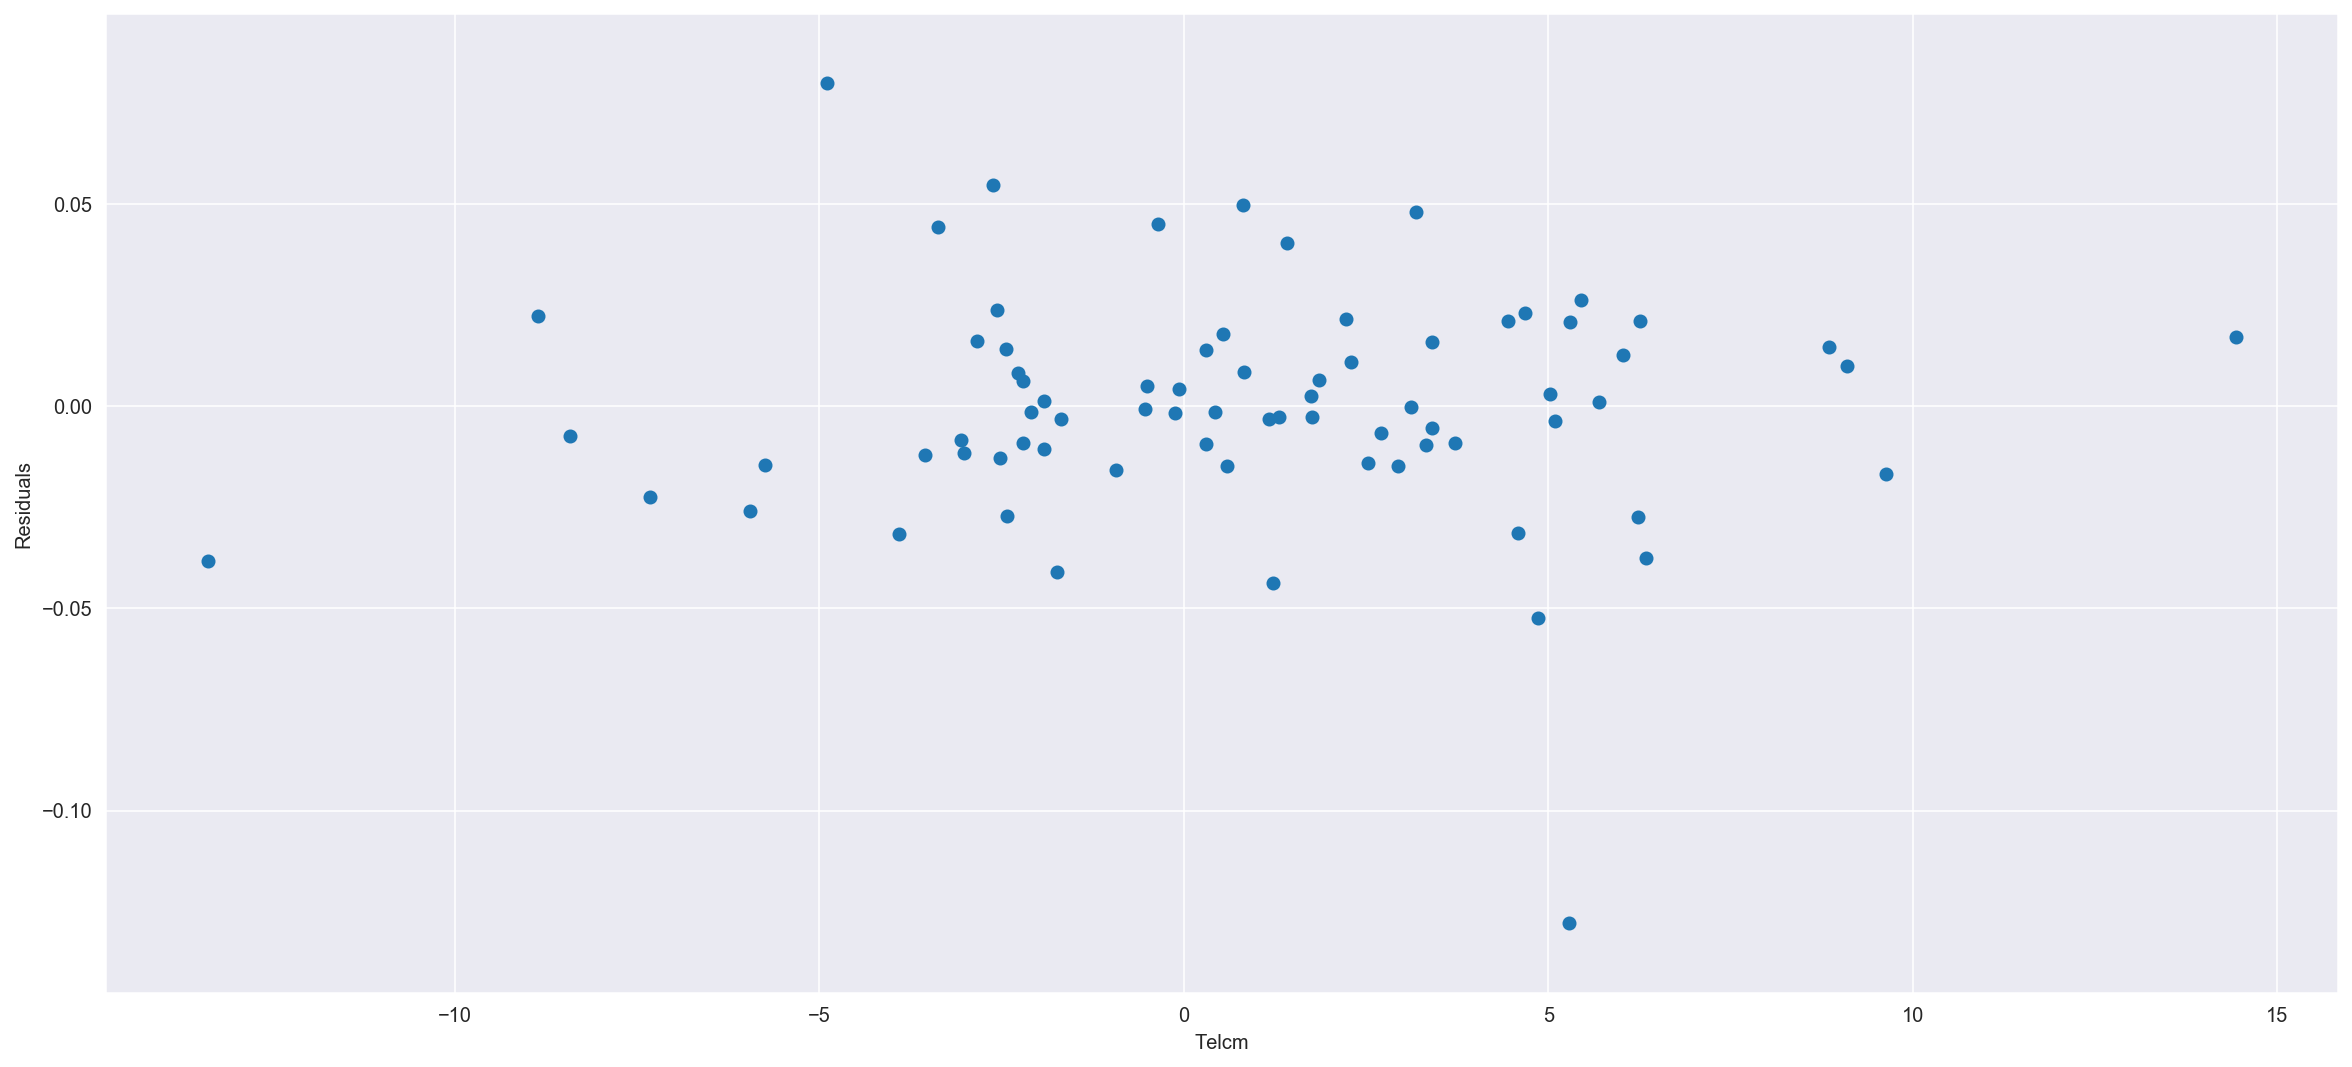

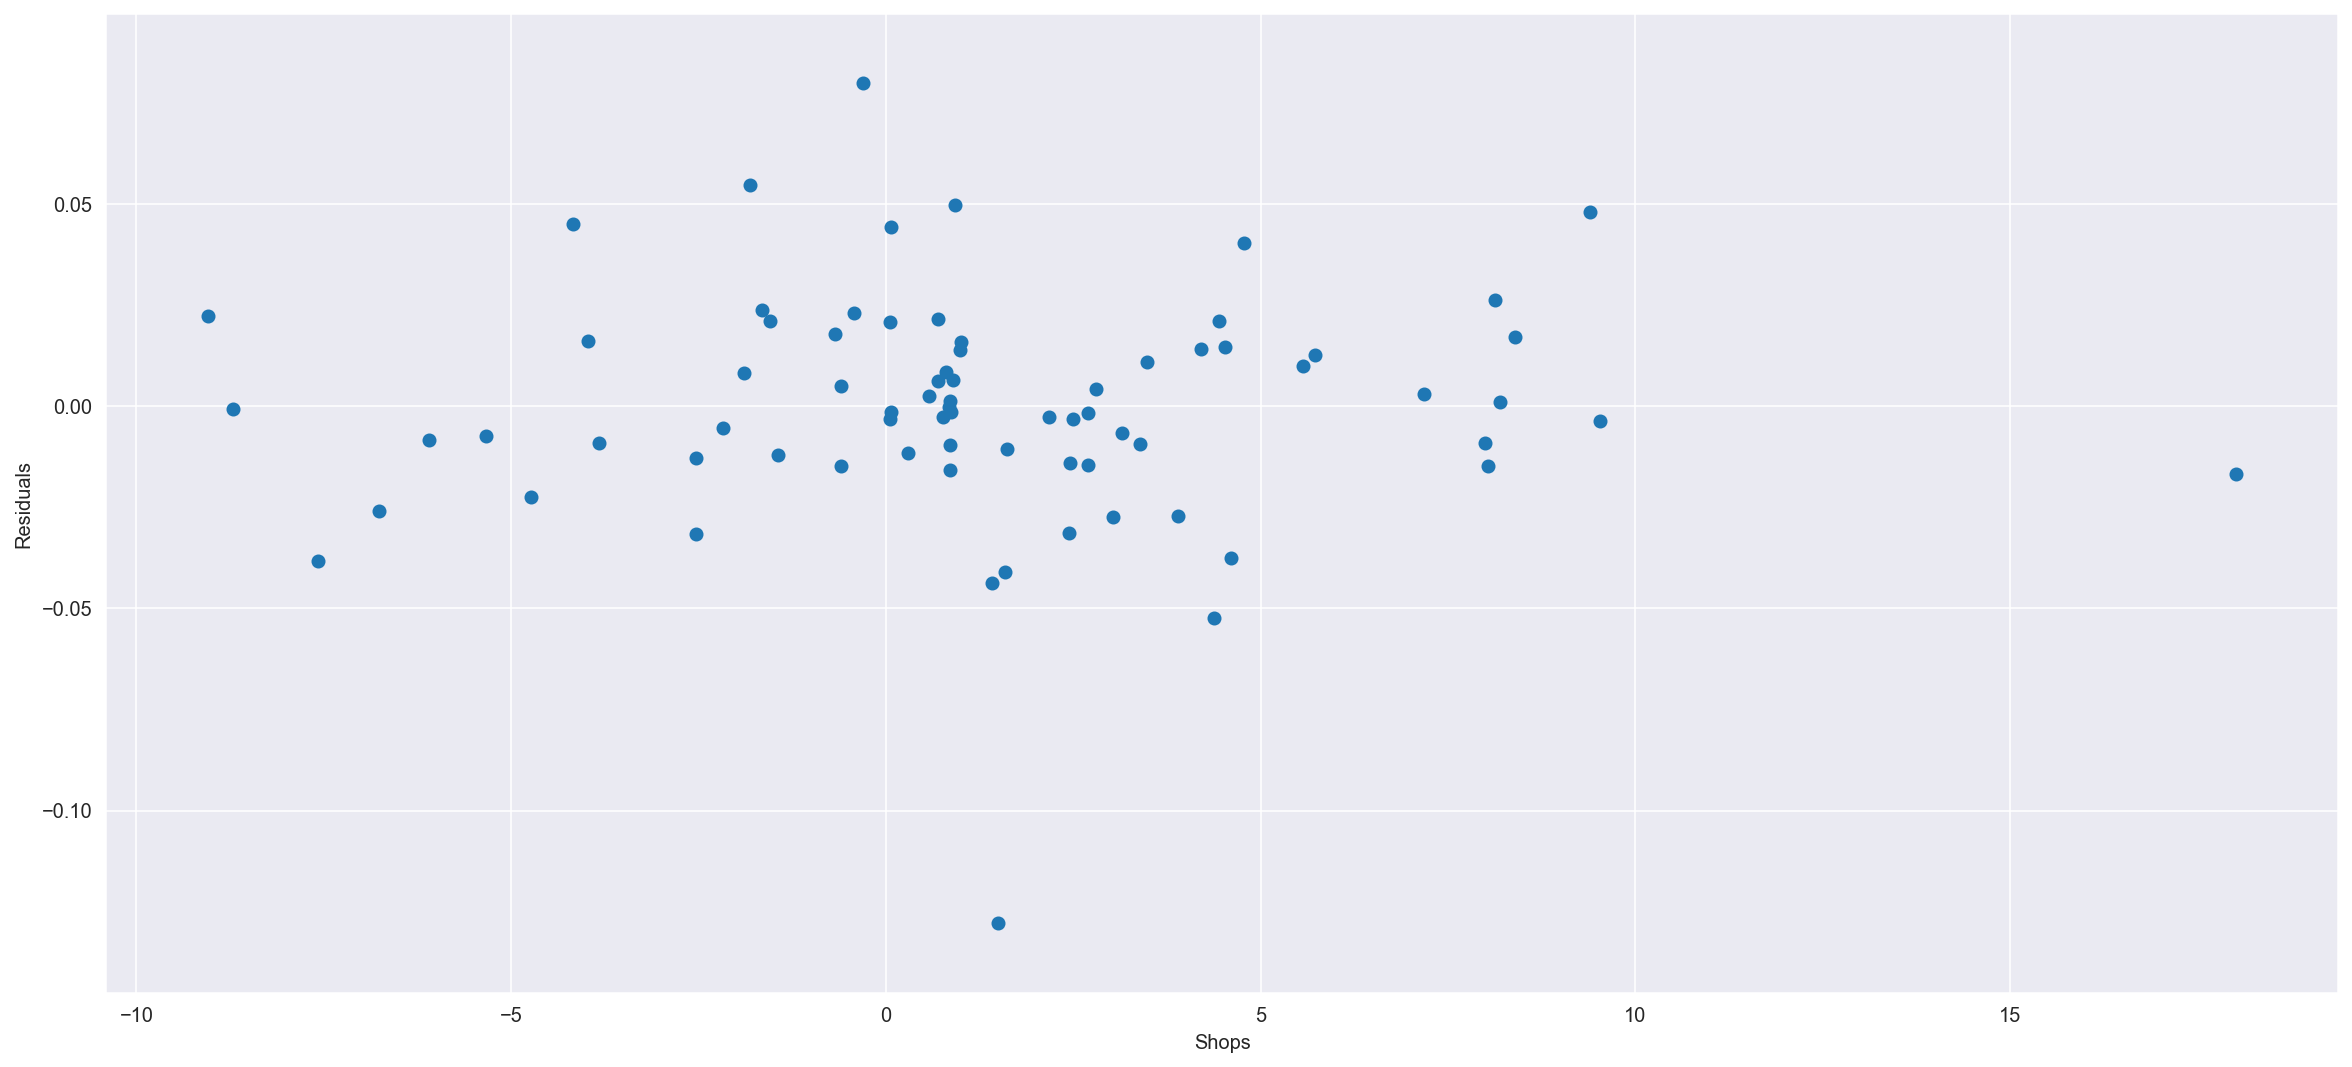

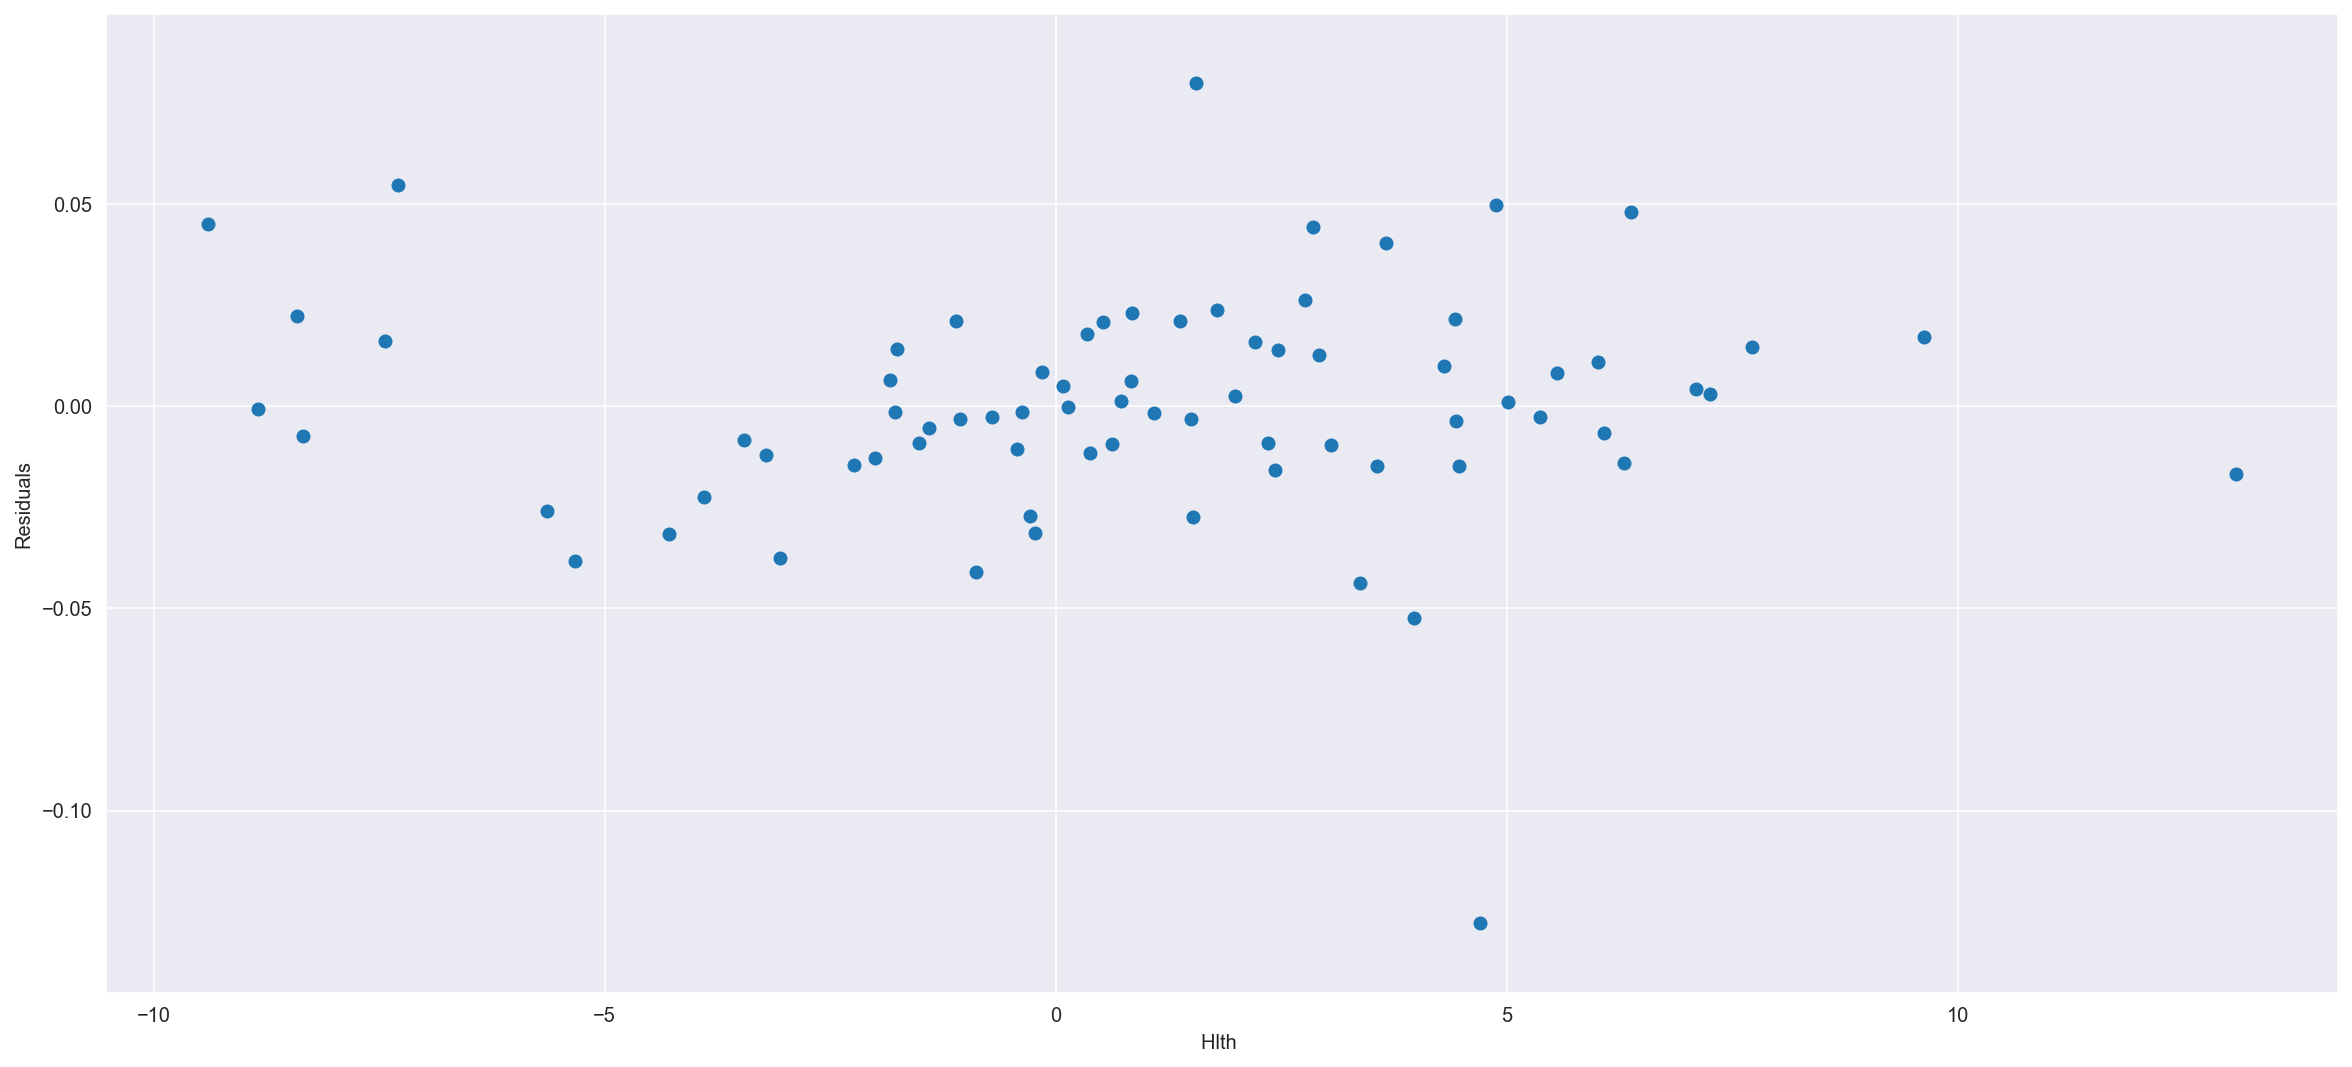

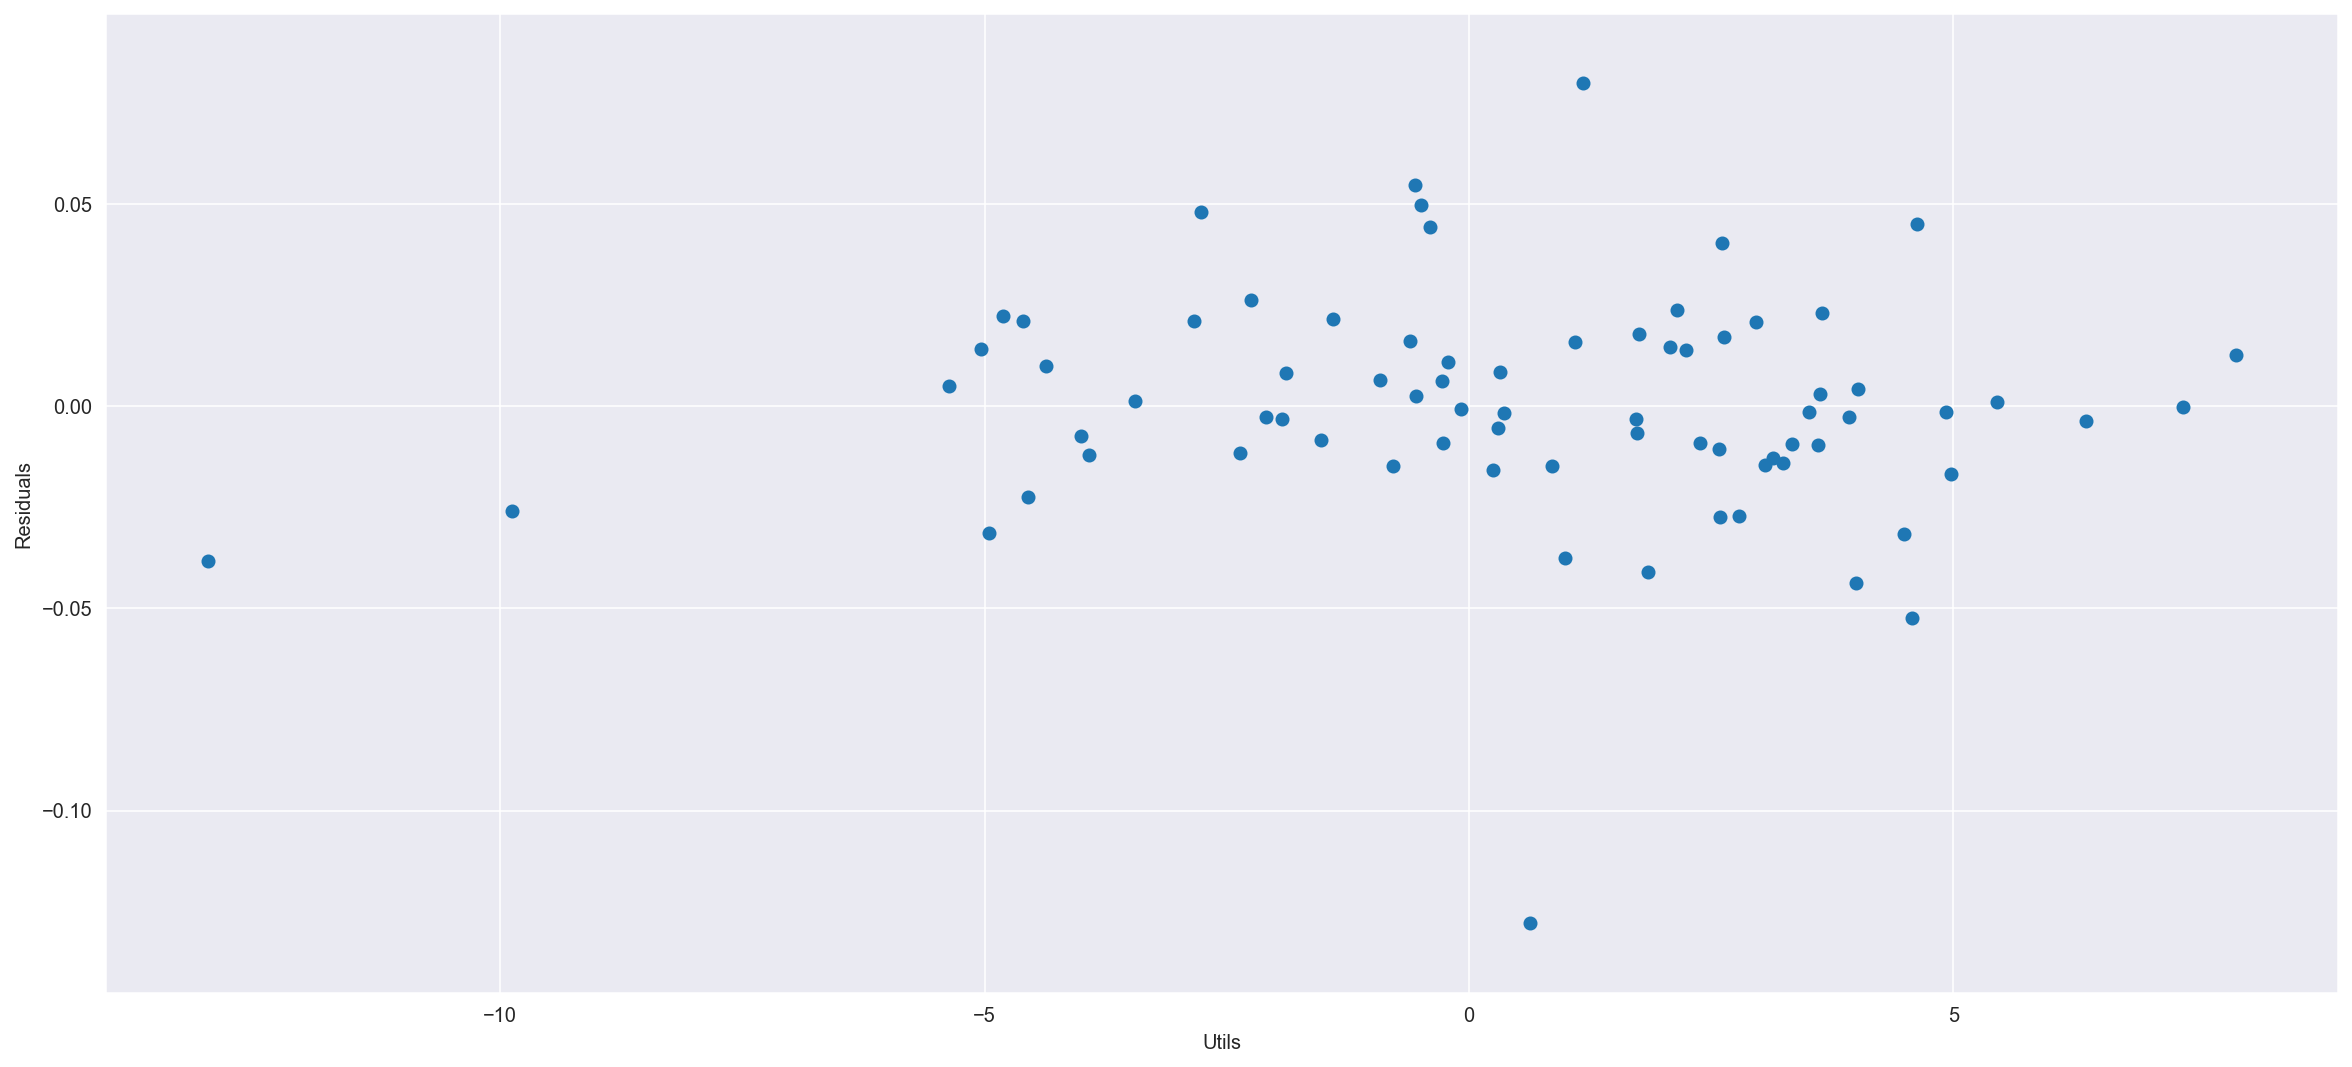

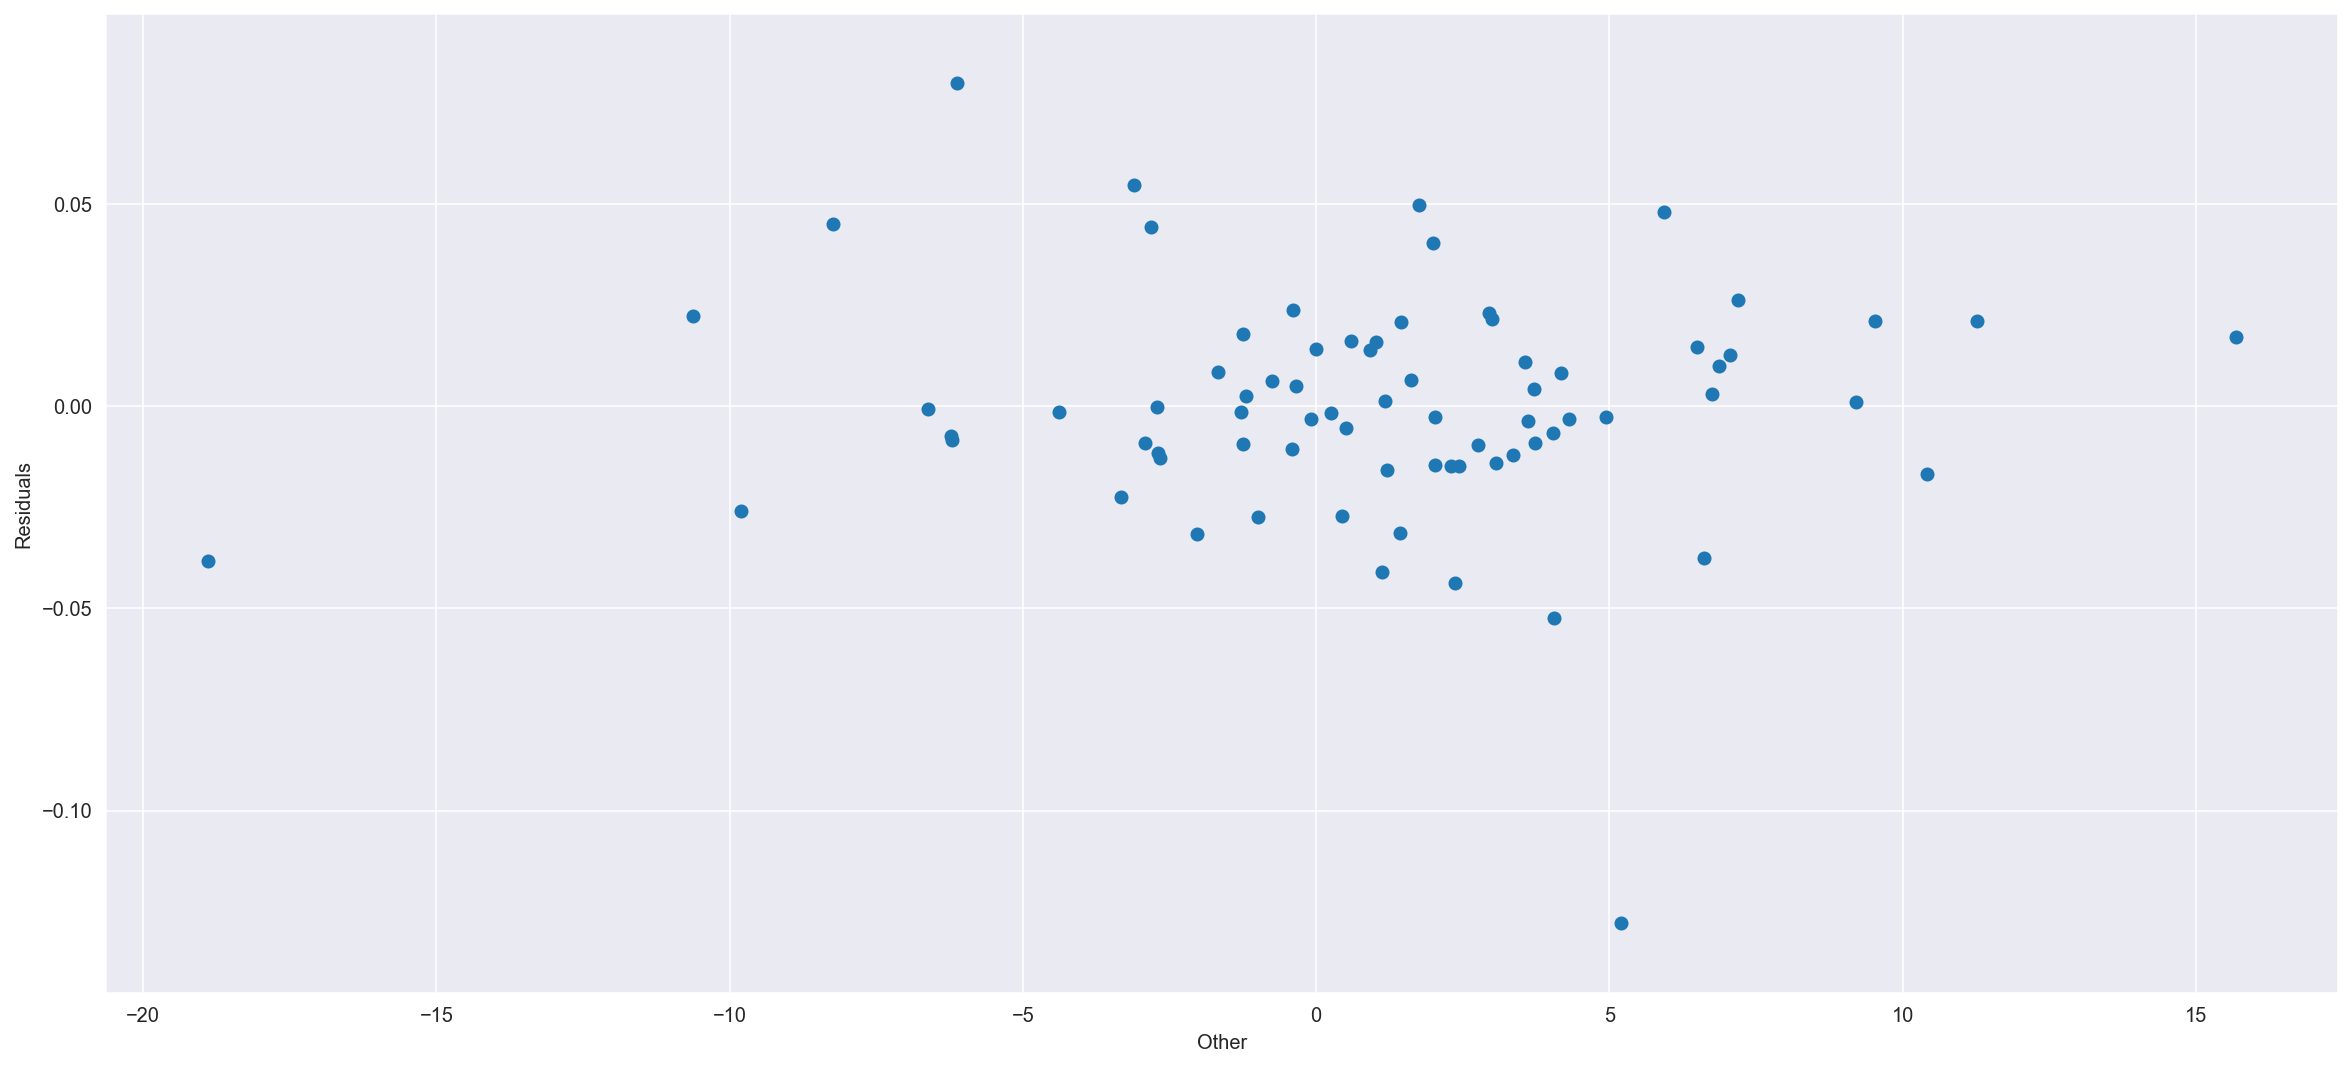

,residuals
NoDur,1.245010e-16
Durbl,1.457604e-16
Manuf,-4.427568e-17
Enrgy,-1.134646e-16
HiTec,7.801790e-17
Telcm,-1.088775e-16
Shops,1.595302e-16
Hlth,-3.028492e-17
Utils,8.229368e-17
Other,-7.332845e-17


In [43]:
attributes = portfolio10_m_3.columns
for att in attributes:
    plt.scatter(y = resid_p_m, x = portfolio10_m_3[att])
    plt.xlabel(att)
    plt.ylabel('Residuals')
    plt.show()
df = portfolio10_m_3.copy(deep=True)
df['residuals'] = resid_p_m
df.corr()[['residuals']]

In [44]:
pearson_corr_test(X_portfolio_m, resid_p_m)

Performing Pearson Correlation Test ...
NoDur 
 correlation: 1.3196340935657365e-16 
 p-value: 0.9999999999999951
 Fail to rej null, conclude non-correlated

Durbl 
 correlation: 1.150221919136496e-16 
 p-value: 0.9999999999999951
 Fail to rej null, conclude non-correlated

Manuf 
 correlation: -2.7782431954292506e-17 
 p-value: 1.0000000000000002
 Fail to rej null, conclude non-correlated

Enrgy 
 correlation: -1.2176130363069388e-16 
 p-value: 0.9999999999999951
 Fail to rej null, conclude non-correlated

HiTec 
 correlation: 6.502865511654789e-17 
 p-value: 0.9999999999999951
 Fail to rej null, conclude non-correlated

Telcm 
 correlation: -1.1737905910062737e-16 
 p-value: 0.9999999999999951
 Fail to rej null, conclude non-correlated

Shops 
 correlation: 1.683763525278523e-16 
 p-value: 0.9999999999999992
 Fail to rej null, conclude non-correlated

Hlth  
 correlation: -4.950448716127888e-17 
 p-value: 1.0000000000000002
 Fail to rej null, conclude non-correlated

Utils 
 correlat

Strict exogeneity is satisfied.

##### Test No Multicollinearity:

In [45]:
# bivariate correlation
portfolio10_m_3.corr()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
NoDur,1.000000,0.622654,0.778373,0.624149,0.718956,0.826391,0.732824,0.633534,0.596078,0.737613
Durbl,0.622654,1.000000,0.728346,0.575616,0.744992,0.645769,0.717809,0.620465,0.285254,0.729673
Manuf,0.778373,0.728346,1.000000,0.775486,0.820804,0.800890,0.783050,0.744885,0.434020,0.922144
Enrgy,0.624149,0.575616,0.775486,1.000000,0.601804,0.694304,0.617544,0.556288,0.359095,0.794844
HiTec,0.718956,0.744992,0.820804,0.601804,1.000000,0.681950,0.832341,0.708132,0.392614,0.786339
Telcm,0.826391,0.645769,0.800890,0.694304,0.681950,1.000000,0.710557,0.653664,0.444519,0.805623
Shops,0.732824,0.717809,0.783050,0.617544,0.832341,0.710557,1.000000,0.771397,0.422255,0.758238
Hlth,0.633534,0.620465,0.744885,0.556288,0.708132,0.653664,0.771397,1.000000,0.334700,0.707340
Utils,0.596078,0.285254,0.434020,0.359095,0.392614,0.444519,0.422255,0.334700,1.000000,0.344281
Other,0.737613,0.729673,0.922144,0.794844,0.786339,0.805623,0.758238,0.707340,0.344281,1.000000


In [46]:
VIF_test(X_portfolio_m)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
vif,4.715146,2.677894,9.618939,2.963843,4.762868,4.472918,4.675652,2.866917,1.674968,8.847743


No Multicollinearity is NOT satisfied due to the relatively high correlations between 
- Manuf and NoDur
- HiTec and NoDur
- Telcm and NoDur
- Shops and NoDur
- Others and NoDur
- etc (any > 0.7)

VIF furtherly confirms this result.

##### Test Spherical error variance:

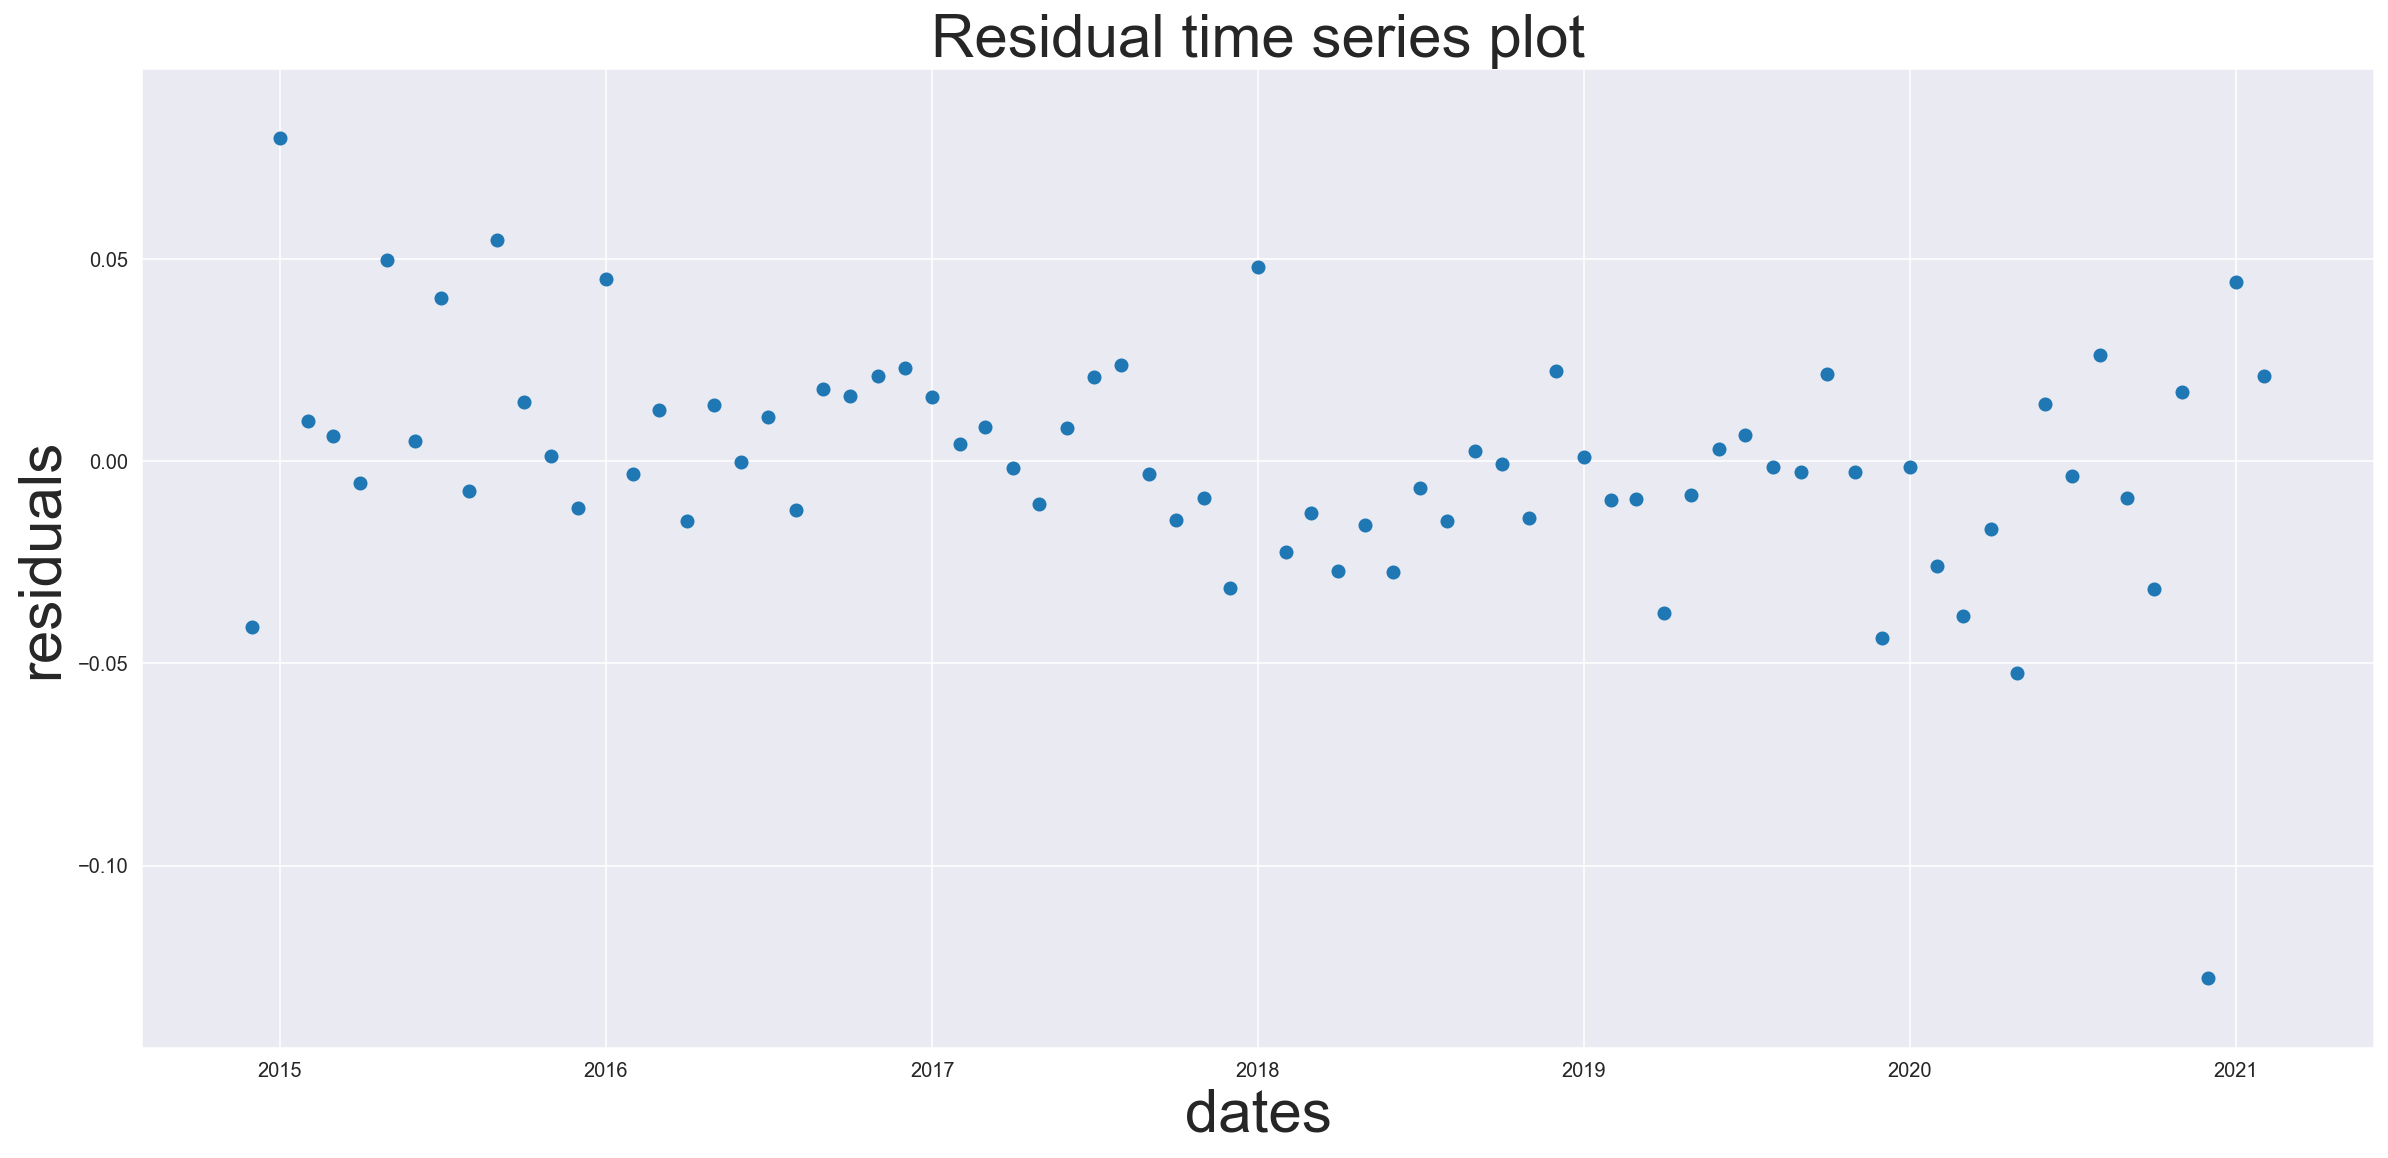

In [47]:
# to see constant variance of error terms
plt.scatter(y = resid_p_m, x = portfolio10_m_3.index)
plt.title('Residual time series plot', fontsize = 30)
plt.ylabel('residuals', fontsize = 30)
plt.xlabel('dates', fontsize = 30)
plt.show()


---- Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  8.789292
p-value                        0.552211
f-value                        0.849583
f p-value                      0.583668
Fail to Reject Null, conclude homoscedasticity

---- Goldfeld-Quandt test ----
                value
F statistic  1.944823
p-value      0.093984
Fail to Reject Null, conclude homoscedasticity

---- Residuals plots ----


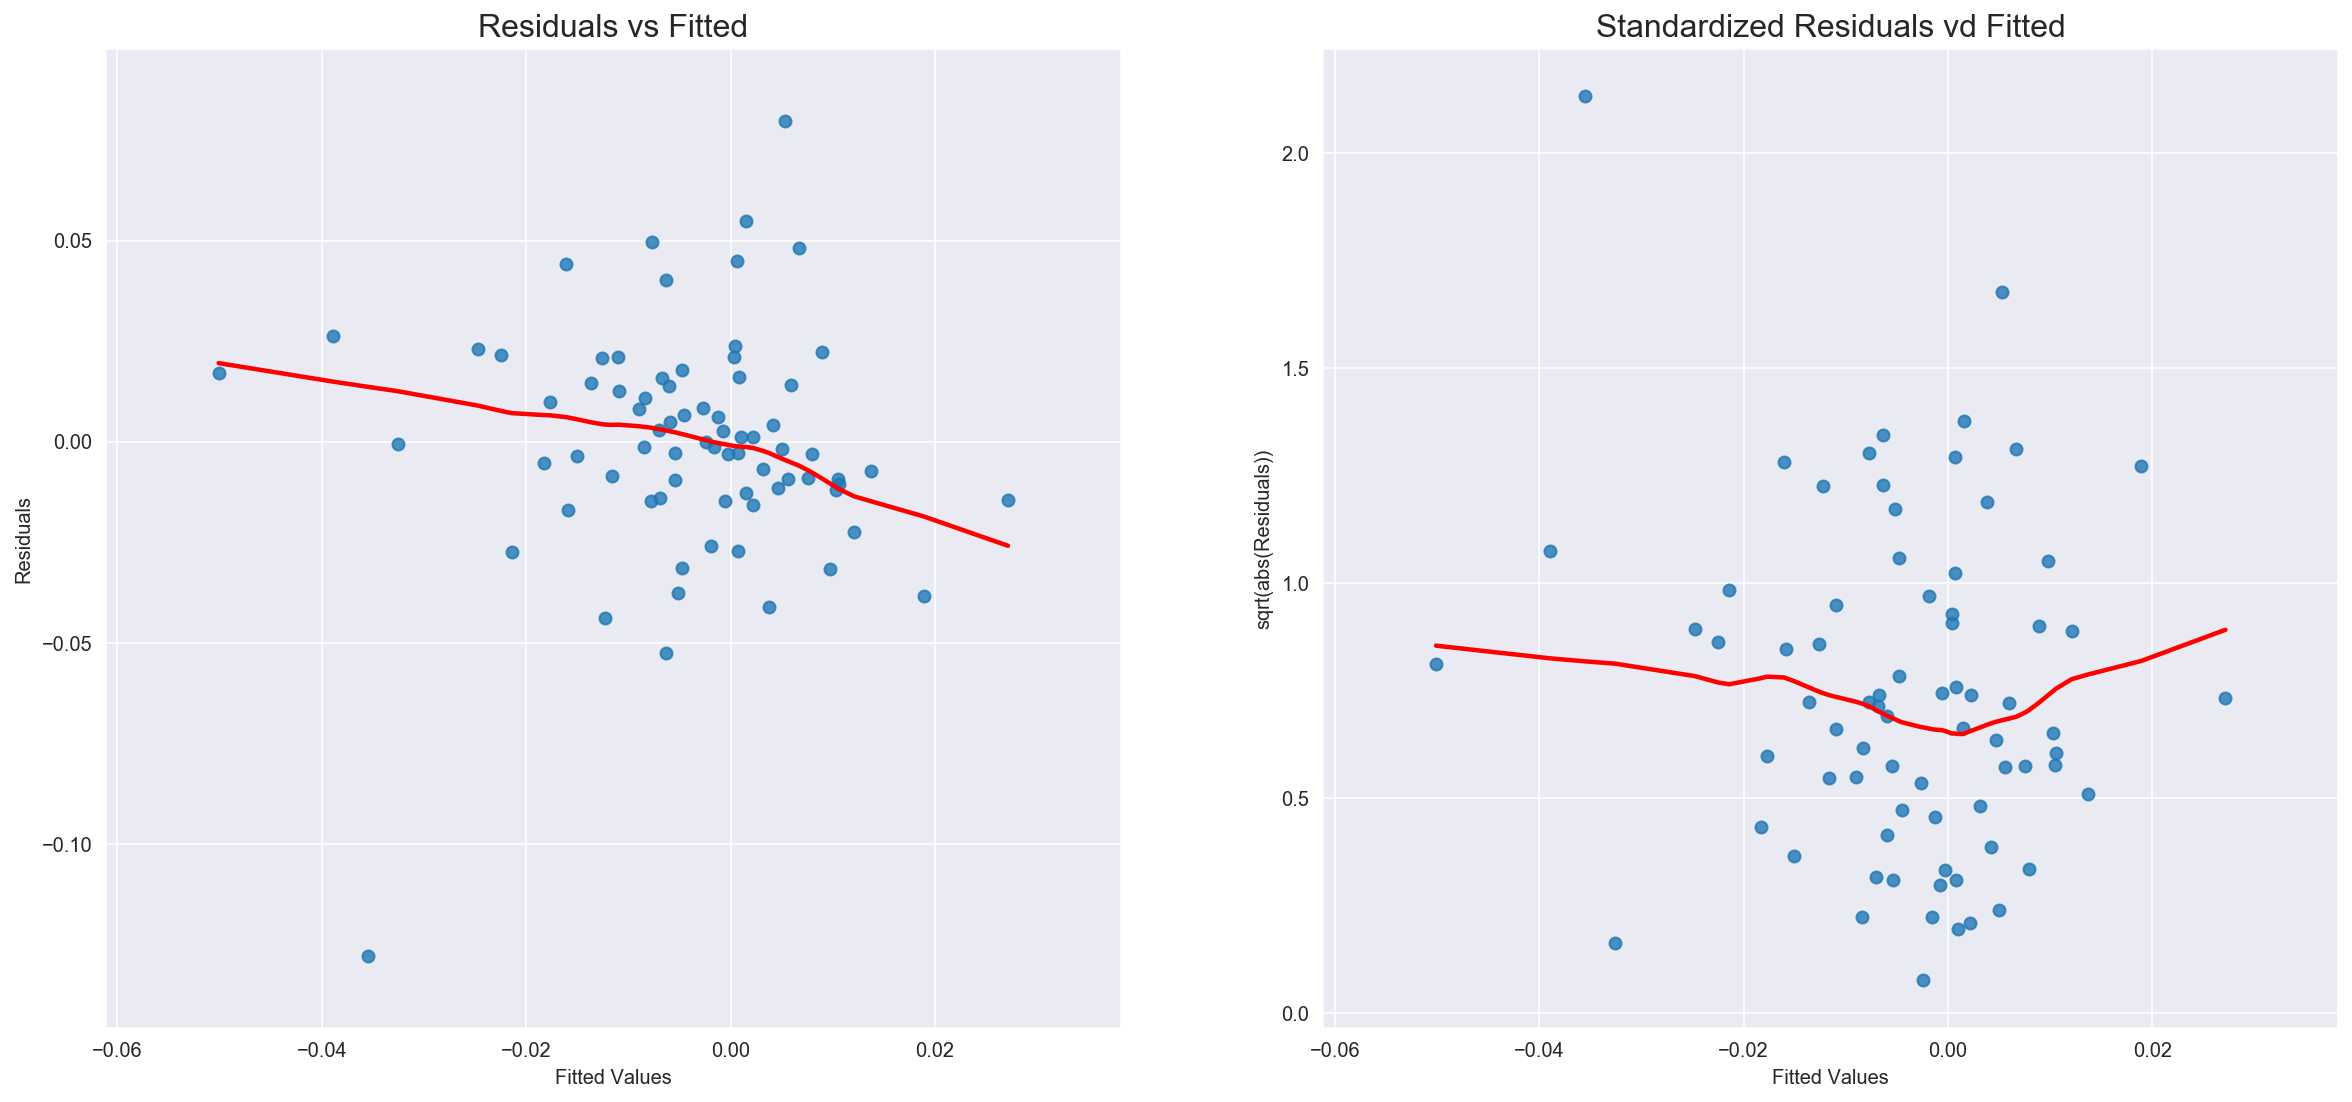

In [48]:
homoscedasticity_test(result_p_m)

Durbin-Watson: 2.2046775948370474
Little to no autocorrelation 

Assumption satisfied


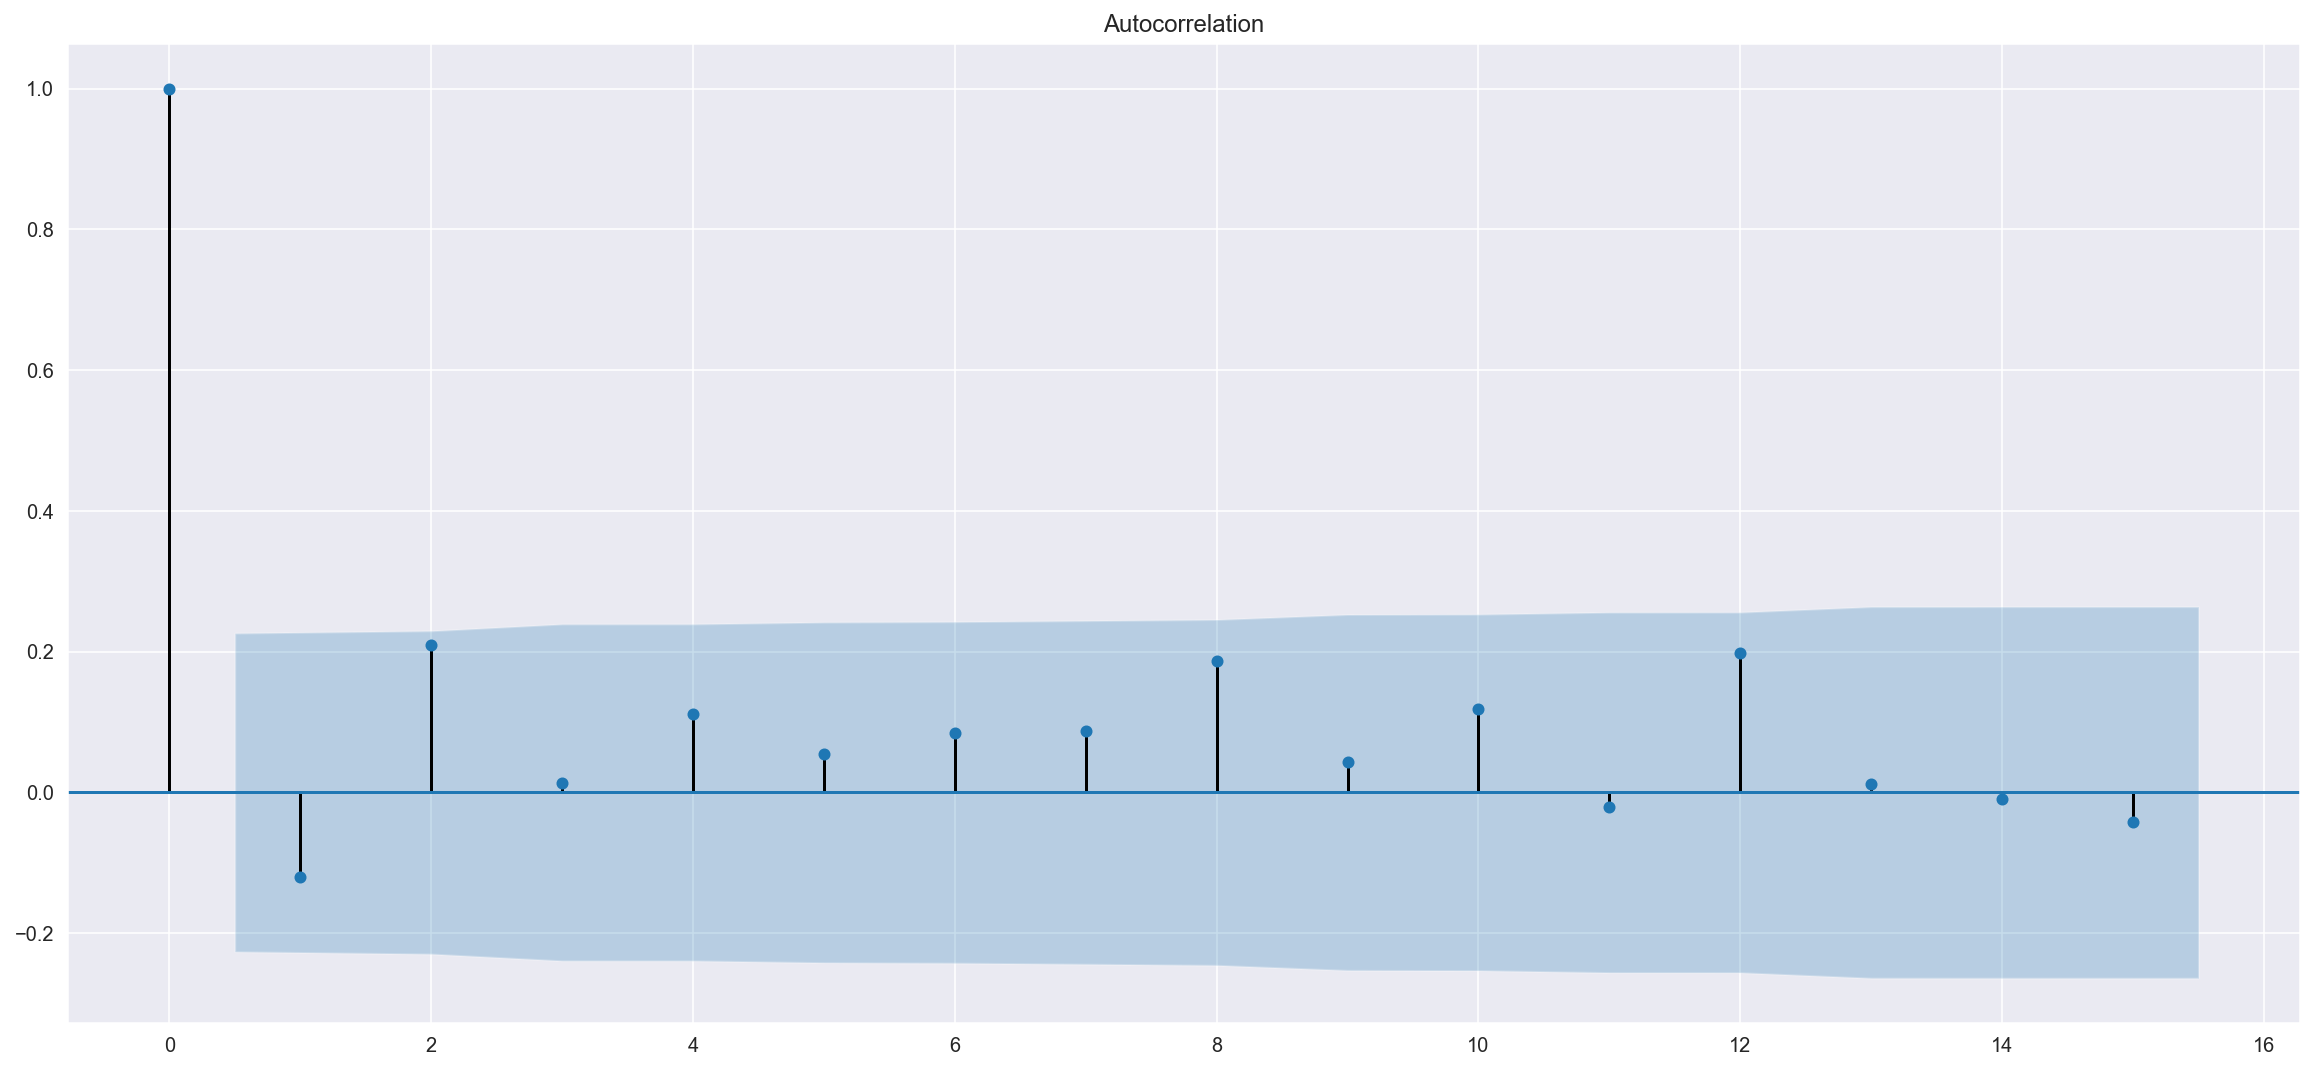

In [49]:
# check autocorrelation of error terms
autocorrelation_test(resid_p_m)

Spherical error variance is Satisfied.

#### Test Normality:

In [50]:
print(f'residual mean: {resid_p_m.mean()}')
print(f'residual std: {resid_p_m.std()}')
s = pd.DataFrame(np.random.normal(resid_p_m.mean(), resid_p_m.std(), len(resid_p_m)))
print(f'skewness: \n   residual: {resid_p_m.skew()} \n   normal: {s[0].skew()}')
print(f'kurtosis: \n   residual: {resid_p_m.kurtosis()} \n   normal: {s[0].kurtosis()}')

residual mean: -1.1102230246251566e-18
residual std: 0.02821764699865634
skewness: 
   residual: -0.8574029350423579 
   normal: -0.09135278620233209
kurtosis: 
   residual: 5.2854184749172894 
   normal: 0.006407317065819651


Non-normal


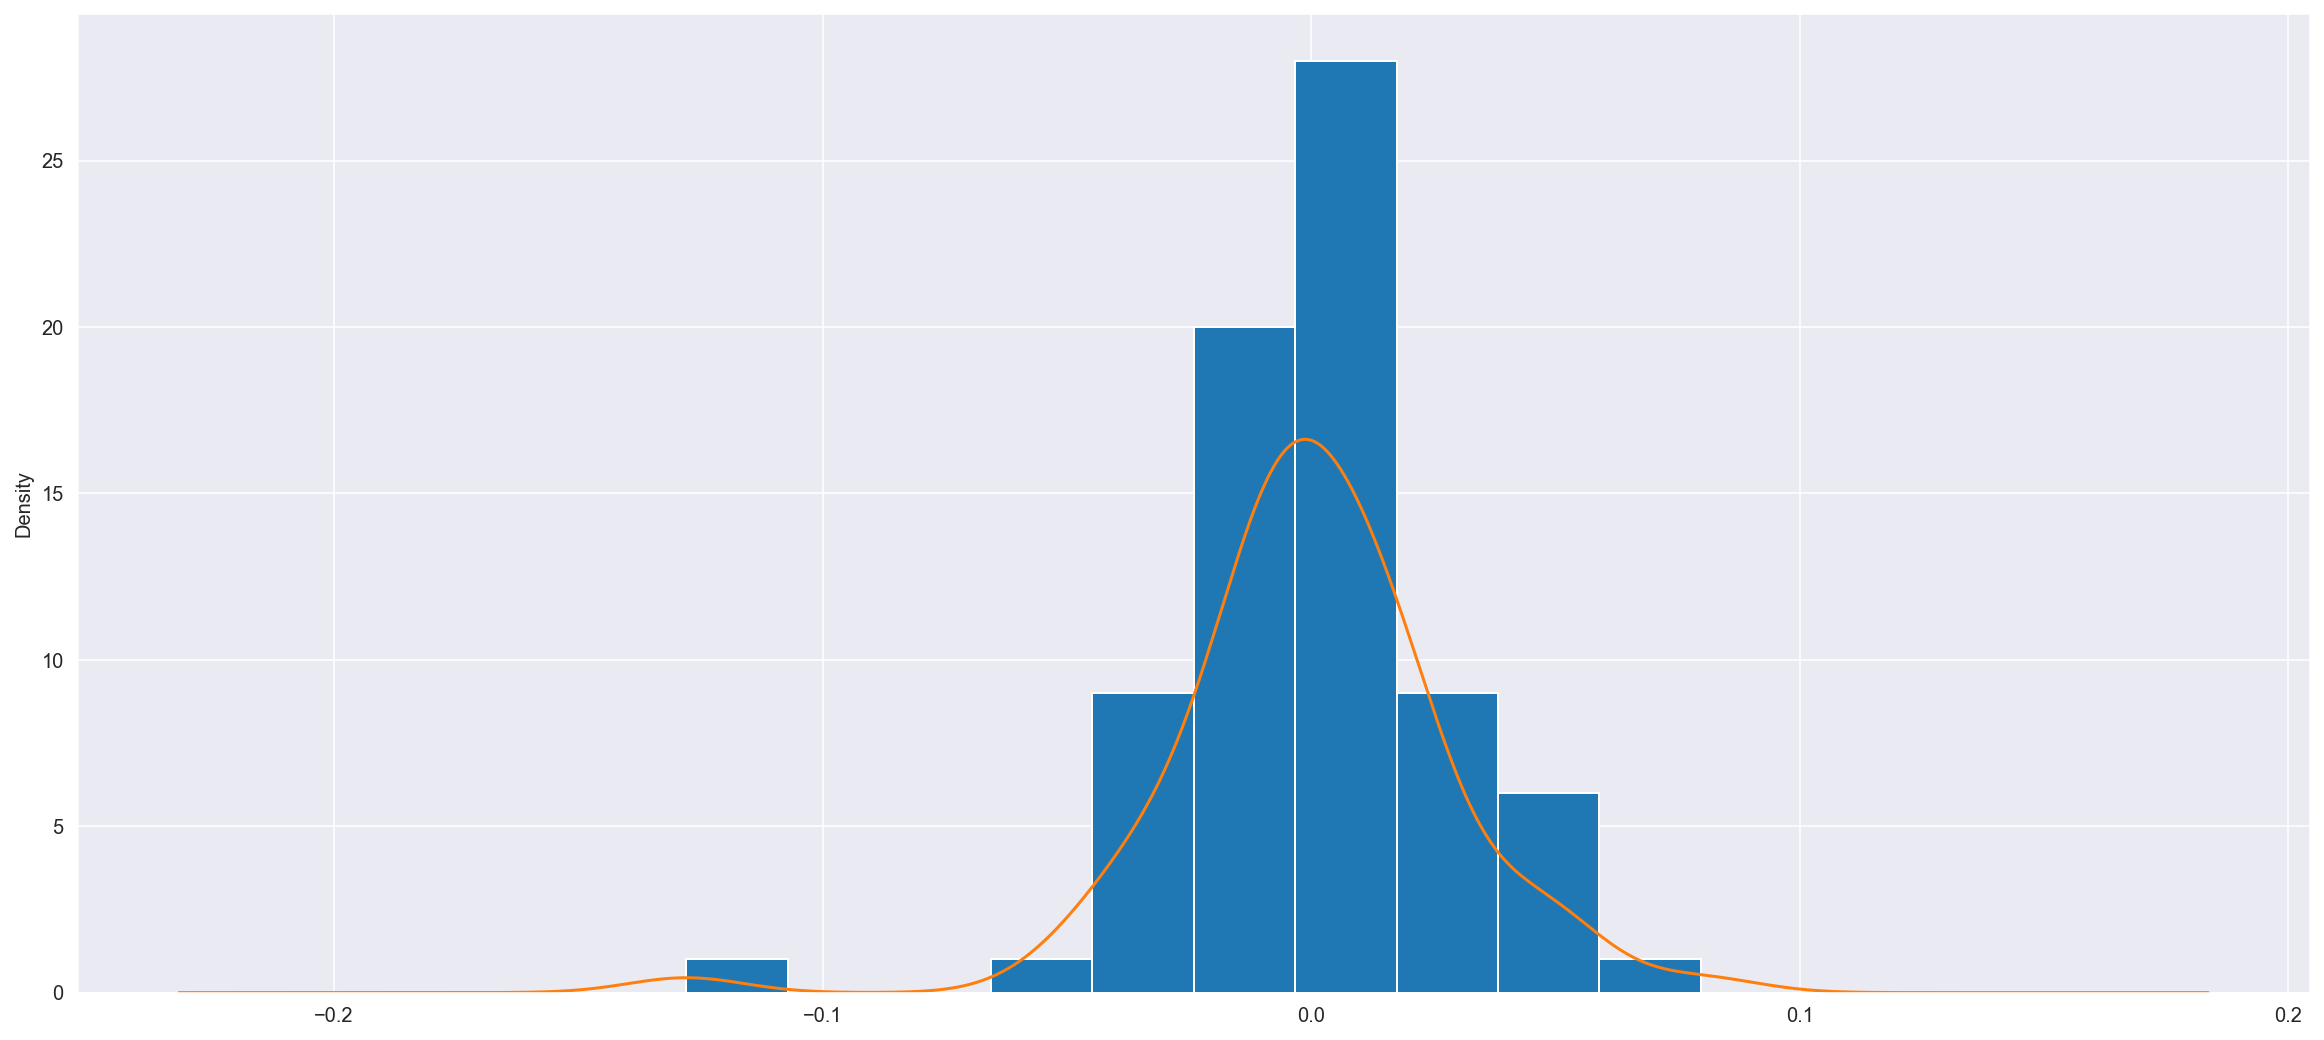

In [51]:
normality_test(resid_p_m)

Graphically, Normality is roughly satisfied. But we can see residuals is more likely having fat tails. Not great.

### Financial/economic interpretation 

Classic Linear Regression assumptions do not perform well in monthly 10 industry scenario since 
- there are some industries are highly correlated with each other
- limited observations in monthly data

In short, 10 indestry portfolio model cannot explain the AQR monthly return very well.

One take-away:

when doing research on industry portfolios, we need to pay attention on the relationships among industries. In other words, when we allocate our portfolio, we want not only to optimize upon equity returns, but also pay attention to equity industry to ensure an enough diversification of our portfolio. 